In [1]:
#Trying to replicate the results of "Adaptive activation functions accelerate convergence in deep and physics-informed neural networks"
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from torch.nn.parameter import Parameter

import numpy as np
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import scipy.io
from scipy.io import savemat

from smt.sampling_methods import LHS

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())


cuda:0


In [2]:
def true_disc(x): #[-4,3.75]
    y  = np.zeros((np.shape(x)[0],))
    
    y = 0.2*np.sin(6*x)*np.exp(-1*x)
    y[x>0] = 1 + 0.1*x[x>0]*np.exp(x[x>0]) + 10
    
    return 50*y

In [3]:
# Domain bounds
label = "Regr_disc_rowdy"
loss_thresh = 0.1

lb = np.array(-4.0)  # [-1. 0.]
ub = np.array(3.75) # [1.  0.99]

x_test = np.linspace(lb,ub,1000).reshape(-1,1)
u_true = true_disc(x_test)

u_true_norm = np.linalg.norm(u_true,2)

In [4]:
def trainingdata(N_train,seed):
    np.random.seed(seed)
    
    x_train = np.random.uniform(low=lb, high=ub, size=(N_train,)).reshape(-1,1)

    u_train = true_disc(x_train)

    return x_train, u_train

In [5]:
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers,n_val,rowdy_terms):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
     
        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
     
        
        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)

        self.omega1 = Parameter(torch.ones((len(layers)-2,1))) 
        #self.alpha = Parameter(torch.ones((layers[1],len(layers)-2)))
        
        self.alpha = Parameter(torch.zeros(rowdy_terms,len(layers)-2))
        self.omega = Parameter((1/n_val)*torch.ones(rowdy_terms,len(layers)-2))
        
        self.n = torch.tensor(n_val)
            
            
    'foward pass'
    def forward(self,x):
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = (x - l_b)/(u_b - l_b) #feature scaling
        
        #convert to float
        a = x.float()
        
        for i in range(len(layers)-2):
            z = self.linears[i](a)
            a = self.activation(self.omega1[i,0]*z)
            for j in range(rowdy_terms):
                a = a + self.alpha[j,i]*self.n*torch.sin((j+1)*self.n*self.omega[j,i]*z)
    
        a = self.linears[-1](a) 
        
        return a
    
    
    def loss(self,x,u):

        loss_val = self.loss_function(self.forward(x),u)
        
        return loss_val
        
    'test neural network'
    def test(self):
        u_pred = self.forward(x_test_tensor)       
        u_pred = u_pred.cpu().detach().numpy()
        
        return u_pred
    
    def test_loss(self):
        u_pred = self.test()
        
        test_mse_loss = np.mean(np.square(u_pred.reshape(-1,1) - u_true.reshape(-1,1)))
        test_re_loss = np.linalg.norm(u_pred.reshape(-1,1) - u_true.reshape(-1,1),2)/u_true_norm
        
        return test_mse_loss, test_re_loss  

In [6]:
def data_update(loss_np):
    train_loss.append(loss_np)
    alpha_val.append(model_NN.alpha.cpu().detach().numpy())
    omega_val.append(model_NN.omega.cpu().detach().numpy())    
    test_mse, test_re = model_NN.test_loss()
    test_mse_loss.append(test_mse)
    test_re_loss.append(test_re)

In [7]:
def train_step():
    optimizer.zero_grad()     # zeroes the gradient buffers of all parameters
    loss = model_NN.loss(x_train,u_train)
    loss.backward() #backprop
    optimizer.step()
    
    return loss

In [8]:
def train_model(max_iter,rep):
    print(rep) 
   
    torch.manual_seed(rep*123)
    start_time = time.time()
    thresh_flag = 0
    
    for i in range(max_iter):
        loss_np = train_step().cpu().detach().numpy()
        if(thresh_flag == 0):
            if(loss_np < loss_thresh):
                time_threshold[rep] = time.time() - start_time
                epoch_threshold[rep] = i+1            
                thresh_flag = 1
                
        data_update(loss_np)
        print(i,"Train Loss",train_loss[-1],"Test MSE",test_mse_loss[-1],"Test RE",test_re_loss[-1])
    
    elapsed_time[rep] = time.time() - start_time
    print('Training time: %.2f' % (elapsed_time[rep]))

In [9]:
max_reps = 10
max_iter = 3000
layers = np.array([1,50,50,50,50,1])

train_loss_full = []
test_mse_full = []
test_re_full = []
alpha_full = []
omega_full = []
elapsed_time= np.zeros((max_reps,1))

time_threshold = np.empty((max_reps,1))
time_threshold[:] = np.nan
epoch_threshold = max_iter*np.ones((max_reps,1))

n_val = 1
rowdy_terms = 2


for reps in range(max_reps):
    print(reps)
    
    train_loss = []
    test_mse_loss = []
    test_re_loss = []
    alpha_val = []
    omega_val = []
    'Generate Training data'
    N_train = 300
    
    x_train_np_array, u_train_np_array = trainingdata(N_train,reps*1234)

    'Convert to tensor and send to GPU'
    x_train = torch.from_numpy(x_train_np_array).float().to(device)
    u_train = torch.from_numpy(u_train_np_array).float().to(device)
    
    x_test_tensor = torch.from_numpy(x_test).float().to(device)
       
     
    model_NN = Sequentialmodel(layers,n_val,rowdy_terms)
    model_NN.to(device)
    print(model_NN)
    params = list(model_NN.parameters())
    #optimizer = optim.Adam(PINN.parameters(), lr=0.0008,betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    optimizer = optim.Adam(model_NN.parameters(), lr=8.0e-3)

    train_model(max_iter,reps)
 
    torch.save(model_NN.state_dict(),label+'_'+str(reps)+'.pt')
    train_loss_full.append(train_loss)
    test_mse_full.append(test_mse_loss)
    test_re_full.append(test_re_loss)
    alpha_full.append(alpha_val)
    omega_full.append(omega_val)
                 

mdic = {"train_loss": train_loss_full,"test_mse": test_mse_full, "test_re": test_re_full,"Time": elapsed_time, "Thresh_time": time_threshold, "epoch_thresh": epoch_threshold,"alpha": alpha_full,"omega": omega_full, "label": label}
savemat(label+'.mat', mdic) 

0
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
0
0 Train Loss 290442.56 Test MSE 272250.5547147745 Test RE 0.9979582860984848
1 Train Loss 289363.78 Test MSE 271002.6616069214 Test RE 0.9956685284233059
2 Train Loss 288037.94 Test MSE 269709.82267068024 Test RE 0.9932907327137083
3 Train Loss 286653.16 Test MSE 268593.9613767364 Test RE 0.9912338490244693
4 Train Loss 285447.62 Test MSE 267768.8150660279 Test RE 0.9897100953018866
5 Train Loss 284549.6 Test MSE 267216.90904886654 Test RE 0.9886896092005196
6 Train Loss 283947.2 Test MSE 266847.97368403326 Test RE 0.9880068519732136
7 Train Loss 283545.97 Test MSE 266571.2838925542 Test RE 

109 Train Loss 172641.55 Test MSE 161727.4648426486 Test RE 0.7691656682498221
110 Train Loss 170784.22 Test MSE 160093.67302200836 Test RE 0.7652707007553098
111 Train Loss 169023.34 Test MSE 158608.8749863287 Test RE 0.761713660347209
112 Train Loss 167407.88 Test MSE 156872.18686618088 Test RE 0.7575319895910423
113 Train Loss 165565.62 Test MSE 155373.24783052344 Test RE 0.7539041324568528
114 Train Loss 163906.39 Test MSE 153860.07755703537 Test RE 0.7502240380543648
115 Train Loss 162238.77 Test MSE 152071.62023347267 Test RE 0.7458510206859019
116 Train Loss 160486.78 Test MSE 150451.36557431985 Test RE 0.7418670269111729
117 Train Loss 158689.89 Test MSE 148978.26999009293 Test RE 0.7382262182577304
118 Train Loss 157042.3 Test MSE 147278.3716527438 Test RE 0.7340024148837019
119 Train Loss 155316.3 Test MSE 145678.9445477065 Test RE 0.7300059417334303
120 Train Loss 153625.25 Test MSE 144085.85583096245 Test RE 0.726003437566451
121 Train Loss 151855.03 Test MSE 142562.6921763

233 Train Loss 33349.8 Test MSE 31446.88819852812 Test RE 0.33916953825086166
234 Train Loss 32981.867 Test MSE 31188.358118661145 Test RE 0.33777247646199876
235 Train Loss 32620.414 Test MSE 30824.004402240807 Test RE 0.33579368994201986
236 Train Loss 32267.334 Test MSE 30464.478914620675 Test RE 0.33382962827729035
237 Train Loss 31925.5 Test MSE 30204.33368093194 Test RE 0.332401237202382
238 Train Loss 31592.07 Test MSE 29841.8351984192 Test RE 0.3304005530884604
239 Train Loss 31265.867 Test MSE 29524.513287397913 Test RE 0.3286392080207898
240 Train Loss 30948.42 Test MSE 29303.351241935954 Test RE 0.32740600997625763
241 Train Loss 30638.941 Test MSE 28960.41140538774 Test RE 0.3254845402008205
242 Train Loss 30334.758 Test MSE 28695.772185203263 Test RE 0.3239939941100367
243 Train Loss 30037.26 Test MSE 28454.876553316753 Test RE 0.3226311935250603
244 Train Loss 29746.121 Test MSE 28122.035378167944 Test RE 0.3207387091176122
245 Train Loss 29458.41 Test MSE 27917.361083527

343 Train Loss 11505.686 Test MSE 11880.558924632707 Test RE 0.20847137850400188
344 Train Loss 11466.239 Test MSE 11263.585705040861 Test RE 0.20298611697592045
345 Train Loss 11450.67 Test MSE 12075.920534758689 Test RE 0.21017842103631498
346 Train Loss 11414.575 Test MSE 11073.035637878143 Test RE 0.20126179914169634
347 Train Loss 11225.681 Test MSE 11441.71661766761 Test RE 0.20458490907679044
348 Train Loss 11022.847 Test MSE 10902.286216022703 Test RE 0.19970401276613292
349 Train Loss 10846.308 Test MSE 10865.806609280567 Test RE 0.19936962289495444
350 Train Loss 10724.851 Test MSE 11034.741823527143 Test RE 0.20091348648785315
351 Train Loss 10659.039 Test MSE 10570.517195660828 Test RE 0.1966419265040762
352 Train Loss 10608.084 Test MSE 11160.334979634781 Test RE 0.20205361128223048
353 Train Loss 10560.654 Test MSE 10328.037043359414 Test RE 0.19437342857343737
354 Train Loss 10479.2 Test MSE 11079.70737915611 Test RE 0.2013224222849972
355 Train Loss 10410.415 Test MSE 1

457 Train Loss 4429.661 Test MSE 5312.70553906829 Test RE 0.1394074150998528
458 Train Loss 4227.082 Test MSE 4350.644928627369 Test RE 0.12615510286715262
459 Train Loss 3938.875 Test MSE 4793.7860608135725 Test RE 0.13242419024083787
460 Train Loss 3917.6 Test MSE 4786.403969086297 Test RE 0.13232218901016793
461 Train Loss 3853.1267 Test MSE 4216.711624676684 Test RE 0.12419810012591963
462 Train Loss 4017.3801 Test MSE 5992.867601800054 Test RE 0.14806259045179293
463 Train Loss 4316.304 Test MSE 4640.578258016483 Test RE 0.130290890480993
464 Train Loss 4213.9766 Test MSE 4910.377080820273 Test RE 0.13402487901033336
465 Train Loss 3894.435 Test MSE 4163.306814121847 Test RE 0.12340910721606892
466 Train Loss 3705.6484 Test MSE 4421.817634879207 Test RE 0.12718280982145228
467 Train Loss 3743.7102 Test MSE 4742.83725790435 Test RE 0.1317186021805175
468 Train Loss 3641.471 Test MSE 4081.981914355767 Test RE 0.12219784299784124
469 Train Loss 3776.1692 Test MSE 5192.693202006087 Te

584 Train Loss 2717.2546 Test MSE 4140.346251526386 Test RE 0.12306833722217711
585 Train Loss 2214.1304 Test MSE 2826.2058065651077 Test RE 0.10167867870253483
586 Train Loss 2635.595 Test MSE 2705.3508854998 Test RE 0.0994809221810206
587 Train Loss 1692.8663 Test MSE 3297.5014571579895 Test RE 0.10982987767462823
588 Train Loss 2071.5454 Test MSE 2046.3108823443865 Test RE 0.08651946170771425
589 Train Loss 1974.7847 Test MSE 2924.6799306529397 Test RE 0.10343491795749042
590 Train Loss 1800.2046 Test MSE 2929.966203008196 Test RE 0.10352835353144617
591 Train Loss 1737.7777 Test MSE 2142.0660018955296 Test RE 0.08852061570065596
592 Train Loss 1820.1029 Test MSE 2342.2499199024714 Test RE 0.09256453381245687
593 Train Loss 1547.0615 Test MSE 2326.3469648072432 Test RE 0.09224976022870719
594 Train Loss 1562.4852 Test MSE 2046.303483229593 Test RE 0.08651930528768706
595 Train Loss 1719.4755 Test MSE 2646.152820579217 Test RE 0.09838648902250954
596 Train Loss 1578.4867 Test MSE 226

711 Train Loss 1232.3402 Test MSE 2734.688064008021 Test RE 0.10001885980653963
712 Train Loss 1303.8794 Test MSE 1579.9424459238646 Test RE 0.0760236357120695
713 Train Loss 1189.1975 Test MSE 1356.744284097222 Test RE 0.07044935189390018
714 Train Loss 909.2961 Test MSE 2052.5680385934543 Test RE 0.08665163922363059
715 Train Loss 1195.6196 Test MSE 1316.281205656932 Test RE 0.06939087150624869
716 Train Loss 937.7597 Test MSE 1355.5308893919287 Test RE 0.07041784190602553
717 Train Loss 1019.13983 Test MSE 2092.8240572016675 Test RE 0.08749724148619786
718 Train Loss 1043.7389 Test MSE 1577.6183850410243 Test RE 0.07596770057954845
719 Train Loss 899.26276 Test MSE 1380.1488099671321 Test RE 0.0710543972120613
720 Train Loss 1191.0786 Test MSE 2609.768671472441 Test RE 0.09770774910148543
721 Train Loss 1269.8527 Test MSE 1965.639475806642 Test RE 0.08479689198076315
722 Train Loss 998.8916 Test MSE 1532.5885478752393 Test RE 0.07487568177203573
723 Train Loss 1676.2698 Test MSE 331

838 Train Loss 455.34293 Test MSE 749.9606509226273 Test RE 0.052377798492034
839 Train Loss 497.1518 Test MSE 1439.9174867572065 Test RE 0.07257663106211844
840 Train Loss 648.58374 Test MSE 789.9464348103627 Test RE 0.05375598493017908
841 Train Loss 623.9132 Test MSE 1733.4916326238208 Test RE 0.0796322298016648
842 Train Loss 773.90314 Test MSE 809.1191943393677 Test RE 0.05440442865177035
843 Train Loss 494.82318 Test MSE 801.5385355818286 Test RE 0.05414897064260387
844 Train Loss 444.6275 Test MSE 1255.0514545564326 Test RE 0.06775771744981966
845 Train Loss 584.38116 Test MSE 788.302077714343 Test RE 0.05370000639815433
846 Train Loss 726.0473 Test MSE 2710.5859074089535 Test RE 0.09957712654321273
847 Train Loss 1250.2933 Test MSE 1261.4021577525632 Test RE 0.06792893201269433
848 Train Loss 579.4517 Test MSE 1400.9653572368463 Test RE 0.07158824240175489
849 Train Loss 1704.1285 Test MSE 6913.873775140574 Test RE 0.15903353958069588
850 Train Loss 3914.7476 Test MSE 4866.0074

965 Train Loss 365.6164 Test MSE 887.7806234418621 Test RE 0.056987661083617726
966 Train Loss 386.93622 Test MSE 647.8895357581026 Test RE 0.04868312909622911
967 Train Loss 541.73413 Test MSE 2074.759402057453 Test RE 0.08711879755395893
968 Train Loss 963.9594 Test MSE 707.7051620943206 Test RE 0.050880829573253426
969 Train Loss 428.0684 Test MSE 707.1675538005226 Test RE 0.0508615000881287
970 Train Loss 438.48465 Test MSE 1721.1288490007307 Test RE 0.07934776417526121
971 Train Loss 779.75604 Test MSE 727.6303571674241 Test RE 0.05159212387918292
972 Train Loss 560.30176 Test MSE 1041.3596510629072 Test RE 0.06172034926397088
973 Train Loss 429.52344 Test MSE 630.586845011359 Test RE 0.04802865834975393
974 Train Loss 356.74252 Test MSE 645.1428816053236 Test RE 0.0485798261945266
975 Train Loss 333.79578 Test MSE 974.7600415404139 Test RE 0.05971409582608167
976 Train Loss 390.0305 Test MSE 641.9572437690902 Test RE 0.048459737099756
977 Train Loss 412.22208 Test MSE 1144.360412

1090 Train Loss 4948.6157 Test MSE 15437.561274847336 Test RE 0.23763879911045876
1091 Train Loss 10026.445 Test MSE 9906.698558764068 Test RE 0.1903673551269615
1092 Train Loss 5726.639 Test MSE 6138.220069912087 Test RE 0.1498474059889895
1093 Train Loss 5388.428 Test MSE 5252.229267846027 Test RE 0.13861168391556536
1094 Train Loss 5960.5596 Test MSE 7040.047381974622 Test RE 0.16047810704253854
1095 Train Loss 5110.789 Test MSE 7448.499059808764 Test RE 0.16506780849942287
1096 Train Loss 4839.23 Test MSE 6809.006253048322 Test RE 0.15782284514282693
1097 Train Loss 4863.9106 Test MSE 4817.53131181152 Test RE 0.1327517561076539
1098 Train Loss 3668.1484 Test MSE 3621.0465401193214 Test RE 0.11509197830638743
1099 Train Loss 2977.2537 Test MSE 3201.482092487048 Test RE 0.10821900592854705
1100 Train Loss 2646.796 Test MSE 2892.2293167084226 Test RE 0.10285948932600597
1101 Train Loss 2594.914 Test MSE 3383.369677288161 Test RE 0.11125069382819175
1102 Train Loss 2806.83 Test MSE 248

1213 Train Loss 650.54156 Test MSE 956.1582786855688 Test RE 0.05914157644345876
1214 Train Loss 567.37286 Test MSE 1314.4666413908521 Test RE 0.06934302549124384
1215 Train Loss 668.4148 Test MSE 838.2829551475364 Test RE 0.05537622157589418
1216 Train Loss 612.2301 Test MSE 855.7109658839307 Test RE 0.055948899768034126
1217 Train Loss 406.96497 Test MSE 845.7031183126888 Test RE 0.05562076628190592
1218 Train Loss 461.79703 Test MSE 860.9034042364508 Test RE 0.056118391484498306
1219 Train Loss 445.3556 Test MSE 948.2493183600724 Test RE 0.05889647075835722
1220 Train Loss 406.3054 Test MSE 645.1222596134618 Test RE 0.048579049761262844
1221 Train Loss 384.43518 Test MSE 899.602799862459 Test RE 0.05736584578115322
1222 Train Loss 414.03427 Test MSE 639.4110345703657 Test RE 0.04836353815304022
1223 Train Loss 381.28256 Test MSE 1068.0957813699265 Test RE 0.06250763992049232
1224 Train Loss 446.25406 Test MSE 635.3237518696762 Test RE 0.04820871413988923
1225 Train Loss 385.81018 Te

1325 Train Loss 995.3763 Test MSE 801.4134782290632 Test RE 0.054144746272359975
1326 Train Loss 495.29007 Test MSE 1646.2413237841993 Test RE 0.07760232826557716
1327 Train Loss 907.60315 Test MSE 897.2829535674687 Test RE 0.05729183208842788
1328 Train Loss 627.38556 Test MSE 870.1483422038017 Test RE 0.05641890466756589
1329 Train Loss 1059.2704 Test MSE 2382.8994504997463 Test RE 0.09336430321649956
1330 Train Loss 1160.4144 Test MSE 2026.927361488651 Test RE 0.08610871225554141
1331 Train Loss 826.2933 Test MSE 1109.1966162708939 Test RE 0.06369894945384666
1332 Train Loss 931.3695 Test MSE 1089.818541169415 Test RE 0.06314007566333829
1333 Train Loss 624.51 Test MSE 1650.1809570615983 Test RE 0.07769512815490442
1334 Train Loss 789.033 Test MSE 774.3121775168611 Test RE 0.05322136960425152
1335 Train Loss 366.32986 Test MSE 732.9470025631917 Test RE 0.051780267343398766
1336 Train Loss 754.1562 Test MSE 2189.3051063045414 Test RE 0.08949136798065187
1337 Train Loss 1091.9664 Test

1450 Train Loss 1142.8904 Test MSE 1474.6123264678356 Test RE 0.07344579426489035
1451 Train Loss 672.141 Test MSE 1875.4867419066595 Test RE 0.08282949261597132
1452 Train Loss 854.1023 Test MSE 675.085945646319 Test RE 0.04969440958666717
1453 Train Loss 434.0597 Test MSE 699.002051719426 Test RE 0.0505670044442168
1454 Train Loss 655.27856 Test MSE 1875.7140611903515 Test RE 0.08283451215836725
1455 Train Loss 816.55426 Test MSE 1617.9706465538052 Test RE 0.07693311566168161
1456 Train Loss 683.24817 Test MSE 691.544636618549 Test RE 0.05029654005253737
1457 Train Loss 771.89465 Test MSE 835.7025612354164 Test RE 0.05529092663088299
1458 Train Loss 310.22482 Test MSE 1302.4866467948939 Test RE 0.06902630746776421
1459 Train Loss 500.15573 Test MSE 548.6418778565613 Test RE 0.04479942903178071
1460 Train Loss 269.3455 Test MSE 469.86892505000793 Test RE 0.041458765266851445
1461 Train Loss 416.5692 Test MSE 1374.738630983429 Test RE 0.07091499395631022
1462 Train Loss 587.4746 Test M

1575 Train Loss 85.86721 Test MSE 412.8303493743342 Test RE 0.038860985539155346
1576 Train Loss 84.92574 Test MSE 416.5893314588456 Test RE 0.0390375068755641
1577 Train Loss 84.02797 Test MSE 422.3372634247457 Test RE 0.03930589617110541
1578 Train Loss 83.21753 Test MSE 411.0341428155464 Test RE 0.038776352166656765
1579 Train Loss 82.46184 Test MSE 426.13574499547803 Test RE 0.03948225820558743
1580 Train Loss 81.707085 Test MSE 408.23285120942234 Test RE 0.038643991413631326
1581 Train Loss 80.91352 Test MSE 426.2135766437727 Test RE 0.03948586366343469
1582 Train Loss 80.12335 Test MSE 410.1203974669967 Test RE 0.03873322749503062
1583 Train Loss 79.287964 Test MSE 424.0716805221216 Test RE 0.039386522457344045
1584 Train Loss 78.484886 Test MSE 415.01952705457956 Test RE 0.03896388630359862
1585 Train Loss 77.688644 Test MSE 420.64954087863043 Test RE 0.03922728144865191
1586 Train Loss 76.91676 Test MSE 418.45155306361164 Test RE 0.039124661566082436
1587 Train Loss 76.178116 T

1699 Train Loss 1485.4053 Test MSE 1102.667958035013 Test RE 0.0635112088782151
1700 Train Loss 819.46265 Test MSE 1346.7654837221291 Test RE 0.07018979766644827
1701 Train Loss 719.10156 Test MSE 1061.9819358545103 Test RE 0.06232848440315574
1702 Train Loss 784.9983 Test MSE 942.0941176714713 Test RE 0.05870500750230458
1703 Train Loss 1356.7869 Test MSE 3245.2348784106953 Test RE 0.10895597950045227
1704 Train Loss 1691.7025 Test MSE 3296.7866669852647 Test RE 0.1098179732716948
1705 Train Loss 1310.1943 Test MSE 2521.186989980654 Test RE 0.09603521887520489
1706 Train Loss 1674.075 Test MSE 1475.5781437068879 Test RE 0.07346984248480966
1707 Train Loss 1101.0253 Test MSE 943.8453174574621 Test RE 0.05875954370252397
1708 Train Loss 640.7181 Test MSE 1082.797126734715 Test RE 0.06293634953811729
1709 Train Loss 868.8963 Test MSE 1179.0299946475232 Test RE 0.06567354030374599
1710 Train Loss 1084.4193 Test MSE 1412.7807432470597 Test RE 0.07188948710731882
1711 Train Loss 867.57855 T

1824 Train Loss 45.721718 Test MSE 399.7766095579798 Test RE 0.038241656137615994
1825 Train Loss 45.123688 Test MSE 407.5915430140342 Test RE 0.03861362584041116
1826 Train Loss 44.51161 Test MSE 400.70610502792204 Test RE 0.03828608696242795
1827 Train Loss 43.963367 Test MSE 409.9832006370094 Test RE 0.03872674827507264
1828 Train Loss 43.4013 Test MSE 398.86068408015825 Test RE 0.03819782341754674
1829 Train Loss 42.817013 Test MSE 409.7924245526434 Test RE 0.0387177369338044
1830 Train Loss 42.287415 Test MSE 398.9384088224975 Test RE 0.03820154498184198
1831 Train Loss 41.751854 Test MSE 412.72627659188845 Test RE 0.03885608688547823
1832 Train Loss 41.20237 Test MSE 400.9490804740513 Test RE 0.038297692936449614
1833 Train Loss 40.699722 Test MSE 414.8371993076801 Test RE 0.038955326491868884
1834 Train Loss 40.19193 Test MSE 400.1344203590619 Test RE 0.038258765964622396
1835 Train Loss 39.68295 Test MSE 414.71396862483493 Test RE 0.03894954006763904
1836 Train Loss 39.20802 Te

1942 Train Loss 119.96959 Test MSE 519.1283146101947 Test RE 0.04357780592124622
1943 Train Loss 122.21547 Test MSE 361.7179667955872 Test RE 0.03637584095440811
1944 Train Loss 198.72269 Test MSE 878.8063831745659 Test RE 0.05669889606454726
1945 Train Loss 276.72797 Test MSE 333.666106159452 Test RE 0.03493687438927663
1946 Train Loss 226.74962 Test MSE 781.5306951624581 Test RE 0.05346887195472154
1947 Train Loss 211.33305 Test MSE 376.0261039262413 Test RE 0.03708830615474826
1948 Train Loss 131.92918 Test MSE 409.1456039224486 Test RE 0.03868716862713005
1949 Train Loss 92.211525 Test MSE 444.80350580127674 Test RE 0.04033779017825858
1950 Train Loss 105.76157 Test MSE 327.386456233805 Test RE 0.03460655403160914
1951 Train Loss 132.97357 Test MSE 802.8900600942704 Test RE 0.054194603406337784
1952 Train Loss 208.49551 Test MSE 345.15853373150253 Test RE 0.0355334445704332
1953 Train Loss 180.66028 Test MSE 683.8249571984853 Test RE 0.050015023282961035
1954 Train Loss 183.86958 T

2068 Train Loss 180.59692 Test MSE 757.9739351843923 Test RE 0.05265688178262063
2069 Train Loss 161.0871 Test MSE 266.02494660772953 Test RE 0.03119530126823078
2070 Train Loss 105.951355 Test MSE 550.4805833291939 Test RE 0.04487443611596868
2071 Train Loss 77.9353 Test MSE 318.94621364845614 Test RE 0.034157551141075514
2072 Train Loss 53.26541 Test MSE 414.3137151558309 Test RE 0.03893073981849309
2073 Train Loss 40.63497 Test MSE 392.73859584092713 Test RE 0.037903541795783764
2074 Train Loss 39.34903 Test MSE 304.225941287126 Test RE 0.033360006269280006
2075 Train Loss 46.61584 Test MSE 517.4499665316328 Test RE 0.043507305107551325
2076 Train Loss 61.672897 Test MSE 281.0610763277519 Test RE 0.03206478663320427
2077 Train Loss 72.86132 Test MSE 620.9342246682914 Test RE 0.04765964474711208
2078 Train Loss 93.83735 Test MSE 274.35032484070024 Test RE 0.031679676726562245
2079 Train Loss 101.64589 Test MSE 720.8098746082992 Test RE 0.051349753791027415
2080 Train Loss 127.95242 T

2190 Train Loss 83.22037 Test MSE 301.7500575210307 Test RE 0.033223981984546326
2191 Train Loss 54.747852 Test MSE 375.8329684803595 Test RE 0.03707878023821533
2192 Train Loss 34.492985 Test MSE 467.15774895242356 Test RE 0.041338982260627384
2193 Train Loss 45.235535 Test MSE 304.7968550884627 Test RE 0.03339129347797068
2194 Train Loss 57.13866 Test MSE 565.8349431749391 Test RE 0.0454959652729724
2195 Train Loss 73.78513 Test MSE 272.75994810539373 Test RE 0.03158772157976586
2196 Train Loss 77.348076 Test MSE 611.0994648890376 Test RE 0.04728070607587109
2197 Train Loss 78.7174 Test MSE 295.8101138422232 Test RE 0.03289534996641091
2198 Train Loss 70.63307 Test MSE 533.4166737334086 Test RE 0.04417344753578847
2199 Train Loss 56.133263 Test MSE 296.72144293150154 Test RE 0.032945982845510056
2200 Train Loss 43.845234 Test MSE 432.52970119213035 Test RE 0.03977736124161932
2201 Train Loss 31.45571 Test MSE 385.7141518836976 Test RE 0.0375630448282534
2202 Train Loss 28.143389 Test

2314 Train Loss 229.91821 Test MSE 432.9748592599533 Test RE 0.03979782533867097
2315 Train Loss 317.9865 Test MSE 932.9432676785868 Test RE 0.05841920188025095
2316 Train Loss 361.0433 Test MSE 515.669923235458 Test RE 0.043432407426819496
2317 Train Loss 208.102 Test MSE 380.2067709467964 Test RE 0.037293910583448726
2318 Train Loss 304.52167 Test MSE 1054.912785351922 Test RE 0.062120691262440776
2319 Train Loss 426.62186 Test MSE 463.52984158672746 Test RE 0.04117815189227271
2320 Train Loss 198.05397 Test MSE 366.2191929178948 Test RE 0.03660147205687359
2321 Train Loss 316.73404 Test MSE 1412.8617410018192 Test RE 0.07189154786714201
2322 Train Loss 607.99176 Test MSE 558.8010213614766 Test RE 0.04521229966772233
2323 Train Loss 194.20213 Test MSE 495.42953868261765 Test RE 0.04257149974817341
2324 Train Loss 586.58575 Test MSE 2467.1381466352705 Test RE 0.09500024734021899
2325 Train Loss 1261.2487 Test MSE 1681.3979517712908 Test RE 0.0784265767484449
2326 Train Loss 699.1599 T

2436 Train Loss 150.38493 Test MSE 780.4409913017458 Test RE 0.05343158259371167
2437 Train Loss 146.80627 Test MSE 253.019768068274 Test RE 0.030423223538473116
2438 Train Loss 129.80235 Test MSE 665.5494820382934 Test RE 0.04934216221533435
2439 Train Loss 97.99788 Test MSE 277.46159316353703 Test RE 0.03185880191447844
2440 Train Loss 64.65211 Test MSE 464.7138151206892 Test RE 0.041230708108619604
2441 Train Loss 36.72382 Test MSE 407.95374326414174 Test RE 0.038630778746884455
2442 Train Loss 29.34269 Test MSE 320.3717789147739 Test RE 0.03423380150409704
2443 Train Loss 40.655758 Test MSE 569.4582227834726 Test RE 0.04564139774793983
2444 Train Loss 59.21097 Test MSE 273.2928513586266 Test RE 0.03161856369164496
2445 Train Loss 78.895836 Test MSE 647.4463290544988 Test RE 0.0486664747290324
2446 Train Loss 86.80982 Test MSE 263.27887496155097 Test RE 0.031033875145967352
2447 Train Loss 89.280464 Test MSE 617.5271560024753 Test RE 0.04752871055675568
2448 Train Loss 76.15769 Test

2560 Train Loss 881.6169 Test MSE 1616.1808092492115 Test RE 0.07689055127311598
2561 Train Loss 763.2095 Test MSE 922.5314777793676 Test RE 0.05809230363795702
2562 Train Loss 558.5128 Test MSE 847.4393708683974 Test RE 0.055677832514855766
2563 Train Loss 702.55084 Test MSE 1401.5487855811696 Test RE 0.0716031472179333
2564 Train Loss 606.7652 Test MSE 1325.3207682797424 Test RE 0.06962873476651062
2565 Train Loss 649.55554 Test MSE 999.7931511181888 Test RE 0.06047600308542826
2566 Train Loss 474.53043 Test MSE 996.9965456981953 Test RE 0.060391362600685033
2567 Train Loss 564.39575 Test MSE 743.1308445121098 Test RE 0.052138753679885054
2568 Train Loss 498.8621 Test MSE 1022.0695467076504 Test RE 0.06114602450380949
2569 Train Loss 460.96417 Test MSE 1060.36618387204 Test RE 0.062281051531040625
2570 Train Loss 448.76007 Test MSE 774.5802652829935 Test RE 0.05323058214392496
2571 Train Loss 434.77502 Test MSE 836.0485585432082 Test RE 0.05530237121233731
2572 Train Loss 416.9358 Te

2683 Train Loss 722.891 Test MSE 1418.0639526780026 Test RE 0.07202377999048758
2684 Train Loss 778.7123 Test MSE 860.8650827103393 Test RE 0.056117142467287766
2685 Train Loss 577.662 Test MSE 1058.3202252812264 Test RE 0.0622209374027495
2686 Train Loss 549.4104 Test MSE 916.654909031272 Test RE 0.05790698269234449
2687 Train Loss 470.18018 Test MSE 701.880741509633 Test RE 0.050671022133117555
2688 Train Loss 568.1739 Test MSE 1111.8336682761803 Test RE 0.06377462482069562
2689 Train Loss 488.07297 Test MSE 961.3793048178619 Test RE 0.05930282555521401
2690 Train Loss 486.44992 Test MSE 715.807153781156 Test RE 0.05117124918557624
2691 Train Loss 443.3934 Test MSE 960.949054130829 Test RE 0.05928955403133635
2692 Train Loss 501.39594 Test MSE 565.8604934754104 Test RE 0.04549699244748221
2693 Train Loss 358.7855 Test MSE 717.3794325736794 Test RE 0.05122741748283766
2694 Train Loss 365.3004 Test MSE 829.2429823830357 Test RE 0.055076825969670375
2695 Train Loss 337.6576 Test MSE 568

2809 Train Loss 427.1744 Test MSE 733.3080091564874 Test RE 0.05179301773097422
2810 Train Loss 903.9944 Test MSE 1546.9675708610448 Test RE 0.07522611034021841
2811 Train Loss 646.52954 Test MSE 1283.5105075498002 Test RE 0.06852163482357587
2812 Train Loss 494.3237 Test MSE 748.5719353385824 Test RE 0.05232928156741358
2813 Train Loss 923.33167 Test MSE 1366.9110612011139 Test RE 0.07071281571566095
2814 Train Loss 541.734 Test MSE 1316.827201402148 Test RE 0.06940526174153433
2815 Train Loss 507.1622 Test MSE 630.1210046375785 Test RE 0.04801091470195013
2816 Train Loss 693.5209 Test MSE 839.2356722240871 Test RE 0.05540768045869405
2817 Train Loss 303.99048 Test MSE 942.2122748713005 Test RE 0.058708688770287766
2818 Train Loss 373.56485 Test MSE 493.51660081822376 Test RE 0.042489232352148035
2819 Train Loss 483.76575 Test MSE 799.4647147288032 Test RE 0.05407887545128822
2820 Train Loss 282.51227 Test MSE 777.5403681469978 Test RE 0.05333219701451344
2821 Train Loss 268.1772 Test

2933 Train Loss 132.71922 Test MSE 1080.8985806410287 Test RE 0.06288114991663839
2934 Train Loss 343.3574 Test MSE 265.60008911100874 Test RE 0.03117038094838293
2935 Train Loss 252.12308 Test MSE 896.3222277874517 Test RE 0.057261152534604336
2936 Train Loss 224.69229 Test MSE 278.62111275346024 Test RE 0.03192530191305602
2937 Train Loss 81.20134 Test MSE 344.53244664073827 Test RE 0.03550120267800077
2938 Train Loss 46.55864 Test MSE 665.2103741166959 Test RE 0.049329590310152605
2939 Train Loss 110.39714 Test MSE 246.5030964372938 Test RE 0.03002888393469339
2940 Train Loss 159.76591 Test MSE 912.908056481754 Test RE 0.05778851330188485
2941 Train Loss 225.13818 Test MSE 245.56946238882298 Test RE 0.029971962569495556
2942 Train Loss 154.36981 Test MSE 679.1339975896217 Test RE 0.049843179449656855
2943 Train Loss 109.35552 Test MSE 303.6807801123554 Test RE 0.033330102943396375
2944 Train Loss 47.7494 Test MSE 357.280830397332 Test RE 0.03615204420779683
2945 Train Loss 31.406397

57 Train Loss 253203.8 Test MSE 236792.94162185327 Test RE 0.9307057095800725
58 Train Loss 252140.17 Test MSE 235832.85130354884 Test RE 0.9288169938003663
59 Train Loss 251062.19 Test MSE 234875.40994127846 Test RE 0.9269296565842635
60 Train Loss 249988.97 Test MSE 233902.63782062175 Test RE 0.9250081551184741
61 Train Loss 248897.42 Test MSE 232950.2866687169 Test RE 0.923123116293671
62 Train Loss 247824.33 Test MSE 232039.6404417477 Test RE 0.9213170190400439
63 Train Loss 246808.78 Test MSE 231171.04774741922 Test RE 0.919591021862477
64 Train Loss 245817.66 Test MSE 230037.19031289255 Test RE 0.917333025405672
65 Train Loss 244554.14 Test MSE 228905.33260918074 Test RE 0.9150734542823937
66 Train Loss 243275.62 Test MSE 228027.9298015069 Test RE 0.9133180149006147
67 Train Loss 242273.45 Test MSE 226836.63715809857 Test RE 0.9109291544385334
68 Train Loss 240941.42 Test MSE 225837.72080538128 Test RE 0.9089212203905906
69 Train Loss 239818.81 Test MSE 224794.86219603606 Test RE

177 Train Loss 79516.625 Test MSE 78104.75066138445 Test RE 0.5345234058794553
178 Train Loss 78757.766 Test MSE 78451.0083301497 Test RE 0.535706932814821
179 Train Loss 78087.88 Test MSE 75511.11807165724 Test RE 0.5255734912051795
180 Train Loss 75927.484 Test MSE 74292.5350100791 Test RE 0.5213154434160766
181 Train Loss 74241.49 Test MSE 73583.90526949595 Test RE 0.5188232362974095
182 Train Loss 73425.05 Test MSE 72509.5537318224 Test RE 0.5150218065954912
183 Train Loss 72699.99 Test MSE 71892.46098115458 Test RE 0.5128255766256443
184 Train Loss 71459.35 Test MSE 70350.06863240582 Test RE 0.5072946293832555
185 Train Loss 70305.195 Test MSE 69948.10979346064 Test RE 0.5058432898791063
186 Train Loss 69620.87 Test MSE 68744.29904494518 Test RE 0.5014716038363133
187 Train Loss 68454.52 Test MSE 67457.61812947712 Test RE 0.4967564366312468
188 Train Loss 66971.12 Test MSE 66383.74300107938 Test RE 0.49278657736979625
189 Train Loss 66015.305 Test MSE 65979.51227678238 Test RE 0.4

293 Train Loss 25824.086 Test MSE 26537.054402776725 Test RE 0.3115690852389683
294 Train Loss 24670.637 Test MSE 25045.76894102723 Test RE 0.30268798807493563
295 Train Loss 23380.19 Test MSE 25295.316504828912 Test RE 0.3041921908470268
296 Train Loss 23972.248 Test MSE 24811.730181338746 Test RE 0.30127044343897824
297 Train Loss 23444.465 Test MSE 24405.033325921035 Test RE 0.2987911324810588
298 Train Loss 22623.158 Test MSE 24767.353335156775 Test RE 0.30100090529446266
299 Train Loss 23005.416 Test MSE 23497.018339772658 Test RE 0.2931800264990603
300 Train Loss 22052.947 Test MSE 24090.154767616295 Test RE 0.2968573436081913
301 Train Loss 22788.43 Test MSE 23361.170421003008 Test RE 0.2923312883939184
302 Train Loss 21734.453 Test MSE 23635.75908814776 Test RE 0.29404430953921545
303 Train Loss 21896.947 Test MSE 23173.818882682303 Test RE 0.2911567118113314
304 Train Loss 21454.521 Test MSE 22682.564883030453 Test RE 0.28805411435429595
305 Train Loss 21181.42 Test MSE 22846.

433 Train Loss 8516.558 Test MSE 9938.540439794342 Test RE 0.19067304685880798
434 Train Loss 8465.542 Test MSE 9879.096230473806 Test RE 0.19010196664129972
435 Train Loss 8414.735 Test MSE 9827.50600124795 Test RE 0.1896049453901569
436 Train Loss 8364.218 Test MSE 9770.187801442755 Test RE 0.18905120841186235
437 Train Loss 8314.1455 Test MSE 9720.817800781977 Test RE 0.18857295358470574
438 Train Loss 8264.481 Test MSE 9666.23939401955 Test RE 0.18804282851547124
439 Train Loss 8215.242 Test MSE 9613.571385142925 Test RE 0.18752983848435234
440 Train Loss 8166.382 Test MSE 9563.208937621344 Test RE 0.18703798884232986
441 Train Loss 8117.8237 Test MSE 9510.202803403377 Test RE 0.18651891951894686
442 Train Loss 8069.555 Test MSE 9458.952318089718 Test RE 0.1860156653415682
443 Train Loss 8021.5317 Test MSE 9406.075816246706 Test RE 0.18549501348947034
444 Train Loss 7973.7495 Test MSE 9360.251281688981 Test RE 0.18504261437175137
445 Train Loss 7926.227 Test MSE 9303.937598980405 T

551 Train Loss 4193.271 Test MSE 4970.222778655688 Test RE 0.13483912621289504
552 Train Loss 4058.0864 Test MSE 4748.025093951173 Test RE 0.13179062107081893
553 Train Loss 3988.8335 Test MSE 5030.8119335158135 Test RE 0.13565851010834457
554 Train Loss 3960.7742 Test MSE 4670.361963371338 Test RE 0.13070833187987627
555 Train Loss 3876.5334 Test MSE 4687.39049695189 Test RE 0.13094640187198517
556 Train Loss 3785.7422 Test MSE 4566.885596566478 Test RE 0.1292522369262132
557 Train Loss 3759.29 Test MSE 4568.358187560916 Test RE 0.1292730739206086
558 Train Loss 3727.7405 Test MSE 4536.51220045833 Test RE 0.12882170515894684
559 Train Loss 3693.8967 Test MSE 4550.648699946905 Test RE 0.12902226358294178
560 Train Loss 3662.1147 Test MSE 4412.332477243257 Test RE 0.12704632786727452
561 Train Loss 3674.5198 Test MSE 4674.031609980937 Test RE 0.13075967256910914
562 Train Loss 3704.2058 Test MSE 4543.960813528789 Test RE 0.12892741957599324
563 Train Loss 3782.5723 Test MSE 4950.6299522

675 Train Loss 1861.4215 Test MSE 2394.1566716180682 Test RE 0.09358457777043017
676 Train Loss 1962.53 Test MSE 2663.229322563446 Test RE 0.09870343882543958
677 Train Loss 1962.0029 Test MSE 2207.144339167055 Test RE 0.08985523193130827
678 Train Loss 1781.925 Test MSE 2158.404021483789 Test RE 0.08885755776907939
679 Train Loss 1677.8806 Test MSE 2210.385324299746 Test RE 0.08992117973474262
680 Train Loss 1700.1007 Test MSE 2207.333916328584 Test RE 0.0898590907940359
681 Train Loss 1781.061 Test MSE 2459.6903323515644 Test RE 0.09485674524398317
682 Train Loss 1834.6299 Test MSE 2181.9908234366562 Test RE 0.08934175137293703
683 Train Loss 1764.4325 Test MSE 2200.3617484068404 Test RE 0.0897170623994694
684 Train Loss 1676.9222 Test MSE 2055.589008021531 Test RE 0.08671538271468661
685 Train Loss 1615.9269 Test MSE 2047.8215933841009 Test RE 0.08655139277747974
686 Train Loss 1623.6753 Test MSE 2183.621810076071 Test RE 0.08937513556084689
687 Train Loss 1666.7909 Test MSE 2104.71

798 Train Loss 1011.4142 Test MSE 1306.188905381959 Test RE 0.06912433991140915
799 Train Loss 1023.6161 Test MSE 1363.66763362603 Test RE 0.07062887166216782
800 Train Loss 1022.7969 Test MSE 1267.431743384359 Test RE 0.06809109085214549
801 Train Loss 991.1171 Test MSE 1379.2438350320292 Test RE 0.07103109791548916
802 Train Loss 1010.8742 Test MSE 1319.0852298840928 Test RE 0.06946474256472424
803 Train Loss 1043.0461 Test MSE 1482.8857634265783 Test RE 0.0736515429907679
804 Train Loss 1078.3807 Test MSE 1332.3558350049013 Test RE 0.06981329177360351
805 Train Loss 1047.7529 Test MSE 1553.767504272659 Test RE 0.07539126300821311
806 Train Loss 1094.0978 Test MSE 1348.5899278387287 Test RE 0.07023732413817711
807 Train Loss 1068.2869 Test MSE 1526.711476750264 Test RE 0.07473197967167315
808 Train Loss 1086.8843 Test MSE 1346.364920454632 Test RE 0.0701793587496818
809 Train Loss 1067.0566 Test MSE 1531.9436187147767 Test RE 0.07485992588246505
810 Train Loss 1130.6003 Test MSE 1480

922 Train Loss 1055.8336 Test MSE 1776.5235393632217 Test RE 0.08061455946148308
923 Train Loss 1245.8308 Test MSE 1402.7484373654268 Test RE 0.071633784920611
924 Train Loss 1135.1173 Test MSE 1494.8289680715488 Test RE 0.07394754401001345
925 Train Loss 1008.8492 Test MSE 976.5735497431332 Test RE 0.0597696180450794
926 Train Loss 754.3195 Test MSE 889.2098438723688 Test RE 0.05703351428955935
927 Train Loss 638.24866 Test MSE 857.1390796392507 Test RE 0.055995567443835326
928 Train Loss 625.91864 Test MSE 917.8640978935663 Test RE 0.057945163583258096
929 Train Loss 705.8464 Test MSE 1118.2082971673206 Test RE 0.06395718743087249
930 Train Loss 797.433 Test MSE 1106.3790083850695 Test RE 0.06361799320873016
931 Train Loss 870.9604 Test MSE 1481.2896021807012 Test RE 0.07361189347981188
932 Train Loss 1001.3394 Test MSE 1183.8729602203457 Test RE 0.06580828189475692
933 Train Loss 928.73315 Test MSE 1328.255961861333 Test RE 0.06970579565188643
934 Train Loss 889.6235 Test MSE 961.53

1045 Train Loss 4624.256 Test MSE 4766.588754705312 Test RE 0.13204800489560034
1046 Train Loss 4305.7437 Test MSE 2962.4403818057 Test RE 0.10410049901932389
1047 Train Loss 2425.8708 Test MSE 6099.935781674779 Test RE 0.14937937336892357
1048 Train Loss 4652.964 Test MSE 4969.949063156022 Test RE 0.13483541329411874
1049 Train Loss 4707.5264 Test MSE 5423.562653320367 Test RE 0.14085437230059927
1050 Train Loss 4688.8853 Test MSE 5011.420985700304 Test RE 0.13539681409967655
1051 Train Loss 4077.4114 Test MSE 7642.227501481981 Test RE 0.16720065824429767
1052 Train Loss 6717.929 Test MSE 4217.483249000838 Test RE 0.12420946323297746
1053 Train Loss 3869.8892 Test MSE 11662.653969326242 Test RE 0.2065507122928921
1054 Train Loss 11000.005 Test MSE 4861.544706596189 Test RE 0.13335679326012984
1055 Train Loss 4394.4834 Test MSE 27497.29197477656 Test RE 0.3171560237777623
1056 Train Loss 27255.682 Test MSE 33166.33382347995 Test RE 0.34831865575780263
1057 Train Loss 35837.508 Test MSE

1167 Train Loss 625.1847 Test MSE 928.8003458566423 Test RE 0.05828934646224302
1168 Train Loss 566.154 Test MSE 966.0296060077721 Test RE 0.059446079790570455
1169 Train Loss 577.53345 Test MSE 935.1594496531151 Test RE 0.05848854735448308
1170 Train Loss 615.602 Test MSE 1019.5092131570792 Test RE 0.06106938960871401
1171 Train Loss 605.2036 Test MSE 890.3266083321444 Test RE 0.057069317433579354
1172 Train Loss 561.2899 Test MSE 879.2604247605892 Test RE 0.05671354111770432
1173 Train Loss 551.07697 Test MSE 947.0305339775847 Test RE 0.05885860878600324
1174 Train Loss 575.5902 Test MSE 894.2662108907475 Test RE 0.05719544096106552
1175 Train Loss 586.0233 Test MSE 945.357940206463 Test RE 0.058806609380990804
1176 Train Loss 565.4111 Test MSE 875.7754514349996 Test RE 0.05660103667388291
1177 Train Loss 540.7429 Test MSE 868.3565962445402 Test RE 0.05636078788928811
1178 Train Loss 541.4512 Test MSE 926.0707828314115 Test RE 0.05820363293301654
1179 Train Loss 556.98364 Test MSE 86

1294 Train Loss 432.96033 Test MSE 699.4276088926688 Test RE 0.05058239486915411
1295 Train Loss 434.10727 Test MSE 680.7809481346238 Test RE 0.049903579565073714
1296 Train Loss 435.88382 Test MSE 707.8493325003271 Test RE 0.050886011912382394
1297 Train Loss 439.2502 Test MSE 682.6649653418917 Test RE 0.049972584319613815
1298 Train Loss 444.9137 Test MSE 736.6198708866361 Test RE 0.05190984318101626
1299 Train Loss 454.78662 Test MSE 703.6786117558396 Test RE 0.05073587763779905
1300 Train Loss 471.2996 Test MSE 812.3690398259088 Test RE 0.05451357746907446
1301 Train Loss 500.07193 Test MSE 771.2585012808071 Test RE 0.05311632064109134
1302 Train Loss 544.38983 Test MSE 987.2113489928005 Test RE 0.060094271051735836
1303 Train Loss 618.6358 Test MSE 945.1397158565803 Test RE 0.0587998215949957
1304 Train Loss 715.5134 Test MSE 1337.1530753754325 Test RE 0.06993886266340146
1305 Train Loss 854.73706 Test MSE 1167.9822683336781 Test RE 0.06536512960565412
1306 Train Loss 927.5569 Tes

1417 Train Loss 476.08813 Test MSE 774.3927549444685 Test RE 0.053224138726073136
1418 Train Loss 480.96747 Test MSE 669.9552155512339 Test RE 0.049505207825174286
1419 Train Loss 473.871 Test MSE 749.8080899104447 Test RE 0.05237247073492521
1420 Train Loss 471.14053 Test MSE 656.5563820475992 Test RE 0.0490076655271287
1421 Train Loss 461.49622 Test MSE 733.0436362823348 Test RE 0.05178368065628429
1422 Train Loss 457.79773 Test MSE 643.3013613788904 Test RE 0.04851044260029726
1423 Train Loss 447.8509 Test MSE 708.5579753251578 Test RE 0.0509114770678738
1424 Train Loss 439.80304 Test MSE 622.6996260833073 Test RE 0.04772734812175004
1425 Train Loss 426.64096 Test MSE 665.0093805279149 Test RE 0.04932213726910074
1426 Train Loss 416.59866 Test MSE 602.9021506370602 Test RE 0.04696252273954265
1427 Train Loss 406.86377 Test MSE 632.429559739578 Test RE 0.04809878235779337
1428 Train Loss 400.1922 Test MSE 593.4189854456617 Test RE 0.046591717516206645
1429 Train Loss 394.83322 Test M

1542 Train Loss 366.0484 Test MSE 518.25013232733 Test RE 0.043540931169630134
1543 Train Loss 350.01938 Test MSE 521.6660794711682 Test RE 0.04368419137106883
1544 Train Loss 357.2406 Test MSE 613.4681537764865 Test RE 0.04737225006726853
1545 Train Loss 387.91605 Test MSE 587.1044128087239 Test RE 0.046343163250514734
1546 Train Loss 423.14032 Test MSE 745.7207383225125 Test RE 0.05222952934140709
1547 Train Loss 472.11755 Test MSE 669.3755751630009 Test RE 0.04948378741778951
1548 Train Loss 503.42117 Test MSE 853.4656703418738 Test RE 0.055875449541767035
1549 Train Loss 548.61865 Test MSE 732.3176424810475 Test RE 0.051758031471035124
1550 Train Loss 556.06573 Test MSE 952.2214420810558 Test RE 0.05901969762687767
1551 Train Loss 604.9273 Test MSE 739.8603607632705 Test RE 0.052023897074694556
1552 Train Loss 568.74396 Test MSE 864.6241245360059 Test RE 0.05623952918738282
1553 Train Loss 547.1556 Test MSE 629.9076325442885 Test RE 0.04800278526596393
1554 Train Loss 466.55716 Tes

1667 Train Loss 329.96854 Test MSE 482.5028025916281 Test RE 0.04201244161757265
1668 Train Loss 339.08475 Test MSE 552.2663465599265 Test RE 0.044947163688844764
1669 Train Loss 360.8049 Test MSE 546.3799079601041 Test RE 0.044706982914286715
1670 Train Loss 400.41183 Test MSE 772.2652984268176 Test RE 0.05315097822933754
1671 Train Loss 498.9184 Test MSE 797.6921767725629 Test RE 0.054018891533933196
1672 Train Loss 624.8707 Test MSE 1428.038792413005 Test RE 0.07227664824478183
1673 Train Loss 911.5221 Test MSE 1097.4986117936937 Test RE 0.06336216259688468
1674 Train Loss 907.17834 Test MSE 1470.4792564899735 Test RE 0.07334279444456035
1675 Train Loss 918.567 Test MSE 698.503005366306 Test RE 0.050548950287702635
1676 Train Loss 548.97784 Test MSE 534.5223083343138 Test RE 0.04421920389533559
1677 Train Loss 351.14142 Test MSE 517.1401854935086 Test RE 0.04349427992947354
1678 Train Loss 352.10742 Test MSE 650.8333476906928 Test RE 0.04879360437289502
1679 Train Loss 494.75693 Tes

1791 Train Loss 565.8405 Test MSE 693.8319446199257 Test RE 0.05037965016695884
1792 Train Loss 448.19672 Test MSE 486.0119273290171 Test RE 0.042164937953094075
1793 Train Loss 348.5431 Test MSE 478.6959517830455 Test RE 0.041846378528275094
1794 Train Loss 321.64264 Test MSE 454.28399876823437 Test RE 0.0407654012876528
1795 Train Loss 317.48273 Test MSE 452.67013344928097 Test RE 0.04069292635792764
1796 Train Loss 316.34528 Test MSE 469.41161544475295 Test RE 0.041438585057017696
1797 Train Loss 313.84067 Test MSE 462.0443165060239 Test RE 0.04111211486389464
1798 Train Loss 329.46973 Test MSE 588.7648445988722 Test RE 0.04640865018089331
1799 Train Loss 378.76666 Test MSE 580.5685877021676 Test RE 0.04608448822062396
1800 Train Loss 428.9963 Test MSE 878.5140260800168 Test RE 0.05668946412157475
1801 Train Loss 553.135 Test MSE 763.7045671507781 Test RE 0.05285556209739871
1802 Train Loss 591.1846 Test MSE 1187.749026224517 Test RE 0.06591592385027963
1803 Train Loss 754.88666 Tes

1917 Train Loss 294.16904 Test MSE 433.01144373767875 Test RE 0.03979950667405193
1918 Train Loss 294.32526 Test MSE 424.0926785455064 Test RE 0.03938749756240302
1919 Train Loss 295.88556 Test MSE 444.93619846274873 Test RE 0.0403438064635825
1920 Train Loss 298.91852 Test MSE 426.02545744721056 Test RE 0.039477148703176305
1921 Train Loss 300.14783 Test MSE 449.8897058704927 Test RE 0.04056776014731343
1922 Train Loss 302.8141 Test MSE 430.29058095809995 Test RE 0.039674267901298126
1923 Train Loss 306.89633 Test MSE 467.36187441645995 Test RE 0.041348012847586435
1924 Train Loss 313.815 Test MSE 446.0841202393647 Test RE 0.04039581583260718
1925 Train Loss 321.6619 Test MSE 512.6779548400789 Test RE 0.04330622454635956
1926 Train Loss 340.65036 Test MSE 485.4305901323176 Test RE 0.0421397128713801
1927 Train Loss 359.66434 Test MSE 607.6717499755573 Test RE 0.047147918625178434
1928 Train Loss 400.6529 Test MSE 560.6340651297929 Test RE 0.04528639426246527
1929 Train Loss 425.57224 

2039 Train Loss 386.50565 Test MSE 546.7139309793953 Test RE 0.04472064637408138
2040 Train Loss 410.2947 Test MSE 807.3881699324335 Test RE 0.05434620124966988
2041 Train Loss 518.44775 Test MSE 631.4314120973291 Test RE 0.0480608108212413
2042 Train Loss 484.08563 Test MSE 841.1015407320123 Test RE 0.055469240071982076
2043 Train Loss 544.64716 Test MSE 589.4390092868927 Test RE 0.046435212672075024
2044 Train Loss 450.69553 Test MSE 684.2524913586512 Test RE 0.05003065578478609
2045 Train Loss 450.34042 Test MSE 543.8609019672805 Test RE 0.044603806298874546
2046 Train Loss 404.53152 Test MSE 681.1292890362226 Test RE 0.04991634522400565
2047 Train Loss 443.13928 Test MSE 557.2681821089553 Test RE 0.045150246471304264
2048 Train Loss 421.0726 Test MSE 731.8290406330558 Test RE 0.05174076212780319
2049 Train Loss 480.06516 Test MSE 595.73801529815 Test RE 0.04668266693985212
2050 Train Loss 454.55307 Test MSE 796.0556679303924 Test RE 0.05396345173938432
2051 Train Loss 515.2251 Test

2163 Train Loss 451.50986 Test MSE 538.397758027734 Test RE 0.04437921574008204
2164 Train Loss 404.13348 Test MSE 664.5817825800561 Test RE 0.049306277766521876
2165 Train Loss 440.77945 Test MSE 530.739536512256 Test RE 0.044062458190923255
2166 Train Loss 397.96646 Test MSE 657.0570657714125 Test RE 0.04902634835844287
2167 Train Loss 436.94693 Test MSE 536.3900196017117 Test RE 0.0442963912129736
2168 Train Loss 401.78122 Test MSE 682.566074904363 Test RE 0.04996896468922511
2169 Train Loss 450.86798 Test MSE 539.3427242595583 Test RE 0.04441814464947609
2170 Train Loss 404.57697 Test MSE 669.847056780192 Test RE 0.04950121155912651
2171 Train Loss 443.61194 Test MSE 529.72227614369 Test RE 0.044020211017057005
2172 Train Loss 397.16388 Test MSE 650.4416969489401 Test RE 0.04877892094645921
2173 Train Loss 433.36996 Test MSE 532.8174309115724 Test RE 0.04414862823303734
2174 Train Loss 398.99042 Test MSE 677.7296847617894 Test RE 0.04979161993554948
2175 Train Loss 448.64282 Test M

2285 Train Loss 24325.809 Test MSE 108490.34168908508 Test RE 0.6299753265674045
2286 Train Loss 107949.98 Test MSE 32302.069675155068 Test RE 0.34375037183396107
2287 Train Loss 32256.414 Test MSE 25716.07798783898 Test RE 0.3067117181949239
2288 Train Loss 25450.55 Test MSE 18467.659646066473 Test RE 0.2599165494442164
2289 Train Loss 18988.508 Test MSE 23982.070983382077 Test RE 0.29619064936511247
2290 Train Loss 21947.754 Test MSE 21715.414270475216 Test RE 0.28184612049105334
2291 Train Loss 19749.547 Test MSE 12258.51347817574 Test RE 0.21176145205706995
2292 Train Loss 10782.731 Test MSE 12821.438481129851 Test RE 0.21656904342627384
2293 Train Loss 11324.622 Test MSE 11797.117118126798 Test RE 0.20773800056946823
2294 Train Loss 10556.646 Test MSE 12477.258155991689 Test RE 0.21364246599384537
2295 Train Loss 11058.788 Test MSE 10754.34246325758 Test RE 0.1983443952744373
2296 Train Loss 9039.987 Test MSE 10149.400666479747 Test RE 0.19268513008995086
2297 Train Loss 8283.562 

2403 Train Loss 401.481 Test MSE 645.8450681138658 Test RE 0.048606256635354235
2404 Train Loss 400.32397 Test MSE 646.349848236487 Test RE 0.048625247784435166
2405 Train Loss 399.14993 Test MSE 641.8701662939028 Test RE 0.04845645035854288
2406 Train Loss 397.96378 Test MSE 642.1242352519931 Test RE 0.048466039573357184
2407 Train Loss 396.87503 Test MSE 637.5366436597643 Test RE 0.0482925988791039
2408 Train Loss 395.79755 Test MSE 634.8852882333484 Test RE 0.04819207583830132
2409 Train Loss 394.798 Test MSE 634.5643572840606 Test RE 0.048179893886724126
2410 Train Loss 393.84576 Test MSE 630.3106601616009 Test RE 0.04801813938583667
2411 Train Loss 392.90842 Test MSE 630.1546330263368 Test RE 0.04801219581157181
2412 Train Loss 392.00497 Test MSE 625.9567379592569 Test RE 0.0478520073924946
2413 Train Loss 391.10657 Test MSE 626.4995429229735 Test RE 0.04787275058210217
2414 Train Loss 390.21875 Test MSE 621.3156047538596 Test RE 0.047674278864960326
2415 Train Loss 389.34674 Test

2517 Train Loss 342.60837 Test MSE 517.6049253196256 Test RE 0.043513819104112915
2518 Train Loss 340.1519 Test MSE 517.0227158860193 Test RE 0.04348933973500354
2519 Train Loss 339.68198 Test MSE 512.6640009201601 Test RE 0.04330563519421801
2520 Train Loss 340.06027 Test MSE 521.401828727862 Test RE 0.04367312582289566
2521 Train Loss 341.03958 Test MSE 510.3607999418698 Test RE 0.04320824795949953
2522 Train Loss 342.02917 Test MSE 524.5310845361289 Test RE 0.043803984535137855
2523 Train Loss 342.3442 Test MSE 509.5976333151466 Test RE 0.043175930205692034
2524 Train Loss 342.28397 Test MSE 522.5593465646422 Test RE 0.043721576359228555
2525 Train Loss 341.3963 Test MSE 507.0075923417425 Test RE 0.04306606913634102
2526 Train Loss 340.27005 Test MSE 517.367653607051 Test RE 0.043503844525672214
2527 Train Loss 338.998 Test MSE 505.29766063326343 Test RE 0.04299338557821204
2528 Train Loss 337.64856 Test MSE 512.8801328058806 Test RE 0.043314762753697195
2529 Train Loss 336.5497 Tes

2626 Train Loss 471.04065 Test MSE 722.7417877558004 Test RE 0.051418521496489365
2627 Train Loss 476.81674 Test MSE 583.5711034854606 Test RE 0.04620350169007009
2628 Train Loss 434.17142 Test MSE 612.346675479186 Test RE 0.04732892976407157
2629 Train Loss 402.4115 Test MSE 502.30719629410225 Test RE 0.042865974560725696
2630 Train Loss 359.64728 Test MSE 500.81756038662587 Test RE 0.0428023659688276
2631 Train Loss 332.4966 Test MSE 455.9346662130305 Test RE 0.04083939586606191
2632 Train Loss 314.96204 Test MSE 455.0314846406995 Test RE 0.04079892551185867
2633 Train Loss 307.7217 Test MSE 455.97675994311146 Test RE 0.040841281051547156
2634 Train Loss 307.7318 Test MSE 453.49990290190453 Test RE 0.04073020547718008
2635 Train Loss 313.12067 Test MSE 485.0426597179786 Test RE 0.04212287159285166
2636 Train Loss 323.32962 Test MSE 474.9445618565814 Test RE 0.04168208755385548
2637 Train Loss 336.53796 Test MSE 536.1466185297559 Test RE 0.04428633974657916
2638 Train Loss 356.40814 T

2749 Train Loss 669.12067 Test MSE 692.5057357170638 Test RE 0.05033147863267715
2750 Train Loss 541.9896 Test MSE 711.164175715293 Test RE 0.05100502179515491
2751 Train Loss 471.83203 Test MSE 499.9857029918326 Test RE 0.04276680385508188
2752 Train Loss 366.79672 Test MSE 472.8959837769297 Test RE 0.041592096748666034
2753 Train Loss 316.81323 Test MSE 415.3434645181691 Test RE 0.03897908968523012
2754 Train Loss 290.9483 Test MSE 406.4741784467007 Test RE 0.0385606621464202
2755 Train Loss 280.9373 Test MSE 406.96012610049206 Test RE 0.038583705265872154
2756 Train Loss 280.73538 Test MSE 411.3451653658543 Test RE 0.03879102009577683
2757 Train Loss 291.20874 Test MSE 460.7357473569847 Test RE 0.041053856177415665
2758 Train Loss 313.91904 Test MSE 475.4981485678743 Test RE 0.041706372419595066
2759 Train Loss 346.6519 Test MSE 623.3802433540965 Test RE 0.047753424246219596
2760 Train Loss 421.50287 Test MSE 642.0684438468218 Test RE 0.04846393402505403
2761 Train Loss 493.86813 Te

2871 Train Loss 299.01993 Test MSE 532.5753275908844 Test RE 0.044138596894602235
2872 Train Loss 356.14676 Test MSE 656.8227652023569 Test RE 0.0490176064042571
2873 Train Loss 491.53302 Test MSE 987.4723527455618 Test RE 0.060102214535017816
2874 Train Loss 692.8252 Test MSE 742.359361355352 Test RE 0.05211168266291413
2875 Train Loss 582.3341 Test MSE 809.1030524664626 Test RE 0.05440388596673771
2876 Train Loss 518.335 Test MSE 424.70991299077497 Test RE 0.039416149885412394
2877 Train Loss 306.34586 Test MSE 397.12072271796734 Test RE 0.03811441662775024
2878 Train Loss 283.52032 Test MSE 629.2980091192669 Test RE 0.04797955114035561
2879 Train Loss 448.29626 Test MSE 785.4601110484572 Test RE 0.053603120045408986
2880 Train Loss 593.7336 Test MSE 1155.3428111767223 Test RE 0.065010489340835
2881 Train Loss 744.8662 Test MSE 528.3478239233276 Test RE 0.043963065058502636
2882 Train Loss 408.99002 Test MSE 408.73822431102343 Test RE 0.038667903738774954
2883 Train Loss 285.213 Test

2995 Train Loss 642.95135 Test MSE 1193.1935628152257 Test RE 0.066066827501163
2996 Train Loss 743.5421 Test MSE 461.37086453328453 Test RE 0.04108214248892225
2997 Train Loss 353.7168 Test MSE 633.6448566264318 Test RE 0.04814497425742596
2998 Train Loss 477.7935 Test MSE 1675.9958238607062 Test RE 0.07830048784518266
2999 Train Loss 1107.9194 Test MSE 615.0223647477144 Test RE 0.047432220496429145
Training time: 15.14
2
Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=1, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=50, bias=True)
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): Linear(in_features=50, out_features=50, bias=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)
2
0 Train Loss 279537.06 Test MSE 272491.37686356256 Test RE 0.9983995658892313
1 Train Loss 278698.25 Test MSE 271407.96648364805 Test RE 0.9964127988594598
2 Train Loss 2775

119 Train Loss 168487.02 Test MSE 161008.64945651471 Test RE 0.767454444280123
120 Train Loss 166393.84 Test MSE 158873.1043488276 Test RE 0.7623478725280365
121 Train Loss 164132.34 Test MSE 158439.27472481667 Test RE 0.7613063017132481
122 Train Loss 163511.44 Test MSE 155172.18400390475 Test RE 0.75341617225989
123 Train Loss 160335.1 Test MSE 153582.65371208164 Test RE 0.7495473714863086
124 Train Loss 159016.23 Test MSE 151632.5949755848 Test RE 0.7447736200828866
125 Train Loss 157245.77 Test MSE 148194.86394513905 Test RE 0.7362826691095831
126 Train Loss 153902.25 Test MSE 148224.4807681179 Test RE 0.7363562386770394
127 Train Loss 153841.53 Test MSE 144536.71032893853 Test RE 0.7271384076165771
128 Train Loss 150341.69 Test MSE 143849.33727473413 Test RE 0.7254073214206356
129 Train Loss 149685.75 Test MSE 140724.55056804998 Test RE 0.7174851833977026
130 Train Loss 146414.34 Test MSE 140495.90170191435 Test RE 0.7169020624530517
131 Train Loss 146288.45 Test MSE 137133.458033

243 Train Loss 30421.027 Test MSE 28697.279163950465 Test RE 0.3240025013850829
244 Train Loss 31033.121 Test MSE 29071.629672412917 Test RE 0.32610892943214664
245 Train Loss 31570.72 Test MSE 28355.49788520024 Test RE 0.3220673059617138
246 Train Loss 30758.518 Test MSE 27297.161209443868 Test RE 0.31599975370341127
247 Train Loss 29418.924 Test MSE 26345.49241749686 Test RE 0.3104424927166166
248 Train Loss 28309.348 Test MSE 25980.775414742646 Test RE 0.3082861798632205
249 Train Loss 27829.582 Test MSE 26003.521761598156 Test RE 0.3084211036691864
250 Train Loss 27857.412 Test MSE 26298.564702123345 Test RE 0.310165882776363
251 Train Loss 28322.32 Test MSE 26981.056757365117 Test RE 0.3141647680739481
252 Train Loss 29154.674 Test MSE 27133.540224740318 Test RE 0.3150512685636061
253 Train Loss 29449.707 Test MSE 26512.871129738774 Test RE 0.31142708610188546
254 Train Loss 28716.781 Test MSE 25073.939009872167 Test RE 0.302858163429315
255 Train Loss 27021.535 Test MSE 24337.911

365 Train Loss 9809.373 Test MSE 8665.974799794249 Test RE 0.17804784137745575
366 Train Loss 9503.602 Test MSE 8571.991733023015 Test RE 0.1770797391630021
367 Train Loss 9383.295 Test MSE 8567.161916582705 Test RE 0.1770298450911996
368 Train Loss 9359.332 Test MSE 8479.293843028541 Test RE 0.17611966254432357
369 Train Loss 9357.767 Test MSE 8579.97607597178 Test RE 0.17716219002911335
370 Train Loss 9377.853 Test MSE 8359.306744982352 Test RE 0.17486912333671276
371 Train Loss 9261.674 Test MSE 8358.53281984261 Test RE 0.17486102824297986
372 Train Loss 9165.918 Test MSE 8155.977936110529 Test RE 0.17272930395270752
373 Train Loss 9033.146 Test MSE 8127.61274933711 Test RE 0.17242867989827065
374 Train Loss 8910.705 Test MSE 8040.008596465425 Test RE 0.17149689379804398
375 Train Loss 8857.715 Test MSE 7981.170422132408 Test RE 0.17086821952496095
376 Train Loss 8745.063 Test MSE 7911.627273282901 Test RE 0.17012216903981423
377 Train Loss 8707.272 Test MSE 7849.412938985492 Test R

484 Train Loss 3964.1626 Test MSE 3721.3656025778632 Test RE 0.11667536585071016
485 Train Loss 4294.928 Test MSE 4045.0274705034694 Test RE 0.1216434529613174
486 Train Loss 4886.661 Test MSE 4455.952206545829 Test RE 0.12767276496728405
487 Train Loss 5277.9966 Test MSE 3922.186693161865 Test RE 0.1197821579184666
488 Train Loss 4702.6753 Test MSE 3466.3992516319154 Test RE 0.11260749381833451
489 Train Loss 3969.2852 Test MSE 3384.6473961118995 Test RE 0.11127169858105618
490 Train Loss 3883.3625 Test MSE 3557.994751736913 Test RE 0.11408555340141503
491 Train Loss 4178.4976 Test MSE 4000.227703249639 Test RE 0.12096796045818962
492 Train Loss 4745.27 Test MSE 4105.214064875578 Test RE 0.12254508740594625
493 Train Loss 5090.593 Test MSE 3852.3615727932843 Test RE 0.11871115292907232
494 Train Loss 4507.8857 Test MSE 3320.3000394331207 Test RE 0.11020889985143084
495 Train Loss 3893.8792 Test MSE 3241.508155353479 Test RE 0.1088934007632343
496 Train Loss 3724.1072 Test MSE 3285.704

608 Train Loss 2594.592 Test MSE 1934.2618153003468 Test RE 0.08411735942117857
609 Train Loss 2516.4712 Test MSE 2687.273195201825 Test RE 0.09914798945816664
610 Train Loss 3412.2546 Test MSE 2284.7956509755913 Test RE 0.0914222032689619
611 Train Loss 3126.887 Test MSE 1934.851153643319 Test RE 0.08413017304582127
612 Train Loss 2478.4685 Test MSE 1771.920410653494 Test RE 0.08051005201436007
613 Train Loss 2248.2214 Test MSE 2137.822620104816 Test RE 0.08843289361836636
614 Train Loss 2842.524 Test MSE 2636.654652174895 Test RE 0.09820975480020692
615 Train Loss 3425.1 Test MSE 2336.333669554762 Test RE 0.09244755628506908
616 Train Loss 3240.3083 Test MSE 2052.6771882369935 Test RE 0.0866539431350288
617 Train Loss 2659.0925 Test MSE 1870.2233151767864 Test RE 0.08271318326980845
618 Train Loss 2385.781 Test MSE 2028.662949796767 Test RE 0.086145570334098
619 Train Loss 2608.605 Test MSE 2138.222431679587 Test RE 0.08844116250868607
620 Train Loss 2773.5027 Test MSE 2187.342694173

733 Train Loss 2805.8345 Test MSE 1394.6839007407298 Test RE 0.07142757332711942
734 Train Loss 2110.3877 Test MSE 1095.2439178520367 Test RE 0.06329704372935153
735 Train Loss 1577.3896 Test MSE 1035.0728004085236 Test RE 0.06153375953170142
736 Train Loss 1506.8544 Test MSE 1126.0126833296174 Test RE 0.06417998969593126
737 Train Loss 1724.4209 Test MSE 1617.400528195514 Test RE 0.0769195601481262
738 Train Loss 2335.1091 Test MSE 1677.5236812027088 Test RE 0.0783361695340861
739 Train Loss 2616.538 Test MSE 1785.714853082935 Test RE 0.08082283077939588
740 Train Loss 2540.7412 Test MSE 1207.3732790581817 Test RE 0.06645823175078995
741 Train Loss 1901.9822 Test MSE 1057.2858144029633 Test RE 0.06219052234138706
742 Train Loss 1573.1492 Test MSE 976.975120209334 Test RE 0.05978190552025182
743 Train Loss 1459.4558 Test MSE 967.8258831916518 Test RE 0.059501322426838775
744 Train Loss 1454.899 Test MSE 1101.5518758914434 Test RE 0.06347905882287781
745 Train Loss 1621.5996 Test MSE 13

857 Train Loss 2208.725 Test MSE 1442.9205918043847 Test RE 0.07265227488374115
858 Train Loss 2226.0789 Test MSE 880.4849786761322 Test RE 0.05675302010664775
859 Train Loss 1477.9856 Test MSE 717.8658990152882 Test RE 0.051244783603932455
860 Train Loss 1159.4487 Test MSE 863.0760250160195 Test RE 0.05618915851616188
861 Train Loss 1379.7096 Test MSE 1154.0226667591132 Test RE 0.06497333683332558
862 Train Loss 1985.3359 Test MSE 1735.104705895102 Test RE 0.07966927144366473
863 Train Loss 2691.8733 Test MSE 1093.8409421845884 Test RE 0.063256489900264
864 Train Loss 1747.7292 Test MSE 796.6012628513521 Test RE 0.0539819411135462
865 Train Loss 1234.8553 Test MSE 828.4717794269199 Test RE 0.05505120905634025
866 Train Loss 1332.6063 Test MSE 1152.4175559408402 Test RE 0.06492813594702841
867 Train Loss 1994.023 Test MSE 2004.6771958971308 Test RE 0.08563478799487041
868 Train Loss 2997.5042 Test MSE 1109.5652689055253 Test RE 0.06370953406722099
869 Train Loss 1733.8419 Test MSE 724.

979 Train Loss 2025.4263 Test MSE 774.3667010784832 Test RE 0.05322324337534027
980 Train Loss 1435.4956 Test MSE 620.3816134697371 Test RE 0.04763843226212347
981 Train Loss 1049.9698 Test MSE 528.3802883678187 Test RE 0.043964415697700036
982 Train Loss 943.19885 Test MSE 575.3860954473416 Test RE 0.04587833868896044
983 Train Loss 1038.9619 Test MSE 780.3460808136458 Test RE 0.05342833355129255
984 Train Loss 1356.813 Test MSE 1145.8789909835907 Test RE 0.06474367991851422
985 Train Loss 2153.8374 Test MSE 1763.6802604427298 Test RE 0.08032263163024506
986 Train Loss 2787.1873 Test MSE 899.9671212724012 Test RE 0.05737746062398547
987 Train Loss 1583.765 Test MSE 573.1789963346822 Test RE 0.04579026275963905
988 Train Loss 1010.5293 Test MSE 933.7442614601983 Test RE 0.05844427488283772
989 Train Loss 1542.8617 Test MSE 1381.4457060619327 Test RE 0.07108777351608019
990 Train Loss 2451.0254 Test MSE 1381.4760292495123 Test RE 0.07108855371180287
991 Train Loss 2061.0898 Test MSE 854

1104 Train Loss 1058.5619 Test MSE 936.4979303114364 Test RE 0.05853038930832636
1105 Train Loss 1560.3807 Test MSE 1250.3283873449616 Test RE 0.06763010279991971
1106 Train Loss 2301.3064 Test MSE 1135.6885091133538 Test RE 0.06445514914056832
1107 Train Loss 1857.0359 Test MSE 589.1541605848092 Test RE 0.04642399131732968
1108 Train Loss 1109.0637 Test MSE 534.1983841126287 Test RE 0.04420580329287173
1109 Train Loss 949.3206 Test MSE 829.5290943599164 Test RE 0.05508632667144186
1110 Train Loss 1367.4446 Test MSE 1129.8278838003068 Test RE 0.06428862633496943
1111 Train Loss 2061.1133 Test MSE 1043.0491972735836 Test RE 0.06177039783247683
1112 Train Loss 1668.0065 Test MSE 581.7166871399627 Test RE 0.04613003274734094
1113 Train Loss 1069.5197 Test MSE 518.3350132658071 Test RE 0.043544496671647344
1114 Train Loss 952.55865 Test MSE 834.7635671159507 Test RE 0.055259855500268094
1115 Train Loss 1400.4581 Test MSE 1204.7658307590266 Test RE 0.06638643122935296
1116 Train Loss 2230.8

1216 Train Loss 1127.5323 Test MSE 1003.1102917337412 Test RE 0.06057624446344658
1217 Train Loss 1612.894 Test MSE 1145.0479591508674 Test RE 0.06472019846100766
1218 Train Loss 1977.7446 Test MSE 858.9760724337024 Test RE 0.056055539274503914
1219 Train Loss 1482.046 Test MSE 565.2511157011058 Test RE 0.045472487887972285
1220 Train Loss 1102.29 Test MSE 590.5712664987697 Test RE 0.04647979012550203
1221 Train Loss 956.5305 Test MSE 473.5776185550844 Test RE 0.04162206148910087
1222 Train Loss 836.3191 Test MSE 465.43231431434106 Test RE 0.04126256942608167
1223 Train Loss 853.6157 Test MSE 590.9941153901564 Test RE 0.04649642690758755
1224 Train Loss 1023.96265 Test MSE 836.6188171319541 Test RE 0.05532122853586287
1225 Train Loss 1639.0106 Test MSE 1479.0486724367493 Test RE 0.07355619150327228
1226 Train Loss 2484.9163 Test MSE 1003.7704454346151 Test RE 0.060596174004145645
1227 Train Loss 1844.1667 Test MSE 572.8393921089332 Test RE 0.04577669555732376
1228 Train Loss 957.34973 

1342 Train Loss 1198.6237 Test MSE 966.8601318447171 Test RE 0.05947162812670159
1343 Train Loss 1521.0638 Test MSE 1138.3039441598833 Test RE 0.06452932498604425
1344 Train Loss 1937.18 Test MSE 893.7328663844628 Test RE 0.05717838260443836
1345 Train Loss 1368.9452 Test MSE 637.6653829356998 Test RE 0.048297474552090776
1346 Train Loss 1068.4956 Test MSE 612.7422924075331 Test RE 0.04734421612332024
1347 Train Loss 974.9624 Test MSE 481.8781546439366 Test RE 0.04198523816472737
1348 Train Loss 846.5833 Test MSE 494.4617704491646 Test RE 0.04252990000372567
1349 Train Loss 850.4148 Test MSE 448.6836915011568 Test RE 0.04051334888447374
1350 Train Loss 810.29474 Test MSE 482.88653570166764 Test RE 0.0420291444851114
1351 Train Loss 914.76294 Test MSE 878.0461117262098 Test RE 0.05667436513273003
1352 Train Loss 1514.528 Test MSE 1724.8508038016535 Test RE 0.07943351292721394
1353 Train Loss 3172.383 Test MSE 1281.3283338274912 Test RE 0.06846336115977711
1354 Train Loss 2066.721 Test M

1464 Train Loss 1485.3375 Test MSE 1231.895650545376 Test RE 0.0671297396348592
1465 Train Loss 2023.4471 Test MSE 1183.6179544989202 Test RE 0.06580119397538425
1466 Train Loss 1904.2906 Test MSE 693.482499092454 Test RE 0.05036696182017314
1467 Train Loss 1177.0973 Test MSE 748.2476006282961 Test RE 0.05231794395217207
1468 Train Loss 1285.7423 Test MSE 1061.9306088345097 Test RE 0.0623269781750773
1469 Train Loss 1666.6031 Test MSE 692.6371321611034 Test RE 0.05033625336832029
1470 Train Loss 1260.491 Test MSE 631.5842476147984 Test RE 0.048066626935488715
1471 Train Loss 1052.8805 Test MSE 690.3064382677501 Test RE 0.05025149234980405
1472 Train Loss 1140.8835 Test MSE 953.3390906543536 Test RE 0.059054323992949256
1473 Train Loss 1657.7223 Test MSE 1105.0117553047737 Test RE 0.06357867178903874
1474 Train Loss 1850.033 Test MSE 741.8060268269494 Test RE 0.05209225772527742
1475 Train Loss 1315.5289 Test MSE 516.8241426337946 Test RE 0.04348098744339874
1476 Train Loss 906.4264 Tes

1583 Train Loss 1095.2367 Test MSE 406.058339976857 Test RE 0.03854093259064833
1584 Train Loss 777.71265 Test MSE 397.089272827082 Test RE 0.03811290736632285
1585 Train Loss 750.44666 Test MSE 524.217783573524 Test RE 0.04379090058183255
1586 Train Loss 899.84564 Test MSE 771.4664679485525 Test RE 0.0531234814565851
1587 Train Loss 1516.0823 Test MSE 1103.671689562084 Test RE 0.06354010864885898
1588 Train Loss 1777.6455 Test MSE 859.9866178433788 Test RE 0.056088502950075565
1589 Train Loss 1680.5288 Test MSE 555.7528817741419 Test RE 0.04508881935439813
1590 Train Loss 965.19073 Test MSE 403.89544830180375 Test RE 0.03843815035979787
1591 Train Loss 744.87854 Test MSE 452.3816049680983 Test RE 0.04067995561070746
1592 Train Loss 842.92126 Test MSE 765.8942238623756 Test RE 0.052931280314985917
1593 Train Loss 1192.5006 Test MSE 958.6797909416897 Test RE 0.0592195070676811
1594 Train Loss 1856.7402 Test MSE 757.9126545707912 Test RE 0.05265475313999866
1595 Train Loss 1262.7592 Test

1700 Train Loss 1664.5105 Test MSE 1006.0441284633035 Test RE 0.0606647646667107
1701 Train Loss 1479.4844 Test MSE 556.1309519768812 Test RE 0.0451041533647651
1702 Train Loss 995.705 Test MSE 652.4258130266031 Test RE 0.04885326223411002
1703 Train Loss 1022.3744 Test MSE 716.9900802779337 Test RE 0.05121351394814583
1704 Train Loss 1206.2288 Test MSE 889.3531603883214 Test RE 0.05703811023240278
1705 Train Loss 1693.4584 Test MSE 635.1676878256417 Test RE 0.04820279266366756
1706 Train Loss 963.9733 Test MSE 578.9365666550765 Test RE 0.04601966919101324
1707 Train Loss 852.02234 Test MSE 485.0579242923018 Test RE 0.04212353440325868
1708 Train Loss 790.64044 Test MSE 873.0288072497528 Test RE 0.0565122096852601
1709 Train Loss 1250.1786 Test MSE 1268.4004505127764 Test RE 0.06811710713537407
1710 Train Loss 2373.0896 Test MSE 1068.2322152654513 Test RE 0.06251163201962942
1711 Train Loss 1731.1774 Test MSE 615.9111463380098 Test RE 0.04746648076672768
1712 Train Loss 1099.05 Test MS

1816 Train Loss 1892.7423 Test MSE 1809.5212616625527 Test RE 0.08135979525963917
1817 Train Loss 2980.0317 Test MSE 1325.1239244975213 Test RE 0.06962356375705005
1818 Train Loss 2230.055 Test MSE 1464.3346496552485 Test RE 0.07318939737699647
1819 Train Loss 2069.294 Test MSE 1064.9556289201107 Test RE 0.06241568749420187
1820 Train Loss 1529.2865 Test MSE 1026.4913563681803 Test RE 0.06127815067839072
1821 Train Loss 1752.5409 Test MSE 1090.122375831039 Test RE 0.06314887658105105
1822 Train Loss 1632.0751 Test MSE 1006.9420235020658 Test RE 0.06069183029998772
1823 Train Loss 1622.8564 Test MSE 1164.3794389026311 Test RE 0.06526423710552508
1824 Train Loss 1744.639 Test MSE 585.7073012960038 Test RE 0.04628798981783807
1825 Train Loss 1026.7906 Test MSE 1304.1067512571315 Test RE 0.06906922348368064
1826 Train Loss 1885.558 Test MSE 1033.3340262389388 Test RE 0.061482053853254365
1827 Train Loss 1815.6768 Test MSE 643.435489132937 Test RE 0.048515499528499866
1828 Train Loss 1054.8

1938 Train Loss 1378.3555 Test MSE 1413.6132178291418 Test RE 0.07191066426364608
1939 Train Loss 2672.911 Test MSE 530.2774102264385 Test RE 0.04404327095012407
1940 Train Loss 887.82275 Test MSE 800.0505590453824 Test RE 0.05409868620672247
1941 Train Loss 1371.0675 Test MSE 1624.270896235044 Test RE 0.07708275586409499
1942 Train Loss 2687.83 Test MSE 798.1913521616882 Test RE 0.05403579071184882
1943 Train Loss 1410.6256 Test MSE 1995.1678363638152 Test RE 0.08543143854786277
1944 Train Loss 3018.7363 Test MSE 931.1775520030246 Test RE 0.0583638927541171
1945 Train Loss 1454.3475 Test MSE 1087.3676685432656 Test RE 0.0630690384319978
1946 Train Loss 1814.5796 Test MSE 1187.1603438660254 Test RE 0.0658995869180299
1947 Train Loss 1715.9845 Test MSE 636.9489160224232 Test RE 0.04827033393190939
1948 Train Loss 1052.6774 Test MSE 1256.5117775192166 Test RE 0.06779712594743029
1949 Train Loss 2034.3588 Test MSE 689.0729824726636 Test RE 0.05020657700210772
1950 Train Loss 1177.3323 Tes

2059 Train Loss 1043.9365 Test MSE 1212.1954251563984 Test RE 0.06659081376254718
2060 Train Loss 2177.555 Test MSE 426.47812966849847 Test RE 0.039498116304778355
2061 Train Loss 767.5849 Test MSE 704.4083952100024 Test RE 0.05076217985051472
2062 Train Loss 1136.9004 Test MSE 1276.6017333437508 Test RE 0.06833696969383476
2063 Train Loss 2374.1003 Test MSE 374.5746399023637 Test RE 0.03701665635390004
2064 Train Loss 735.28046 Test MSE 1764.5626442771302 Test RE 0.08034272215646092
2065 Train Loss 3004.3125 Test MSE 848.3858114160575 Test RE 0.055708915006033526
2066 Train Loss 1546.6395 Test MSE 905.4914468843594 Test RE 0.05755329306996553
2067 Train Loss 1696.1632 Test MSE 1049.9113181278792 Test RE 0.061973255502246576
2068 Train Loss 1585.3613 Test MSE 543.6765260741447 Test RE 0.044596245023821146
2069 Train Loss 929.2368 Test MSE 844.9073715052295 Test RE 0.05559459252037362
2070 Train Loss 1469.9523 Test MSE 506.9722552157331 Test RE 0.043064568313027296
2071 Train Loss 845.7

2185 Train Loss 1194.1194 Test MSE 687.0512999331435 Test RE 0.050132871950891805
2186 Train Loss 1164.698 Test MSE 618.2161630410432 Test RE 0.04755521828708696
2187 Train Loss 1110.6886 Test MSE 614.9996527539254 Test RE 0.04743134468255237
2188 Train Loss 1111.0204 Test MSE 646.8480341649697 Test RE 0.04864398357297685
2189 Train Loss 1110.6675 Test MSE 613.6682764513519 Test RE 0.04737997621272048
2190 Train Loss 1098.6292 Test MSE 648.2130302159106 Test RE 0.048695281443364775
2191 Train Loss 1112.0938 Test MSE 628.2441180512716 Test RE 0.04793935841138302
2192 Train Loss 1119.8755 Test MSE 640.4250646128168 Test RE 0.048401872377559364
2193 Train Loss 1130.5577 Test MSE 608.4451729487811 Test RE 0.04717791318050801
2194 Train Loss 1142.378 Test MSE 684.3971154916961 Test RE 0.05003594276438624
2195 Train Loss 1185.8308 Test MSE 649.3700171141352 Test RE 0.04873871985201939
2196 Train Loss 1227.6179 Test MSE 759.7651873987256 Test RE 0.05271906472316571
2197 Train Loss 1298.3832 T

2308 Train Loss 967.742 Test MSE 632.4662989097425 Test RE 0.04810017941748129
2309 Train Loss 1314.7255 Test MSE 848.0840713379681 Test RE 0.055699007304227194
2310 Train Loss 1555.5524 Test MSE 898.8890631991644 Test RE 0.057343084495975576
2311 Train Loss 1702.8488 Test MSE 988.7855787469674 Test RE 0.06014216581407724
2312 Train Loss 1671.9248 Test MSE 726.2579983574083 Test RE 0.05154344784382239
2313 Train Loss 1478.9427 Test MSE 675.119256360665 Test RE 0.049695635605275235
2314 Train Loss 1260.273 Test MSE 495.55110831098733 Test RE 0.042576722573570834
2315 Train Loss 1060.7775 Test MSE 470.77724926173175 Test RE 0.04149881879695386
2316 Train Loss 903.89294 Test MSE 414.71595401915187 Test RE 0.03894963330069699
2317 Train Loss 859.43823 Test MSE 396.14716284022614 Test RE 0.03806766832834577
2318 Train Loss 801.05945 Test MSE 371.3376345800204 Test RE 0.03685636372083791
2319 Train Loss 794.14874 Test MSE 402.2025354093529 Test RE 0.03835750972489899
2320 Train Loss 817.7626

2430 Train Loss 1079.0111 Test MSE 510.4035607645556 Test RE 0.04321005803340259
2431 Train Loss 1129.4598 Test MSE 602.8191011585794 Test RE 0.04695928809579497
2432 Train Loss 1163.4714 Test MSE 637.0733376157766 Test RE 0.048275048264911885
2433 Train Loss 1355.8444 Test MSE 681.9202260429637 Test RE 0.049945318599971845
2434 Train Loss 1248.1683 Test MSE 646.7906196173567 Test RE 0.04864182469319338
2435 Train Loss 1323.6703 Test MSE 597.4948634601467 Test RE 0.046751450514877994
2436 Train Loss 1124.8181 Test MSE 502.4603171051367 Test RE 0.04287250758743313
2437 Train Loss 1119.882 Test MSE 484.75491939095525 Test RE 0.0421103755302047
2438 Train Loss 951.1171 Test MSE 414.67536842080557 Test RE 0.038947727378299976
2439 Train Loss 930.8969 Test MSE 495.2336538530189 Test RE 0.04256308287476038
2440 Train Loss 946.59906 Test MSE 527.4849395044639 Test RE 0.04392715070111582
2441 Train Loss 1151.8367 Test MSE 746.2499067056066 Test RE 0.05224805726536365
2442 Train Loss 1407.5078 

2556 Train Loss 3609.5813 Test MSE 3254.6723705205304 Test RE 0.10911429234059972
2557 Train Loss 4562.716 Test MSE 1199.098871801339 Test RE 0.06623011345506198
2558 Train Loss 1693.4333 Test MSE 3110.015100076311 Test RE 0.10666188404375807
2559 Train Loss 4144.9077 Test MSE 1236.1852059003118 Test RE 0.06724651352622311
2560 Train Loss 1795.4209 Test MSE 2351.453414976783 Test RE 0.09274621425481873
2561 Train Loss 3246.9114 Test MSE 1449.8113203600817 Test RE 0.07282554527693649
2562 Train Loss 2254.8208 Test MSE 1178.6289044848418 Test RE 0.06566236872555058
2563 Train Loss 1739.7694 Test MSE 1317.6965313461121 Test RE 0.06942816760097598
2564 Train Loss 1868.0787 Test MSE 1511.993512162782 Test RE 0.07437088775895079
2565 Train Loss 2243.2039 Test MSE 1286.3795748392793 Test RE 0.06859817624648741
2566 Train Loss 1959.1992 Test MSE 1285.9018718398675 Test RE 0.06858543793890133
2567 Train Loss 1881.4363 Test MSE 779.4300899020634 Test RE 0.05339696654675353
2568 Train Loss 1200.8

2676 Train Loss 695.9183 Test MSE 317.4693147838444 Test RE 0.034078375120690806
2677 Train Loss 671.12396 Test MSE 329.5072642376882 Test RE 0.0347184636380578
2678 Train Loss 799.6328 Test MSE 595.7302102262689 Test RE 0.0466823611319675
2679 Train Loss 1104.1759 Test MSE 1048.2400414170247 Test RE 0.06192391052052779
2680 Train Loss 2016.3844 Test MSE 631.8119116740993 Test RE 0.04807528932493068
2681 Train Loss 1201.0645 Test MSE 404.2614131404556 Test RE 0.03845556059121875
2682 Train Loss 968.1838 Test MSE 387.1943347101141 Test RE 0.037635050138542715
2683 Train Loss 773.5139 Test MSE 327.99367314957266 Test RE 0.034638632252770946
2684 Train Loss 773.4217 Test MSE 431.7021397840214 Test RE 0.03973928990256786
2685 Train Loss 849.6085 Test MSE 544.9157646466055 Test RE 0.044647041708688884
2686 Train Loss 1230.9808 Test MSE 718.5266243238952 Test RE 0.051268361084197314
2687 Train Loss 1336.41 Test MSE 883.9726288000568 Test RE 0.05686530995943444
2688 Train Loss 1791.1229 Test 

2803 Train Loss 692.67316 Test MSE 299.41226346246816 Test RE 0.03309503113749942
2804 Train Loss 647.89984 Test MSE 302.855974740073 Test RE 0.033284809428568096
2805 Train Loss 632.9512 Test MSE 296.9957962379994 Test RE 0.03296121051298562
2806 Train Loss 625.2295 Test MSE 283.85998462743055 Test RE 0.03222404751775831
2807 Train Loss 629.865 Test MSE 332.0439622250679 Test RE 0.034851846744288095
2808 Train Loss 658.1278 Test MSE 355.6888308244628 Test RE 0.0360714097450577
2809 Train Loss 808.62524 Test MSE 682.7579499592822 Test RE 0.049975987543486824
2810 Train Loss 1256.2745 Test MSE 1259.457178741629 Test RE 0.06787654137930921
2811 Train Loss 2482.0774 Test MSE 640.4917612321386 Test RE 0.04840439270147268
2812 Train Loss 1077.12 Test MSE 284.0533456271993 Test RE 0.0322350209089541
2813 Train Loss 655.6214 Test MSE 320.1502381136409 Test RE 0.03422196292170373
2814 Train Loss 645.6176 Test MSE 402.72062861998575 Test RE 0.03838220669720568
2815 Train Loss 773.3064 Test MSE 

2926 Train Loss 893.6257 Test MSE 457.63699356000427 Test RE 0.040915566042055804
2927 Train Loss 1057.9119 Test MSE 490.1748721507322 Test RE 0.04234513521204538
2928 Train Loss 877.307 Test MSE 441.83633109792896 Test RE 0.04020302331828233
2929 Train Loss 1027.1493 Test MSE 490.52554236888676 Test RE 0.04236027932063489
2930 Train Loss 877.5268 Test MSE 457.15454653321837 Test RE 0.04089399348712274
2931 Train Loss 1057.502 Test MSE 498.90399290983464 Test RE 0.04272051620016024
2932 Train Loss 890.2538 Test MSE 460.6899325450462 Test RE 0.041051814962390555
2933 Train Loss 1064.5254 Test MSE 492.5088442442743 Test RE 0.04244582886338441
2934 Train Loss 879.98895 Test MSE 443.9122571279174 Test RE 0.0402973576858764
2935 Train Loss 1032.2704 Test MSE 488.49229094241446 Test RE 0.042272395481104036
2936 Train Loss 873.61804 Test MSE 450.8393462050545 Test RE 0.04061055338356214
2937 Train Loss 1045.9899 Test MSE 496.02911906786863 Test RE 0.042597252469951566
2938 Train Loss 885.0867

50 Train Loss 271912.66 Test MSE 241664.53085559004 Test RE 0.9402307674580234
51 Train Loss 270867.8 Test MSE 240137.4947624127 Test RE 0.9372554826772302
52 Train Loss 269171.0 Test MSE 239765.26191137242 Test RE 0.9365287894492235
53 Train Loss 268747.4 Test MSE 238190.93758042922 Test RE 0.9334490515968807
54 Train Loss 266996.0 Test MSE 237673.97281836835 Test RE 0.9324355319579084
55 Train Loss 266437.5 Test MSE 236292.17770782983 Test RE 0.9297210719115557
56 Train Loss 264908.94 Test MSE 235470.40827023122 Test RE 0.928102986633885
57 Train Loss 264009.12 Test MSE 234270.27360035258 Test RE 0.9257348091185549
58 Train Loss 262707.1 Test MSE 233226.76257858865 Test RE 0.9236707559317566
59 Train Loss 261587.5 Test MSE 232117.21403897856 Test RE 0.9214710097610106
60 Train Loss 260356.86 Test MSE 231043.64966535178 Test RE 0.9193375941972539
61 Train Loss 259141.45 Test MSE 229866.33931742542 Test RE 0.9169923057770274
62 Train Loss 257839.27 Test MSE 228736.95691633172 Test RE 0

174 Train Loss 90190.87 Test MSE 79576.92883431897 Test RE 0.5395374423914546
175 Train Loss 88716.51 Test MSE 78275.13276892171 Test RE 0.5351061080178318
176 Train Loss 87472.52 Test MSE 76742.77953552912 Test RE 0.5298424670804764
177 Train Loss 86460.625 Test MSE 77194.00986368117 Test RE 0.5313978615129366
178 Train Loss 85463.22 Test MSE 74897.83374847664 Test RE 0.5234348450882248
179 Train Loss 84207.11 Test MSE 74355.70281850462 Test RE 0.5215370225909294
180 Train Loss 82912.35 Test MSE 73340.68162637012 Test RE 0.5179650695093222
181 Train Loss 81721.15 Test MSE 71869.7352017687 Test RE 0.5127445160950028
182 Train Loss 80697.16 Test MSE 72046.02512296423 Test RE 0.5133729887567804
183 Train Loss 79777.02 Test MSE 70147.40073733014 Test RE 0.5065633828453096
184 Train Loss 78729.805 Test MSE 70006.54367924857 Test RE 0.5060545337461894
185 Train Loss 77575.11 Test MSE 68233.19316069022 Test RE 0.4996039342987692
186 Train Loss 76362.19 Test MSE 67734.94887389928 Test RE 0.49

295 Train Loss 27444.898 Test MSE 25435.010036878273 Test RE 0.30503098594754235
296 Train Loss 27611.262 Test MSE 26796.499224972016 Test RE 0.3130884394558584
297 Train Loss 27174.305 Test MSE 26046.053065273434 Test RE 0.3086732270615965
298 Train Loss 26684.555 Test MSE 25544.703176792846 Test RE 0.30568802930563194
299 Train Loss 27133.123 Test MSE 26778.483740625747 Test RE 0.31298317592537234
300 Train Loss 26942.664 Test MSE 24815.698318514103 Test RE 0.30129453354964747
301 Train Loss 26383.277 Test MSE 24911.36057584446 Test RE 0.3018747064546876
302 Train Loss 26351.504 Test MSE 27278.54002524931 Test RE 0.3158919532359671
303 Train Loss 26630.56 Test MSE 24360.868262615197 Test RE 0.29852065334108413
304 Train Loss 25835.986 Test MSE 24372.306515987373 Test RE 0.298590727899074
305 Train Loss 25814.27 Test MSE 26223.098730408117 Test RE 0.3097205393477045
306 Train Loss 25971.828 Test MSE 24332.417355016703 Test RE 0.29834628220073456
307 Train Loss 25866.703 Test MSE 24647

421 Train Loss 10795.276 Test MSE 10638.968828570813 Test RE 0.19727759737395376
422 Train Loss 10424.862 Test MSE 11468.746223956261 Test RE 0.204826419493858
423 Train Loss 10241.055 Test MSE 10457.224447347751 Test RE 0.1955853027353448
424 Train Loss 10015.974 Test MSE 10910.40096545561 Test RE 0.19977832041841473
425 Train Loss 9885.044 Test MSE 10471.336985960173 Test RE 0.19571723423019255
426 Train Loss 9767.834 Test MSE 10347.676667993881 Test RE 0.1945581494500788
427 Train Loss 9668.879 Test MSE 10451.181072842888 Test RE 0.1955287788431668
428 Train Loss 9576.195 Test MSE 10144.815855989727 Test RE 0.19264160414072853
429 Train Loss 9517.362 Test MSE 10582.460464644504 Test RE 0.19675298466550414
430 Train Loss 9439.432 Test MSE 9812.019451041635 Test RE 0.1894554932193152
431 Train Loss 9444.214 Test MSE 11187.409424754856 Test RE 0.20229854907536463
432 Train Loss 9578.315 Test MSE 9839.953070149299 Test RE 0.18972497986363968
433 Train Loss 9840.415 Test MSE 14037.593864

547 Train Loss 3568.6743 Test MSE 4354.012096215659 Test RE 0.12620391209221143
548 Train Loss 3529.9768 Test MSE 4268.130905919424 Test RE 0.12495305171918333
549 Train Loss 3492.03 Test MSE 4266.651572416068 Test RE 0.12493139548843364
550 Train Loss 3454.424 Test MSE 4195.22620992527 Test RE 0.12388128269164093
551 Train Loss 3417.6392 Test MSE 4170.987883774157 Test RE 0.12352289622817797
552 Train Loss 3381.3154 Test MSE 4135.3512339525005 Test RE 0.12299407845397828
553 Train Loss 3345.8958 Test MSE 4079.23830424104 Test RE 0.12215676986242714
554 Train Loss 3311.0273 Test MSE 4067.7566983750817 Test RE 0.12198473477938257
555 Train Loss 3276.7053 Test MSE 4002.9243808630044 Test RE 0.12100872771649113
556 Train Loss 3243.078 Test MSE 4006.149733474985 Test RE 0.12105746923524348
557 Train Loss 3209.872 Test MSE 3918.749592529039 Test RE 0.11972966251236178
558 Train Loss 3177.3306 Test MSE 3949.517785505519 Test RE 0.1201987742181679
559 Train Loss 3145.2876 Test MSE 3849.901371

663 Train Loss 3447.5813 Test MSE 5213.04214036438 Test RE 0.13809362166610153
664 Train Loss 3310.7646 Test MSE 3730.349435684846 Test RE 0.1168161152788502
665 Train Loss 2863.3564 Test MSE 4010.1923217323106 Test RE 0.12111853311692518
666 Train Loss 2559.3306 Test MSE 3285.33688596444 Test RE 0.10962710781580577
667 Train Loss 2338.6367 Test MSE 3228.525774833154 Test RE 0.10867512059599924
668 Train Loss 2235.9958 Test MSE 3344.521903201559 Test RE 0.11061016089894282
669 Train Loss 2233.2947 Test MSE 3162.522008811272 Test RE 0.10755851068550415
670 Train Loss 2291.6 Test MSE 3900.872163534211 Test RE 0.1194562455359001
671 Train Loss 2421.557 Test MSE 3306.055284743641 Test RE 0.10997223657684022
672 Train Loss 2537.0364 Test MSE 4424.724399929554 Test RE 0.1272246059606553
673 Train Loss 2779.5183 Test MSE 3434.4606493438923 Test RE 0.11208752360221129
674 Train Loss 2850.1296 Test MSE 5029.761311332229 Test RE 0.13564434407670223
675 Train Loss 3198.7878 Test MSE 3660.57167513

782 Train Loss 565.5794 Test MSE 1278.9914660588863 Test RE 0.06840090143295864
783 Train Loss 570.78864 Test MSE 1642.9209904921752 Test RE 0.07752403000999437
784 Train Loss 582.9185 Test MSE 1273.3851696818704 Test RE 0.06825082346571562
785 Train Loss 595.59973 Test MSE 1737.7714910842535 Test RE 0.07973047214791064
786 Train Loss 622.08167 Test MSE 1288.124890512603 Test RE 0.06864469629864689
787 Train Loss 650.9785 Test MSE 1919.0475488631962 Test RE 0.08378588659675351
788 Train Loss 709.2179 Test MSE 1355.3527244221086 Test RE 0.07041321404949687
789 Train Loss 771.9163 Test MSE 2279.3913717275664 Test RE 0.09131401774672923
790 Train Loss 901.0715 Test MSE 1549.9825330575618 Test RE 0.0752993806153511
791 Train Loss 1031.8031 Test MSE 3007.1773579377505 Test RE 0.10488358494340393
792 Train Loss 1325.1113 Test MSE 2035.7716140086743 Test RE 0.0862963702510205
793 Train Loss 1578.5431 Test MSE 4552.4689133881875 Test RE 0.12904806480320344
794 Train Loss 2271.1604 Test MSE 309

907 Train Loss 232.8223 Test MSE 964.1048532896042 Test RE 0.05938682899072449
908 Train Loss 231.52318 Test MSE 952.4920491058151 Test RE 0.05902808328673714
909 Train Loss 230.22623 Test MSE 963.4549406520578 Test RE 0.05936680899121134
910 Train Loss 228.93256 Test MSE 949.5887290279582 Test RE 0.05893805197669856
911 Train Loss 227.64485 Test MSE 960.2848206369587 Test RE 0.059269059232315756
912 Train Loss 226.36032 Test MSE 945.2155174396391 Test RE 0.05880217946342638
913 Train Loss 225.07962 Test MSE 954.8880715101416 Test RE 0.059102280114611716
914 Train Loss 223.80727 Test MSE 940.2132855270298 Test RE 0.058646377782112284
915 Train Loss 222.54152 Test MSE 950.1654820774451 Test RE 0.05895594790373915
916 Train Loss 221.28662 Test MSE 937.6706763677829 Test RE 0.05856702569861988
917 Train Loss 220.04083 Test MSE 948.545735260172 Test RE 0.05890567537620163
918 Train Loss 218.80505 Test MSE 935.9672353449562 Test RE 0.058513802947716645
919 Train Loss 217.58168 Test MSE 944.

1035 Train Loss 390.12122 Test MSE 1145.7573159353635 Test RE 0.06474024242660952
1036 Train Loss 686.81104 Test MSE 892.0753387556234 Test RE 0.057125336142852395
1037 Train Loss 429.12695 Test MSE 943.8717040528834 Test RE 0.058760365051871113
1038 Train Loss 594.0105 Test MSE 861.3851670778719 Test RE 0.0561340912565924
1039 Train Loss 452.93713 Test MSE 1003.9929300526846 Test RE 0.060602889169810235
1040 Train Loss 406.29047 Test MSE 1351.5476089490855 Test RE 0.07031430299789153
1041 Train Loss 250.12465 Test MSE 1709.786440813237 Test RE 0.07908587721660046
1042 Train Loss 457.27502 Test MSE 1821.596500634156 Test RE 0.08163080766555648
1043 Train Loss 370.5078 Test MSE 1675.5412844958482 Test RE 0.07828986936185191
1044 Train Loss 333.876 Test MSE 964.8125662993518 Test RE 0.05940862180777423
1045 Train Loss 255.15086 Test MSE 786.4656042201461 Test RE 0.05363741862559776
1046 Train Loss 304.32684 Test MSE 676.4048664206035 Test RE 0.0497429300808808
1047 Train Loss 246.44217 T

1161 Train Loss 65.888336 Test MSE 673.1826737568965 Test RE 0.0496243083414933
1162 Train Loss 65.612465 Test MSE 672.9185083915601 Test RE 0.04961457078410911
1163 Train Loss 65.33943 Test MSE 672.5261898021071 Test RE 0.049600105766395286
1164 Train Loss 65.06715 Test MSE 672.0087687121799 Test RE 0.04958102169251344
1165 Train Loss 64.797554 Test MSE 671.3879800018659 Test RE 0.049558115406486684
1166 Train Loss 64.5294 Test MSE 670.6989380367519 Test RE 0.049532678261255944
1167 Train Loss 64.26293 Test MSE 670.0275304548547 Test RE 0.04950787954684274
1168 Train Loss 63.99869 Test MSE 669.5707340430752 Test RE 0.04949100048105115
1169 Train Loss 63.736126 Test MSE 669.3845369807858 Test RE 0.049484118669196255
1170 Train Loss 63.475132 Test MSE 669.2035275735961 Test RE 0.04947742767463472
1171 Train Loss 63.215782 Test MSE 668.9140181049764 Test RE 0.04946672410482039
1172 Train Loss 62.958355 Test MSE 668.596301271745 Test RE 0.04945497500316245
1173 Train Loss 62.702156 Test M

1284 Train Loss 41.787663 Test MSE 637.7200457010565 Test RE 0.048299544616589245
1285 Train Loss 41.649277 Test MSE 637.5397400188625 Test RE 0.04829271615161509
1286 Train Loss 41.511433 Test MSE 637.3584200537342 Test RE 0.04828584830029349
1287 Train Loss 41.37416 Test MSE 637.1852020766996 Test RE 0.04827928641528841
1288 Train Loss 41.23781 Test MSE 637.007876527184 Test RE 0.04827256800227404
1289 Train Loss 41.10179 Test MSE 636.8299074367562 Test RE 0.0482658242668614
1290 Train Loss 40.966637 Test MSE 636.6692384491125 Test RE 0.048259735270239634
1291 Train Loss 40.832027 Test MSE 636.4911173988063 Test RE 0.048252983981242066
1292 Train Loss 40.698177 Test MSE 636.327305852649 Test RE 0.048246774228785295
1293 Train Loss 40.56505 Test MSE 636.1691128225567 Test RE 0.04824077670380874
1294 Train Loss 40.43235 Test MSE 635.9888839473865 Test RE 0.048233942831634194
1295 Train Loss 40.30033 Test MSE 635.8291557784875 Test RE 0.04822788549057357
1296 Train Loss 40.1691 Test MSE

1409 Train Loss 28.625336 Test MSE 622.3905435291904 Test RE 0.047715501702522624
1410 Train Loss 28.546713 Test MSE 622.3095847908359 Test RE 0.04771239825526781
1411 Train Loss 28.468445 Test MSE 622.2237459872216 Test RE 0.04770910751660228
1412 Train Loss 28.390535 Test MSE 622.1403006272875 Test RE 0.047705908316026745
1413 Train Loss 28.312943 Test MSE 622.0575994435783 Test RE 0.0477027374346308
1414 Train Loss 28.235687 Test MSE 621.9704715998215 Test RE 0.04769939660075737
1415 Train Loss 28.158833 Test MSE 621.8976198644275 Test RE 0.047696602990979324
1416 Train Loss 28.082075 Test MSE 621.8122935037642 Test RE 0.04769333081479995
1417 Train Loss 28.005886 Test MSE 621.728689007125 Test RE 0.04769012445253022
1418 Train Loss 27.929857 Test MSE 621.6522857157813 Test RE 0.04768719407913286
1419 Train Loss 27.854239 Test MSE 621.5623035799161 Test RE 0.04768374267151852
1420 Train Loss 27.77906 Test MSE 621.487943363814 Test RE 0.047680890278890595
1421 Train Loss 27.704063 Te

1531 Train Loss 21.072947 Test MSE 613.8469467296215 Test RE 0.04738687308010912
1532 Train Loss 21.025011 Test MSE 613.7899810039759 Test RE 0.04738467425004577
1533 Train Loss 20.977303 Test MSE 613.7244764372124 Test RE 0.04738214570162368
1534 Train Loss 20.929708 Test MSE 613.6644027761288 Test RE 0.047379826673517804
1535 Train Loss 20.8824 Test MSE 613.604654468284 Test RE 0.04737752009245676
1536 Train Loss 20.835135 Test MSE 613.5325605666919 Test RE 0.04737473676073011
1537 Train Loss 20.787987 Test MSE 613.4837772725908 Test RE 0.04737285328965884
1538 Train Loss 20.741253 Test MSE 613.4037730247808 Test RE 0.04736976424867136
1539 Train Loss 20.694658 Test MSE 613.357866622719 Test RE 0.04736799166735871
1540 Train Loss 20.648062 Test MSE 613.2756981370031 Test RE 0.04736481873462204
1541 Train Loss 20.601748 Test MSE 613.2387258195628 Test RE 0.047363390980747905
1542 Train Loss 20.55575 Test MSE 613.1500335323052 Test RE 0.0473599657898712
1543 Train Loss 20.509808 Test M

1657 Train Loss 13246.482 Test MSE 13866.005343840252 Test RE 0.22521830386624422
1658 Train Loss 11332.983 Test MSE 8965.123438642644 Test RE 0.18109486613100784
1659 Train Loss 8101.6904 Test MSE 9862.45928952401 Test RE 0.1899418281130091
1660 Train Loss 11733.436 Test MSE 7907.310295196198 Test RE 0.17007574914028203
1661 Train Loss 5010.777 Test MSE 10152.97128557937 Test RE 0.19271902099286653
1662 Train Loss 6122.423 Test MSE 12801.709776615844 Test RE 0.21640235887137432
1663 Train Loss 8337.294 Test MSE 7289.870281101521 Test RE 0.16330064572000014
1664 Train Loss 4244.776 Test MSE 6400.733953552703 Test RE 0.15301812987578045
1665 Train Loss 4510.871 Test MSE 5667.323263769546 Test RE 0.14398491507316902
1666 Train Loss 5354.8857 Test MSE 5815.429088912697 Test RE 0.14585418137405112
1667 Train Loss 4620.71 Test MSE 5706.749692112522 Test RE 0.14448488408488938
1668 Train Loss 3736.9722 Test MSE 6218.829142443834 Test RE 0.1508281188040586
1669 Train Loss 4734.388 Test MSE 56

1778 Train Loss 21.722887 Test MSE 594.8532306132579 Test RE 0.04664798772246286
1779 Train Loss 21.431648 Test MSE 562.8226152062373 Test RE 0.04537470053081373
1780 Train Loss 21.337378 Test MSE 570.1211108936577 Test RE 0.045667954867540425
1781 Train Loss 21.044806 Test MSE 557.0689170297367 Test RE 0.04514217345355814
1782 Train Loss 20.598125 Test MSE 542.8645421346165 Test RE 0.04456293020923346
1783 Train Loss 21.069077 Test MSE 563.8577644800872 Test RE 0.045416408175580174
1784 Train Loss 20.687178 Test MSE 568.4719378718623 Test RE 0.045601855839169
1785 Train Loss 20.209633 Test MSE 565.3124813411783 Test RE 0.04547495614722586
1786 Train Loss 20.476074 Test MSE 591.1160948063947 Test RE 0.04650122502168308
1787 Train Loss 19.957184 Test MSE 597.2189417199902 Test RE 0.0467406544127008
1788 Train Loss 20.006863 Test MSE 583.7952785140026 Test RE 0.04621237522470134
1789 Train Loss 20.038517 Test MSE 590.3797060101135 Test RE 0.0464722513118633
1790 Train Loss 19.788689 Test

1901 Train Loss 14.183531 Test MSE 566.2587881853987 Test RE 0.045513001714765126
1902 Train Loss 14.155308 Test MSE 566.2485046159284 Test RE 0.0455125884423801
1903 Train Loss 14.127383 Test MSE 566.3086477100139 Test RE 0.04551500539817492
1904 Train Loss 14.09957 Test MSE 566.3509376961212 Test RE 0.04551670481864129
1905 Train Loss 14.07191 Test MSE 566.3246736468294 Test RE 0.04551564940691755
1906 Train Loss 14.044583 Test MSE 566.3557336917348 Test RE 0.04551689754142144
1907 Train Loss 14.017234 Test MSE 566.3709081248998 Test RE 0.04551750730702646
1908 Train Loss 13.99019 Test MSE 566.3408667482739 Test RE 0.045516300123983146
1909 Train Loss 13.963422 Test MSE 566.3744988497891 Test RE 0.04551765159461699
1910 Train Loss 13.936677 Test MSE 566.3783352015733 Test RE 0.045517805751829704
1911 Train Loss 13.910206 Test MSE 566.3728636362569 Test RE 0.04551758588620874
1912 Train Loss 13.883794 Test MSE 566.4277719117332 Test RE 0.045519792234476296
1913 Train Loss 13.857682 Te

2027 Train Loss 11.676829 Test MSE 568.2677866024538 Test RE 0.045593666769387156
2028 Train Loss 11.662616 Test MSE 568.2756053732868 Test RE 0.0455939804289101
2029 Train Loss 11.648485 Test MSE 568.2977012540366 Test RE 0.04559486682043583
2030 Train Loss 11.634422 Test MSE 568.3007181851824 Test RE 0.045594987845376564
2031 Train Loss 11.620343 Test MSE 568.3181957896704 Test RE 0.04559568895749192
2032 Train Loss 11.606516 Test MSE 568.3334241470378 Test RE 0.04559629983252612
2033 Train Loss 11.592632 Test MSE 568.3358012287191 Test RE 0.045596395186776925
2034 Train Loss 11.578769 Test MSE 568.3584339459702 Test RE 0.04559730306557316
2035 Train Loss 11.565005 Test MSE 568.3646946655689 Test RE 0.045597554202114594
2036 Train Loss 11.551307 Test MSE 568.3754568582352 Test RE 0.04559798590322572
2037 Train Loss 11.537652 Test MSE 568.3970675684232 Test RE 0.04559885275583175
2038 Train Loss 11.524022 Test MSE 568.3986228095931 Test RE 0.045598915139303295
2039 Train Loss 11.51054

2149 Train Loss 10.285216 Test MSE 569.0749554581739 Test RE 0.04562603595310546
2150 Train Loss 10.275954 Test MSE 569.0712274229967 Test RE 0.04562588650377199
2151 Train Loss 10.266688 Test MSE 569.0791940699822 Test RE 0.04562620586982101
2152 Train Loss 10.257441 Test MSE 569.0723655630336 Test RE 0.04562593212953875
2153 Train Loss 10.248277 Test MSE 569.072214187719 Test RE 0.045625926061206565
2154 Train Loss 10.239122 Test MSE 569.0804841207254 Test RE 0.045626257585019925
2155 Train Loss 10.22995 Test MSE 569.0678538503848 Test RE 0.0456257512636985
2156 Train Loss 10.220811 Test MSE 569.0797745332679 Test RE 0.04562622913928062
2157 Train Loss 10.211789 Test MSE 569.0661166422306 Test RE 0.04562568162218993
2158 Train Loss 10.202653 Test MSE 569.0734219700657 Test RE 0.04562597447875132
2159 Train Loss 10.19369 Test MSE 569.0695237875626 Test RE 0.04562581820833602
2160 Train Loss 10.184588 Test MSE 569.0688563334368 Test RE 0.04562579145136849
2161 Train Loss 10.17561 Test 

2273 Train Loss 9.294455 Test MSE 568.3926266684274 Test RE 0.0455986746230157
2274 Train Loss 9.287508 Test MSE 568.3781889166837 Test RE 0.04559809549294447
2275 Train Loss 9.280637 Test MSE 568.3685449234458 Test RE 0.045597708647004076
2276 Train Loss 9.273647 Test MSE 568.3617322605996 Test RE 0.04559743537119631
2277 Train Loss 9.266789 Test MSE 568.3403586135879 Test RE 0.0455965780011487
2278 Train Loss 9.259943 Test MSE 568.3407707511442 Test RE 0.045596594533547405
2279 Train Loss 9.253002 Test MSE 568.312498174905 Test RE 0.04559546039950831
2280 Train Loss 9.246109 Test MSE 568.3221795332835 Test RE 0.04559584876340496
2281 Train Loss 9.239264 Test MSE 568.283218012949 Test RE 0.04559428581715664
2282 Train Loss 9.232412 Test MSE 568.3063198719976 Test RE 0.04559521255757971
2283 Train Loss 9.225618 Test MSE 568.2469992446803 Test RE 0.04559283284869582
2284 Train Loss 9.218843 Test MSE 568.299030497101 Test RE 0.045594920143390436
2285 Train Loss 9.211963 Test MSE 568.2066

2398 Train Loss 116.372154 Test MSE 790.3246558173543 Test RE 0.05376885239104444
2399 Train Loss 102.322464 Test MSE 781.7465391550892 Test RE 0.053476254990435096
2400 Train Loss 116.74296 Test MSE 741.5830753223712 Test RE 0.052084428913158766
2401 Train Loss 101.16942 Test MSE 697.6049706466034 Test RE 0.05051644555118819
2402 Train Loss 87.10788 Test MSE 694.5339701119782 Test RE 0.050405131017999115
2403 Train Loss 95.18325 Test MSE 707.4897874840739 Test RE 0.050873086749481156
2404 Train Loss 90.97262 Test MSE 679.2585934860357 Test RE 0.04984775142722973
2405 Train Loss 82.724594 Test MSE 692.5680077930955 Test RE 0.050333741556322156
2406 Train Loss 84.15208 Test MSE 678.3869390395555 Test RE 0.04981575774854263
2407 Train Loss 82.180145 Test MSE 651.1629342305595 Test RE 0.04880595751969685
2408 Train Loss 76.62086 Test MSE 665.7851793543925 Test RE 0.049350898444613135
2409 Train Loss 77.2403 Test MSE 644.8102352139445 Test RE 0.048567300296811375
2410 Train Loss 74.375565 

2521 Train Loss 25.088179 Test MSE 572.4149643448558 Test RE 0.045759733996233835
2522 Train Loss 24.965477 Test MSE 571.9579526365344 Test RE 0.04574146323872613
2523 Train Loss 24.844172 Test MSE 571.695392478247 Test RE 0.045730963109836514
2524 Train Loss 24.724009 Test MSE 571.2527310658395 Test RE 0.04571325503217168
2525 Train Loss 24.605265 Test MSE 570.7852329366342 Test RE 0.04569454594408164
2526 Train Loss 24.487812 Test MSE 570.5637225982935 Test RE 0.04568567851377921
2527 Train Loss 24.371614 Test MSE 570.1224036152104 Test RE 0.045668006642430814
2528 Train Loss 24.256685 Test MSE 569.8491842124896 Test RE 0.045657062605974894
2529 Train Loss 24.142914 Test MSE 569.5504568884984 Test RE 0.04564509382507042
2530 Train Loss 24.0306 Test MSE 569.1059772517228 Test RE 0.045627279534610356
2531 Train Loss 23.91925 Test MSE 568.8535243125675 Test RE 0.04561715838056883
2532 Train Loss 23.809362 Test MSE 568.4896876108945 Test RE 0.04560256776061001
2533 Train Loss 23.700277 T

2648 Train Loss 16.416323 Test MSE 546.92401196267 Test RE 0.04472923775476007
2649 Train Loss 16.380701 Test MSE 546.7829861993058 Test RE 0.044723470608460575
2650 Train Loss 16.345173 Test MSE 546.6714400783022 Test RE 0.044718908483955315
2651 Train Loss 16.30998 Test MSE 546.5451064970467 Test RE 0.044713741005030734
2652 Train Loss 16.275023 Test MSE 546.4199065725261 Test RE 0.04470861930732568
2653 Train Loss 16.240444 Test MSE 546.3101348287101 Test RE 0.0447041282652232
2654 Train Loss 16.205902 Test MSE 546.1802195606468 Test RE 0.04469881251711987
2655 Train Loss 16.171625 Test MSE 546.0667564836187 Test RE 0.04469416942675393
2656 Train Loss 16.137527 Test MSE 545.9380923824085 Test RE 0.04468890370251312
2657 Train Loss 16.103848 Test MSE 545.8344478635579 Test RE 0.04468466148179365
2658 Train Loss 16.070358 Test MSE 545.7039895924239 Test RE 0.044679321188533065
2659 Train Loss 16.036875 Test MSE 545.6082882891627 Test RE 0.044675403261569276
2660 Train Loss 16.003792 T

2768 Train Loss 7141.3267 Test MSE 11582.666761711844 Test RE 0.2058411894025746
2769 Train Loss 6504.9053 Test MSE 7944.844732508665 Test RE 0.17047892921642668
2770 Train Loss 4896.239 Test MSE 6829.665086905353 Test RE 0.15806208465021993
2771 Train Loss 5567.8975 Test MSE 7964.744110341998 Test RE 0.17069229418149942
2772 Train Loss 4917.349 Test MSE 5252.826414806507 Test RE 0.13861956335008668
2773 Train Loss 4103.6865 Test MSE 5776.7482364144125 Test RE 0.14536830348324797
2774 Train Loss 7232.736 Test MSE 11985.234709208156 Test RE 0.20938775160510656
2775 Train Loss 9058.825 Test MSE 6045.071627479508 Test RE 0.14870608066522378
2776 Train Loss 3434.5774 Test MSE 6794.88578113026 Test RE 0.1576591142290322
2777 Train Loss 5867.5117 Test MSE 9940.151163651426 Test RE 0.19068849727552994
2778 Train Loss 5645.2607 Test MSE 2538.7252271166926 Test RE 0.09636866686445077
2779 Train Loss 1796.9572 Test MSE 8184.93596352189 Test RE 0.17303567235977493
2780 Train Loss 10032.389 Test M

2882 Train Loss 25.57999 Test MSE 525.1272071668758 Test RE 0.04382886879113333
2883 Train Loss 25.590742 Test MSE 514.9632318951074 Test RE 0.043402636610420084
2884 Train Loss 25.19205 Test MSE 510.04512079150305 Test RE 0.04319488285301478
2885 Train Loss 25.123043 Test MSE 515.6375848694951 Test RE 0.04343104555264042
2886 Train Loss 25.086065 Test MSE 506.32176869085635 Test RE 0.04303693177810761
2887 Train Loss 24.789005 Test MSE 505.7480856721458 Test RE 0.04301254357677318
2888 Train Loss 24.710424 Test MSE 516.4167293961243 Test RE 0.04346384600115226
2889 Train Loss 24.596703 Test MSE 512.6005650567315 Test RE 0.04330295584152201
2890 Train Loss 24.39099 Test MSE 511.4979146763719 Test RE 0.04325635647232197
2891 Train Loss 24.297039 Test MSE 515.8423989908399 Test RE 0.04343967022290836
2892 Train Loss 24.19589 Test MSE 509.14911944515404 Test RE 0.04315692573520073
2893 Train Loss 24.048885 Test MSE 509.4211093806133 Test RE 0.0431684515159182
2894 Train Loss 23.909595 Tes

3 Train Loss 253881.55 Test MSE 267584.78649232595 Test RE 0.9893699394817499
4 Train Loss 252786.4 Test MSE 266840.78122285125 Test RE 0.9879935368096824
5 Train Loss 252084.14 Test MSE 266320.2994147647 Test RE 0.987029509381257
6 Train Loss 251597.28 Test MSE 265920.8032092407 Test RE 0.9862889302188634
7 Train Loss 251219.8 Test MSE 265597.8683757787 Test RE 0.9856898725196078
8 Train Loss 250911.66 Test MSE 265311.87148418045 Test RE 0.9851590320969302
9 Train Loss 250638.06 Test MSE 265036.60603084473 Test RE 0.9846478400777596
10 Train Loss 250374.3 Test MSE 264757.16771937406 Test RE 0.9841286270960562
11 Train Loss 250106.19 Test MSE 264463.5556075827 Test RE 0.983582783063949
12 Train Loss 249824.33 Test MSE 264149.45817285316 Test RE 0.9829985199254382
13 Train Loss 249522.89 Test MSE 263812.9990719111 Test RE 0.9823722756262895
14 Train Loss 249200.11 Test MSE 263456.87649193464 Test RE 0.9817089969124426
15 Train Loss 248858.67 Test MSE 263086.4781836199 Test RE 0.98101865

127 Train Loss 124837.68 Test MSE 133056.30367791862 Test RE 0.6976630609814458
128 Train Loss 124233.84 Test MSE 131814.60014946148 Test RE 0.6944000766710968
129 Train Loss 122591.92 Test MSE 129542.1918640694 Test RE 0.6883885251057028
130 Train Loss 120349.336 Test MSE 128946.55465445625 Test RE 0.6868040905980607
131 Train Loss 119864.13 Test MSE 126001.45198202632 Test RE 0.6789155824575346
132 Train Loss 117088.56 Test MSE 124910.42465612225 Test RE 0.6759698788326763
133 Train Loss 116074.125 Test MSE 122624.51565125563 Test RE 0.669756063858035
134 Train Loss 114309.734 Test MSE 121356.22824830629 Test RE 0.6662834669491791
135 Train Loss 113108.45 Test MSE 119903.56645270291 Test RE 0.6622836786084325
136 Train Loss 111407.84 Test MSE 118520.0098815999 Test RE 0.6584515757780428
137 Train Loss 110101.086 Test MSE 116751.63603664681 Test RE 0.653520912346402
138 Train Loss 108406.445 Test MSE 115314.44737397767 Test RE 0.6494861028682847
139 Train Loss 107027.68 Test MSE 11377

251 Train Loss 25325.088 Test MSE 27042.806213917924 Test RE 0.3145240649135502
252 Train Loss 24601.85 Test MSE 26341.68166824721 Test RE 0.3104200398950862
253 Train Loss 24082.488 Test MSE 26001.974553470845 Test RE 0.3084119280132688
254 Train Loss 23729.39 Test MSE 25928.962877365033 Test RE 0.3079786243620114
255 Train Loss 23632.121 Test MSE 25836.72498953942 Test RE 0.3074303454641512
256 Train Loss 23676.21 Test MSE 25830.289592728474 Test RE 0.30739205579164286
257 Train Loss 23512.55 Test MSE 25410.05510915805 Test RE 0.3048813124424058
258 Train Loss 23288.727 Test MSE 25073.73982077821 Test RE 0.30285696046389826
259 Train Loss 22853.969 Test MSE 24664.50166817815 Test RE 0.300375270174484
260 Train Loss 22551.951 Test MSE 24462.30449321622 Test RE 0.29914151285626883
261 Train Loss 22401.05 Test MSE 24471.978155954806 Test RE 0.29920065503714577
262 Train Loss 22329.592 Test MSE 24270.324713506452 Test RE 0.29796537179021043
263 Train Loss 22291.715 Test MSE 24214.7632580

368 Train Loss 9638.8 Test MSE 9625.931725917859 Test RE 0.18765035499392985
369 Train Loss 9405.828 Test MSE 9273.45698161117 Test RE 0.18418269894289752
370 Train Loss 9110.151 Test MSE 9706.387989601973 Test RE 0.18843294053612494
371 Train Loss 9402.35 Test MSE 9164.184248852245 Test RE 0.18309433527610425
372 Train Loss 9005.599 Test MSE 9017.806547703016 Test RE 0.1816261842664107
373 Train Loss 8873.081 Test MSE 9357.690507381414 Test RE 0.18501730069309302
374 Train Loss 9086.353 Test MSE 8793.477851042935 Test RE 0.17935287338928868
375 Train Loss 8663.981 Test MSE 8841.860404215118 Test RE 0.17984560485617562
376 Train Loss 8708.878 Test MSE 8846.300830220773 Test RE 0.1798907588636679
377 Train Loss 8677.0 Test MSE 8512.95285942683 Test RE 0.17646887460565858
378 Train Loss 8394.964 Test MSE 8618.23076659237 Test RE 0.17755669854528006
379 Train Loss 8505.634 Test MSE 8470.138812680587 Test RE 0.17602455932350541
380 Train Loss 8363.925 Test MSE 8378.740227229588 Test RE 0.1

487 Train Loss 3982.77 Test MSE 3578.992954742297 Test RE 0.11442170728238193
488 Train Loss 3978.1567 Test MSE 3654.268979869224 Test RE 0.11561874673996274
489 Train Loss 4088.8005 Test MSE 4005.903371263192 Test RE 0.12105374690253161
490 Train Loss 4377.1885 Test MSE 4157.927352795608 Test RE 0.12332935221144808
491 Train Loss 4624.198 Test MSE 4089.079631384282 Test RE 0.12230403516527164
492 Train Loss 4452.058 Test MSE 3641.9338970523104 Test RE 0.11542344470066217
493 Train Loss 4091.1277 Test MSE 3489.347326279536 Test RE 0.11297961806925486
494 Train Loss 3879.566 Test MSE 3365.5119598280517 Test RE 0.1109567100102551
495 Train Loss 3790.034 Test MSE 3335.06555319661 Test RE 0.11045367982040566
496 Train Loss 3752.186 Test MSE 3375.5959910746005 Test RE 0.11112281461313736
497 Train Loss 3778.3196 Test MSE 3447.3867225530844 Test RE 0.11229825404931612
498 Train Loss 3897.7134 Test MSE 3784.9595500329074 Test RE 0.11766806808151561
499 Train Loss 4163.6 Test MSE 3988.31027678

610 Train Loss 2932.3193 Test MSE 1908.0298527847692 Test RE 0.08354502330392433
611 Train Loss 2382.774 Test MSE 1683.8707352779545 Test RE 0.07848422541368678
612 Train Loss 2063.9963 Test MSE 1504.3798731002767 Test RE 0.07418340424521748
613 Train Loss 1911.2915 Test MSE 1538.9660182432465 Test RE 0.0750313079207024
614 Train Loss 1972.1992 Test MSE 1811.5578341928115 Test RE 0.0814055666281093
615 Train Loss 2184.068 Test MSE 1921.0779951952557 Test RE 0.0838301996650929
616 Train Loss 2401.685 Test MSE 2277.6696521305066 Test RE 0.0912795245843927
617 Train Loss 2629.662 Test MSE 1680.9573330726525 Test RE 0.0784163000378206
618 Train Loss 2130.1484 Test MSE 1501.749297206111 Test RE 0.0741185168915173
619 Train Loss 1889.8942 Test MSE 1450.1038937317167 Test RE 0.072832893040124
620 Train Loss 1843.6438 Test MSE 1520.236740074139 Test RE 0.07457334327994872
621 Train Loss 1953.1226 Test MSE 1849.2804435595092 Test RE 0.08224876589997138
622 Train Loss 2220.477 Test MSE 1909.4406

735 Train Loss 1689.5337 Test MSE 1747.798736097134 Test RE 0.07996017064918902
736 Train Loss 1984.098 Test MSE 858.5564254888534 Test RE 0.05604184482461091
737 Train Loss 1160.6919 Test MSE 883.8731861832166 Test RE 0.05686211133422261
738 Train Loss 1192.5236 Test MSE 1584.8760723610558 Test RE 0.07614224125693948
739 Train Loss 1825.7443 Test MSE 1046.9796553564333 Test RE 0.061886671192904336
740 Train Loss 1393.926 Test MSE 927.9189846934123 Test RE 0.05826168381132051
741 Train Loss 1203.0126 Test MSE 882.5004695407683 Test RE 0.056817938766390415
742 Train Loss 1160.3398 Test MSE 837.9774889369369 Test RE 0.055366131244386
743 Train Loss 1127.0354 Test MSE 855.756528320466 Test RE 0.05595038925126195
744 Train Loss 1134.5865 Test MSE 929.4823196001848 Test RE 0.05831074207740813
745 Train Loss 1248.702 Test MSE 1439.6160541880843 Test RE 0.07256903406242503
746 Train Loss 1666.8934 Test MSE 1277.0981129985878 Test RE 0.06835025409718862
747 Train Loss 1595.9412 Test MSE 1308.2

860 Train Loss 1064.8527 Test MSE 1054.5518458101199 Test RE 0.06211006302265067
861 Train Loss 1255.4403 Test MSE 755.2660868540589 Test RE 0.05256273974289109
862 Train Loss 965.55505 Test MSE 936.2415521512722 Test RE 0.05852237704252517
863 Train Loss 1131.2946 Test MSE 723.8049762203085 Test RE 0.051456327176157564
864 Train Loss 974.6434 Test MSE 734.97274006528 Test RE 0.051851773777289174
865 Train Loss 943.8502 Test MSE 755.3032915588452 Test RE 0.05256403435757479
866 Train Loss 983.402 Test MSE 661.6341703593388 Test RE 0.049196812460190434
867 Train Loss 859.5522 Test MSE 666.726083498279 Test RE 0.04938575809025259
868 Train Loss 918.44275 Test MSE 618.505926674266 Test RE 0.04756636176679101
869 Train Loss 840.8469 Test MSE 611.1088504450241 Test RE 0.04728106915425328
870 Train Loss 827.70514 Test MSE 598.052957688395 Test RE 0.04677327967722471
871 Train Loss 822.1548 Test MSE 593.5122282143941 Test RE 0.04659537780531664
872 Train Loss 800.20294 Test MSE 542.3568066012

981 Train Loss 965.2351 Test MSE 1671.1182344905487 Test RE 0.07818646730376722
982 Train Loss 1765.6096 Test MSE 571.9183234568914 Test RE 0.04573987856973465
983 Train Loss 721.8268 Test MSE 514.6117958235179 Test RE 0.04338782404280204
984 Train Loss 701.5524 Test MSE 1450.3148529614307 Test RE 0.07283819066476625
985 Train Loss 1520.9877 Test MSE 759.9178594637 Test RE 0.05272436130973496
986 Train Loss 962.3707 Test MSE 531.1781280515685 Test RE 0.04408066055682697
987 Train Loss 709.0889 Test MSE 373.6343412332627 Test RE 0.036970165507525174
988 Train Loss 550.2851 Test MSE 480.25345166213543 Test RE 0.04191439957679819
989 Train Loss 670.90454 Test MSE 795.0118511601077 Test RE 0.05392806072647954
990 Train Loss 952.7248 Test MSE 792.1727731956026 Test RE 0.05383168297878643
991 Train Loss 961.8841 Test MSE 810.4344625654242 Test RE 0.0544486294078154
992 Train Loss 976.9673 Test MSE 452.3414513230494 Test RE 0.040678150182802866
993 Train Loss 637.569 Test MSE 372.474330115728

1104 Train Loss 1509.583 Test MSE 2721.525415078158 Test RE 0.09977786319244694
1105 Train Loss 2588.0916 Test MSE 1408.5549536410858 Test RE 0.07178189172961516
1106 Train Loss 1563.5581 Test MSE 1434.335518453232 Test RE 0.07243581957737459
1107 Train Loss 1580.1017 Test MSE 1833.3061927499464 Test RE 0.08189275930931753
1108 Train Loss 1954.8884 Test MSE 1221.4077920860316 Test RE 0.06684337117775863
1109 Train Loss 1388.9154 Test MSE 1463.6685560902363 Test RE 0.07317274936152059
1110 Train Loss 1753.303 Test MSE 1580.6168516292596 Test RE 0.07603985950037184
1111 Train Loss 1684.0648 Test MSE 1027.2966440266061 Test RE 0.06130218247554543
1112 Train Loss 1153.5758 Test MSE 1778.2624399258004 Test RE 0.08065400346925405
1113 Train Loss 1825.3369 Test MSE 1018.1156802366683 Test RE 0.06102763848744944
1114 Train Loss 1149.5916 Test MSE 994.0685503871962 Test RE 0.06030261823925796
1115 Train Loss 1107.6842 Test MSE 920.0728490277883 Test RE 0.05801484140475421
1116 Train Loss 1154.8

1226 Train Loss 641.2197 Test MSE 657.4255836487647 Test RE 0.04904009492186962
1227 Train Loss 842.8653 Test MSE 1127.4635460037332 Test RE 0.06422132421069898
1228 Train Loss 1253.8436 Test MSE 511.8743358205856 Test RE 0.04327227013703264
1229 Train Loss 660.2388 Test MSE 319.4285515235141 Test RE 0.03418336937582149
1230 Train Loss 465.11032 Test MSE 412.43163138610066 Test RE 0.03884221473290105
1231 Train Loss 562.71094 Test MSE 672.3468299195323 Test RE 0.0495934912564258
1232 Train Loss 861.2793 Test MSE 1360.594240627801 Test RE 0.07054923615608241
1233 Train Loss 1461.7919 Test MSE 415.9335273703282 Test RE 0.03900676792233603
1234 Train Loss 543.326 Test MSE 622.2915810417524 Test RE 0.04771170807767752
1235 Train Loss 790.79926 Test MSE 1832.513240281244 Test RE 0.08187504702285384
1236 Train Loss 1858.4648 Test MSE 358.99705889248827 Test RE 0.03623876987536901
1237 Train Loss 499.91043 Test MSE 1332.8261643250185 Test RE 0.06982561293434243
1238 Train Loss 1569.068 Test M

1348 Train Loss 449.58148 Test MSE 573.9407367461872 Test RE 0.04582067970858282
1349 Train Loss 750.5076 Test MSE 1473.2833153746933 Test RE 0.07341268987651023
1350 Train Loss 1536.5098 Test MSE 325.9277927228282 Test RE 0.034529373577683466
1351 Train Loss 466.47147 Test MSE 1454.4042675096568 Test RE 0.07294080834138776
1352 Train Loss 1716.9612 Test MSE 2063.5003070233392 Test RE 0.08688209223368364
1353 Train Loss 2008.9006 Test MSE 1045.1727876677571 Test RE 0.06183324641403621
1354 Train Loss 1144.3818 Test MSE 2480.361133616354 Test RE 0.09525449097704623
1355 Train Loss 2627.8535 Test MSE 595.5703466768036 Test RE 0.046676097131463486
1356 Train Loss 752.24603 Test MSE 2744.4360407347126 Test RE 0.1001969631575188
1357 Train Loss 2614.466 Test MSE 883.8008917791389 Test RE 0.05685978583290644
1358 Train Loss 971.8347 Test MSE 2821.0998635464966 Test RE 0.10158678867861631
1359 Train Loss 2814.8748 Test MSE 629.9311929513854 Test RE 0.04800368298058832
1360 Train Loss 779.7886

1471 Train Loss 939.7411 Test MSE 1833.8671959188189 Test RE 0.08190528819935164
1472 Train Loss 2019.1244 Test MSE 430.7287957314936 Test RE 0.03969446521310677
1473 Train Loss 573.8806 Test MSE 1798.0996455078505 Test RE 0.08110261912691143
1474 Train Loss 1795.2269 Test MSE 471.46266883221944 Test RE 0.04152901753421403
1475 Train Loss 597.55597 Test MSE 1467.2739634742036 Test RE 0.07326281596376567
1476 Train Loss 1599.4819 Test MSE 886.9469931470973 Test RE 0.05696089895515222
1477 Train Loss 993.7172 Test MSE 892.5277351114675 Test RE 0.05713981923477357
1478 Train Loss 985.97754 Test MSE 1055.333601584513 Test RE 0.06213308033816525
1479 Train Loss 1220.6908 Test MSE 481.24872933398206 Test RE 0.04195780881721068
1480 Train Loss 612.3569 Test MSE 1010.0311052509104 Test RE 0.06078485375734872
1481 Train Loss 1074.74 Test MSE 432.37298912256574 Test RE 0.03977015461821473
1482 Train Loss 575.9138 Test MSE 874.6778348758958 Test RE 0.056565556281590657
1483 Train Loss 1013.2768 T

1594 Train Loss 1280.306 Test MSE 446.4794142683147 Test RE 0.04041371009078105
1595 Train Loss 597.22833 Test MSE 290.62360989360644 Test RE 0.03260569398928953
1596 Train Loss 433.80228 Test MSE 323.56654867062394 Test RE 0.03440406900706809
1597 Train Loss 482.49365 Test MSE 611.7366565116771 Test RE 0.04730534938055916
1598 Train Loss 782.18555 Test MSE 1291.6864588833446 Test RE 0.0687395295015685
1599 Train Loss 1414.3247 Test MSE 359.49861940525153 Test RE 0.036264075921071844
1600 Train Loss 502.83908 Test MSE 540.4861767867841 Test RE 0.04446520484530917
1601 Train Loss 711.4307 Test MSE 1584.0362493951973 Test RE 0.07612206476571162
1602 Train Loss 1642.5293 Test MSE 348.5246296854478 Test RE 0.03570629091417007
1603 Train Loss 485.306 Test MSE 1471.1585921483215 Test RE 0.07335973403148784
1604 Train Loss 1712.7228 Test MSE 2005.9451466918395 Test RE 0.08566186555476929
1605 Train Loss 1975.2467 Test MSE 1166.0429544445076 Test RE 0.0653108410388217
1606 Train Loss 1250.613 

1717 Train Loss 580.3809 Test MSE 624.2080737976838 Test RE 0.04778512129088971
1718 Train Loss 817.9551 Test MSE 854.0469073931089 Test RE 0.055894472775561484
1719 Train Loss 1014.9251 Test MSE 328.53771404342535 Test RE 0.03466734778300786
1720 Train Loss 464.54346 Test MSE 426.2088038389237 Test RE 0.0394856425784441
1721 Train Loss 584.5133 Test MSE 1063.1351195742764 Test RE 0.062362315812826016
1722 Train Loss 1197.528 Test MSE 413.7371208958509 Test RE 0.038903640719902925
1723 Train Loss 571.583 Test MSE 292.11650295680454 Test RE 0.032689332175002764
1724 Train Loss 439.63657 Test MSE 545.9729814903824 Test RE 0.04469033164012998
1725 Train Loss 708.00867 Test MSE 557.2031942791023 Test RE 0.04514761371549589
1726 Train Loss 742.09937 Test MSE 492.6991656086537 Test RE 0.04245402929254709
1727 Train Loss 660.3255 Test MSE 288.80430929247547 Test RE 0.03250347812775353
1728 Train Loss 437.3853 Test MSE 299.42767415165196 Test RE 0.03309588282384993
1729 Train Loss 451.01935 Te

1840 Train Loss 973.44 Test MSE 993.0512307099515 Test RE 0.06027175379654852
1841 Train Loss 1121.4517 Test MSE 1103.3948037644113 Test RE 0.06353213777427096
1842 Train Loss 1067.4425 Test MSE 902.590415739159 Test RE 0.05746102392624265
1843 Train Loss 1006.8092 Test MSE 772.4952047879764 Test RE 0.05315888926631566
1844 Train Loss 981.40607 Test MSE 769.7405674633782 Test RE 0.05306402509468115
1845 Train Loss 914.6624 Test MSE 612.2506623034068 Test RE 0.04732521913806809
1846 Train Loss 754.11053 Test MSE 551.3184959747881 Test RE 0.04490857588491822
1847 Train Loss 712.85376 Test MSE 677.2452353943366 Test RE 0.04977382092847168
1848 Train Loss 789.36816 Test MSE 596.8129967787131 Test RE 0.04672476630510594
1849 Train Loss 724.08484 Test MSE 439.956819240725 Test RE 0.040117423082676656
1850 Train Loss 589.2898 Test MSE 430.0334480046573 Test RE 0.03966241185953244
1851 Train Loss 574.9819 Test MSE 478.6250180134114 Test RE 0.041843277988847044
1852 Train Loss 618.13153 Test MS

1952 Train Loss 964.35376 Test MSE 1779.742353746272 Test RE 0.08068755761409607
1953 Train Loss 1809.7573 Test MSE 502.84194234577416 Test RE 0.042888785614776194
1954 Train Loss 659.5768 Test MSE 2608.6136540184084 Test RE 0.09768612522228855
1955 Train Loss 2839.4226 Test MSE 479.0577020526682 Test RE 0.04186218718490364
1956 Train Loss 617.84 Test MSE 2483.944199988778 Test RE 0.09532326725085319
1957 Train Loss 2391.3809 Test MSE 551.4340017317872 Test RE 0.04491327999645216
1958 Train Loss 663.95953 Test MSE 2514.5590939223375 Test RE 0.0959089033083957
1959 Train Loss 2590.9202 Test MSE 577.8126900959256 Test RE 0.045974979016161856
1960 Train Loss 713.65656 Test MSE 1909.312167281987 Test RE 0.08357309230944146
1961 Train Loss 1923.6603 Test MSE 604.2831970442754 Test RE 0.04701627965852865
1962 Train Loss 752.8005 Test MSE 1014.293530344928 Test RE 0.06091297759086329
1963 Train Loss 1212.495 Test MSE 1085.9000286705416 Test RE 0.06302646134759528
1964 Train Loss 1191.5541 Tes

2073 Train Loss 623.2533 Test MSE 632.7339749454378 Test RE 0.04811035695845627
2074 Train Loss 820.29944 Test MSE 992.9194145018207 Test RE 0.06026775347035193
2075 Train Loss 1157.2551 Test MSE 310.10000953370445 Test RE 0.033680528033655455
2076 Train Loss 456.3886 Test MSE 383.68177546538215 Test RE 0.03746395191685659
2077 Train Loss 543.93286 Test MSE 1115.8106433172982 Test RE 0.06388858237455493
2078 Train Loss 1247.0946 Test MSE 409.8073850697625 Test RE 0.03871844367219799
2079 Train Loss 563.76166 Test MSE 261.86797741145836 Test RE 0.030950608994568092
2080 Train Loss 408.23386 Test MSE 439.3422121363596 Test RE 0.04008939184271526
2081 Train Loss 610.5223 Test MSE 686.112253702064 Test RE 0.050098599996643164
2082 Train Loss 896.50635 Test MSE 993.1439766896244 Test RE 0.06027456826984411
2083 Train Loss 1138.7417 Test MSE 286.3783637862749 Test RE 0.03236667623272274
2084 Train Loss 432.9952 Test MSE 904.8268964581374 Test RE 0.05753216968683659
2085 Train Loss 1122.422 T

2194 Train Loss 419.60657 Test MSE 744.3596204587905 Test RE 0.05218184190918483
2195 Train Loss 948.45166 Test MSE 1696.7207896497962 Test RE 0.07878312299757152
2196 Train Loss 1732.5795 Test MSE 475.65781100604136 Test RE 0.04171337390029256
2197 Train Loss 639.1069 Test MSE 2559.5574421028014 Test RE 0.09676324898619643
2198 Train Loss 2814.7869 Test MSE 666.8446229694958 Test RE 0.049390148125088414
2199 Train Loss 834.7091 Test MSE 3096.2299558309824 Test RE 0.10642523207231075
2200 Train Loss 2902.9604 Test MSE 1562.655873544335 Test RE 0.07560659438049201
2201 Train Loss 1567.7924 Test MSE 2895.139892721415 Test RE 0.10291123229787558
2202 Train Loss 2782.9666 Test MSE 755.7108826010648 Test RE 0.05257821524370041
2203 Train Loss 887.9621 Test MSE 2909.931173576502 Test RE 0.1031737843212336
2204 Train Loss 2731.9397 Test MSE 1057.3292288313264 Test RE 0.062191799166548364
2205 Train Loss 1135.9297 Test MSE 2576.3370238456464 Test RE 0.0970799042188678
2206 Train Loss 2531.4287

2317 Train Loss 483.10693 Test MSE 230.08909395704708 Test RE 0.029011889776584615
2318 Train Loss 382.91345 Test MSE 374.90147986702954 Test RE 0.037032802514553036
2319 Train Loss 541.6337 Test MSE 682.06686588751 Test RE 0.049950688421676694
2320 Train Loss 883.01764 Test MSE 1083.5481112475754 Test RE 0.06295817081485147
2321 Train Loss 1223.9786 Test MSE 274.18880005763344 Test RE 0.031670349589248525
2322 Train Loss 413.72345 Test MSE 806.4767337112436 Test RE 0.054315517691779336
2323 Train Loss 1008.89355 Test MSE 1764.496150022004 Test RE 0.08034120835931355
2324 Train Loss 1759.5969 Test MSE 633.6818054175018 Test RE 0.048146377940139144
2325 Train Loss 794.7298 Test MSE 2689.7509810594825 Test RE 0.09919368836282731
2326 Train Loss 2940.2964 Test MSE 781.0086973548971 Test RE 0.05345101258197954
2327 Train Loss 981.70135 Test MSE 3723.3347599697045 Test RE 0.11670623110266244
2328 Train Loss 3423.2354 Test MSE 1916.964455169245 Test RE 0.08374040016750225
2329 Train Loss 185

2441 Train Loss 521.27545 Test MSE 570.8556817575733 Test RE 0.04569736576787509
2442 Train Loss 748.7659 Test MSE 791.5476830593017 Test RE 0.05381043995207382
2443 Train Loss 960.8988 Test MSE 291.0091474360869 Test RE 0.03262731396858255
2444 Train Loss 440.28787 Test MSE 328.1565114026579 Test RE 0.034647229666257794
2445 Train Loss 485.87372 Test MSE 795.7867402469113 Test RE 0.053954335861869075
2446 Train Loss 951.7595 Test MSE 464.77612816272165 Test RE 0.04123347230955769
2447 Train Loss 628.20465 Test MSE 278.11167538925497 Test RE 0.031896102074887835
2448 Train Loss 438.54855 Test MSE 238.76562785578224 Test RE 0.02955383915003204
2449 Train Loss 391.74628 Test MSE 315.68690458996764 Test RE 0.03398257508896494
2450 Train Loss 474.82922 Test MSE 491.5251681207529 Test RE 0.042403419658178336
2451 Train Loss 666.13556 Test MSE 482.51682367347485 Test RE 0.04201305203434122
2452 Train Loss 644.97595 Test MSE 451.29233753561726 Test RE 0.040630950460788476
2453 Train Loss 630.

2564 Train Loss 2437.2297 Test MSE 847.7183940406866 Test RE 0.05568699784716369
2565 Train Loss 903.1742 Test MSE 2240.3848612311435 Test RE 0.09052933215068995
2566 Train Loss 2193.908 Test MSE 1018.4283416090508 Test RE 0.06103700850348224
2567 Train Loss 1116.702 Test MSE 2075.364444352288 Test RE 0.08713149943997858
2568 Train Loss 2114.0645 Test MSE 1129.085965556875 Test RE 0.06426751482842973
2569 Train Loss 1190.6847 Test MSE 2021.641984932967 Test RE 0.08599637126748988
2570 Train Loss 1949.2252 Test MSE 1404.4807087651568 Test RE 0.0716780019973853
2571 Train Loss 1420.2057 Test MSE 1265.8373689994705 Test RE 0.0680482495492722
2572 Train Loss 1433.3828 Test MSE 1113.1559855775254 Test RE 0.06381253751992937
2573 Train Loss 1244.1815 Test MSE 1277.0159546810926 Test RE 0.0683480555064392
2574 Train Loss 1340.8765 Test MSE 1251.641765309872 Test RE 0.06766561370016982
2575 Train Loss 1299.4136 Test MSE 796.534025235424 Test RE 0.053979662876122936
2576 Train Loss 892.2084 Tes

2688 Train Loss 641.0326 Test MSE 428.1225813436441 Test RE 0.03957419318517897
2689 Train Loss 578.5852 Test MSE 342.408594326847 Test RE 0.03539161086668078
2690 Train Loss 506.3282 Test MSE 275.8621003640112 Test RE 0.031766840400325236
2691 Train Loss 423.284 Test MSE 239.18318922059257 Test RE 0.0295796702356154
2692 Train Loss 387.57596 Test MSE 227.89052044298467 Test RE 0.028872948215754493
2693 Train Loss 374.80917 Test MSE 232.6370193876341 Test RE 0.029172081236339322
2694 Train Loss 377.47214 Test MSE 240.86281172325388 Test RE 0.02968334759442419
2695 Train Loss 395.91754 Test MSE 298.53945123955947 Test RE 0.033046758516328156
2696 Train Loss 450.60794 Test MSE 430.72754198796684 Test RE 0.039694407442746965
2697 Train Loss 611.2092 Test MSE 592.0878975521391 Test RE 0.04653943364140847
2698 Train Loss 772.2235 Test MSE 819.840472086644 Test RE 0.05476368689108689
2699 Train Loss 990.3092 Test MSE 309.85512127753543 Test RE 0.033667226526824634
2700 Train Loss 461.52695 T

2812 Train Loss 667.2197 Test MSE 326.6849940085592 Test RE 0.03456945993842729
2813 Train Loss 484.77216 Test MSE 253.6637540513016 Test RE 0.030461915532843886
2814 Train Loss 410.0117 Test MSE 233.79379181649273 Test RE 0.029244519436529278
2815 Train Loss 382.1437 Test MSE 228.8414661670833 Test RE 0.028933126285782422
2816 Train Loss 379.46005 Test MSE 235.5184188539912 Test RE 0.02935218529324814
2817 Train Loss 384.08945 Test MSE 241.19037145327817 Test RE 0.029703524569431695
2818 Train Loss 401.26166 Test MSE 310.65072000840905 Test RE 0.03371042160236284
2819 Train Loss 466.89908 Test MSE 491.8676466089889 Test RE 0.0424181897363205
2820 Train Loss 674.8416 Test MSE 615.2685658360721 Test RE 0.04744171339986979
2821 Train Loss 797.86615 Test MSE 733.3294953502711 Test RE 0.05179377650262969
2822 Train Loss 902.2467 Test MSE 305.31136424022765 Test RE 0.0334194645068489
2823 Train Loss 455.9935 Test MSE 230.5323576870928 Test RE 0.02903982184976156
2824 Train Loss 378.89935 Te

2936 Train Loss 482.6594 Test MSE 428.75879172616766 Test RE 0.03960358682952461
2937 Train Loss 574.9234 Test MSE 360.8655173170147 Test RE 0.03633295276486201
2938 Train Loss 509.34335 Test MSE 302.28438901825524 Test RE 0.033253385074241436
2939 Train Loss 447.84515 Test MSE 268.30091538084156 Test RE 0.03132846231196692
2940 Train Loss 408.06845 Test MSE 265.1059990529419 Test RE 0.031141374661941296
2941 Train Loss 405.38757 Test MSE 288.0971983637274 Test RE 0.032463662845563915
2942 Train Loss 433.47678 Test MSE 338.29448887876856 Test RE 0.035178349814766904
2943 Train Loss 483.17737 Test MSE 410.31827242683124 Test RE 0.038742570375356264
2944 Train Loss 574.4052 Test MSE 417.76122438199707 Test RE 0.039092375839908204
2945 Train Loss 578.87634 Test MSE 444.1669623033383 Test RE 0.04030891680991538
2946 Train Loss 612.0466 Test MSE 360.88526039858596 Test RE 0.036333946645691194
2947 Train Loss 513.96344 Test MSE 308.980715611082 Test RE 0.033619688806878795
2948 Train Loss 46

59 Train Loss 226891.42 Test MSE 233097.65910354818 Test RE 0.9234150699840499
60 Train Loss 225883.28 Test MSE 232041.8617823862 Test RE 0.9213214289633518
61 Train Loss 224905.34 Test MSE 231272.16058339097 Test RE 0.9197921116870699
62 Train Loss 224101.88 Test MSE 230828.718147716 Test RE 0.918909881512249
63 Train Loss 223805.45 Test MSE 229337.64649810558 Test RE 0.9159371570888589
64 Train Loss 222247.7 Test MSE 227744.64290393575 Test RE 0.912750515483508
65 Train Loss 220762.73 Test MSE 227000.6384202716 Test RE 0.9112583925635857
66 Train Loss 220138.47 Test MSE 225410.0940587256 Test RE 0.9080602854022036
67 Train Loss 218531.67 Test MSE 224716.645313438 Test RE 0.9066624369392683
68 Train Loss 217786.62 Test MSE 223186.22079193415 Test RE 0.9035697665750757
69 Train Loss 216451.69 Test MSE 221852.71120557853 Test RE 0.9008663645726115
70 Train Loss 215148.03 Test MSE 220916.7275715241 Test RE 0.8989640046713163
71 Train Loss 214168.83 Test MSE 219393.62493584314 Test RE 0.8

183 Train Loss 61748.137 Test MSE 59885.50465120169 Test RE 0.46804634554670005
184 Train Loss 60671.254 Test MSE 59218.34711634576 Test RE 0.46543189639698845
185 Train Loss 59843.707 Test MSE 58009.41136048636 Test RE 0.46065652922129147
186 Train Loss 59172.8 Test MSE 58401.110251699356 Test RE 0.4622091659060909
187 Train Loss 58734.656 Test MSE 56594.92724611484 Test RE 0.45500561364621656
188 Train Loss 57960.016 Test MSE 56812.029479840516 Test RE 0.4558774955155213
189 Train Loss 57178.215 Test MSE 54498.625290123004 Test RE 0.44649929302039043
190 Train Loss 55748.316 Test MSE 53872.720057926206 Test RE 0.4439279135959277
191 Train Loss 54525.18 Test MSE 52796.01250514002 Test RE 0.43946932164711805
192 Train Loss 53620.246 Test MSE 51848.805383645755 Test RE 0.4355092454418386
193 Train Loss 52992.156 Test MSE 52027.72929244161 Test RE 0.4362600429382412
194 Train Loss 52511.84 Test MSE 50413.00081518762 Test RE 0.4294368183683452
195 Train Loss 51793.773 Test MSE 50582.94403

311 Train Loss 14679.9 Test MSE 13984.873052505372 Test RE 0.22618159693532208
312 Train Loss 14271.2705 Test MSE 13965.575819585089 Test RE 0.2260254930633641
313 Train Loss 14000.357 Test MSE 13780.877480276778 Test RE 0.2245258957229594
314 Train Loss 13850.682 Test MSE 13563.092602850435 Test RE 0.2227446928680186
315 Train Loss 13807.761 Test MSE 13952.089070494212 Test RE 0.22591632873436535
316 Train Loss 13841.136 Test MSE 13387.275524682858 Test RE 0.2212962745056758
317 Train Loss 13738.782 Test MSE 13738.124388432901 Test RE 0.224177346335425
318 Train Loss 13607.215 Test MSE 13080.808081297819 Test RE 0.21874860329807322
319 Train Loss 13339.978 Test MSE 13065.202457708998 Test RE 0.21861807897942787
320 Train Loss 13165.156 Test MSE 13067.909658978031 Test RE 0.2186407274032632
321 Train Loss 13119.165 Test MSE 12832.641084285779 Test RE 0.2166636352823712
322 Train Loss 13136.019 Test MSE 13263.276199428212 Test RE 0.22026901445510794
323 Train Loss 13204.657 Test MSE 127

434 Train Loss 4963.4854 Test MSE 4861.023637557184 Test RE 0.13334964635905544
435 Train Loss 4914.434 Test MSE 4865.073227466002 Test RE 0.13340517982299505
436 Train Loss 4869.6313 Test MSE 4754.57171387283 Test RE 0.1318814468236205
437 Train Loss 4829.3228 Test MSE 4745.887913995282 Test RE 0.13176095695042123
438 Train Loss 4781.6016 Test MSE 4698.488075877783 Test RE 0.1311013205765069
439 Train Loss 4728.7627 Test MSE 4654.159945120711 Test RE 0.13048141385325293
440 Train Loss 4698.1274 Test MSE 4626.272523487505 Test RE 0.1300899084595268
441 Train Loss 4652.153 Test MSE 4548.6992718718275 Test RE 0.12899462504368256
442 Train Loss 4613.512 Test MSE 4548.345173322752 Test RE 0.12898960408100604
443 Train Loss 4570.6396 Test MSE 4502.556300136304 Test RE 0.1283386828592226
444 Train Loss 4527.967 Test MSE 4410.859830458574 Test RE 0.12702512479828287
445 Train Loss 4496.1333 Test MSE 4424.69973849639 Test RE 0.12722425141365926
446 Train Loss 4453.396 Test MSE 4370.75203978725

558 Train Loss 2021.6715 Test MSE 1963.2271230454144 Test RE 0.0847448420449257
559 Train Loss 1983.6488 Test MSE 2011.2564553122036 Test RE 0.08577519762515748
560 Train Loss 2030.4404 Test MSE 2393.9775641429064 Test RE 0.09358107716181593
561 Train Loss 2163.9092 Test MSE 2019.171176291593 Test RE 0.08594380371574875
562 Train Loss 2078.0022 Test MSE 2305.3003895804595 Test RE 0.09183151805969235
563 Train Loss 2131.3296 Test MSE 1968.7355198055595 Test RE 0.08486364674799923
564 Train Loss 2000.4336 Test MSE 2067.0561767224203 Test RE 0.08695691859038243
565 Train Loss 1964.0332 Test MSE 1860.8151888055818 Test RE 0.08250487734342096
566 Train Loss 1885.4746 Test MSE 1904.9670044117372 Test RE 0.08347794141041462
567 Train Loss 1861.6211 Test MSE 1816.4069163842555 Test RE 0.08151444487439222
568 Train Loss 1840.5303 Test MSE 1895.6532493053364 Test RE 0.08327362139846207
569 Train Loss 1840.5209 Test MSE 1811.0902892713282 Test RE 0.08139506096976622
570 Train Loss 1816.0105 Test 

683 Train Loss 985.025 Test MSE 1018.7177728133505 Test RE 0.06104568106255728
684 Train Loss 966.15784 Test MSE 1021.1200284213925 Test RE 0.0611176151067482
685 Train Loss 970.895 Test MSE 1028.2542010499913 Test RE 0.06133074611548715
686 Train Loss 963.3521 Test MSE 999.4507648031512 Test RE 0.060465646978833665
687 Train Loss 952.87317 Test MSE 1004.4146985830887 Test RE 0.06061561720149184
688 Train Loss 944.98334 Test MSE 991.6633859985529 Test RE 0.060229622495443856
689 Train Loss 935.9777 Test MSE 980.6218935900021 Test RE 0.05989337611582298
690 Train Loss 934.02136 Test MSE 998.3487661830823 Test RE 0.060432302946548416
691 Train Loss 930.4848 Test MSE 966.3497396383859 Test RE 0.059455928926063606
692 Train Loss 919.08014 Test MSE 962.7612472695861 Test RE 0.05934543291208452
693 Train Loss 911.2971 Test MSE 969.2577826944959 Test RE 0.059545322295734913
694 Train Loss 907.41833 Test MSE 953.0181422968722 Test RE 0.059044382627940616
695 Train Loss 900.68567 Test MSE 956.4

804 Train Loss 1767.7705 Test MSE 1449.1858099605395 Test RE 0.07280983355992389
805 Train Loss 1432.9866 Test MSE 1754.9576061686437 Test RE 0.08012375914046074
806 Train Loss 1392.8922 Test MSE 1922.142277300879 Test RE 0.08385341752198716
807 Train Loss 1386.3007 Test MSE 1111.4510974942825 Test RE 0.06376365177322307
808 Train Loss 1042.7827 Test MSE 1203.299425909366 Test RE 0.06634601714100899
809 Train Loss 1233.5939 Test MSE 2165.570127102558 Test RE 0.0890049432875392
810 Train Loss 1693.1324 Test MSE 1405.8774618898078 Test RE 0.07171363495182809
811 Train Loss 1202.9025 Test MSE 1949.3178174168606 Test RE 0.08444410323932983
812 Train Loss 2142.1187 Test MSE 3670.9088259114415 Test RE 0.11588168482908202
813 Train Loss 2489.1868 Test MSE 3326.615796038704 Test RE 0.11031366777779099
814 Train Loss 1980.1371 Test MSE 2056.246153275466 Test RE 0.08672924250095451
815 Train Loss 2093.7117 Test MSE 1097.4527828042267 Test RE 0.0633608396548026
816 Train Loss 1091.267 Test MSE 24

923 Train Loss 803.19617 Test MSE 766.5300464734734 Test RE 0.05295324674447629
924 Train Loss 713.238 Test MSE 831.0242989103398 Test RE 0.055135950153571145
925 Train Loss 774.8299 Test MSE 742.0655308565744 Test RE 0.052101368576534475
926 Train Loss 659.0395 Test MSE 820.9986700104257 Test RE 0.054802355879351596
927 Train Loss 751.2366 Test MSE 677.8108074989354 Test RE 0.04979459981950791
928 Train Loss 606.74396 Test MSE 716.7456703006752 Test RE 0.051204784287148565
929 Train Loss 653.4331 Test MSE 651.354148024937 Test RE 0.04881312292087643
930 Train Loss 572.3122 Test MSE 634.1340560523528 Test RE 0.0481635556042216
931 Train Loss 542.6355 Test MSE 717.5423339764345 Test RE 0.05123323347371985
932 Train Loss 590.4062 Test MSE 584.8036636361834 Test RE 0.046252269146262
933 Train Loss 490.17896 Test MSE 664.7165385058361 Test RE 0.04931127638106559
934 Train Loss 570.4921 Test MSE 598.5616760764426 Test RE 0.04679316869311919
935 Train Loss 509.92657 Test MSE 564.829312621994

1035 Train Loss 1116.3596 Test MSE 1077.7513450665956 Test RE 0.06278953814911256
1036 Train Loss 800.75616 Test MSE 1118.1882852242177 Test RE 0.06395661512545962
1037 Train Loss 964.42804 Test MSE 973.6830719813712 Test RE 0.059681098968431975
1038 Train Loss 704.2826 Test MSE 1079.546544373735 Test RE 0.06284181033412238
1039 Train Loss 798.60065 Test MSE 921.5602700065558 Test RE 0.05806171684760429
1040 Train Loss 733.011 Test MSE 801.22360527838 Test RE 0.05413833183585617
1041 Train Loss 590.3739 Test MSE 945.1586499689683 Test RE 0.05880041056445493
1042 Train Loss 664.8438 Test MSE 783.5196438669088 Test RE 0.0535368662565692
1043 Train Loss 583.7954 Test MSE 806.6468245247398 Test RE 0.054321245125155446
1044 Train Loss 659.0246 Test MSE 743.6436423442847 Test RE 0.05215673976486548
1045 Train Loss 571.58777 Test MSE 644.5009490219122 Test RE 0.04855565113538051
1046 Train Loss 515.60187 Test MSE 697.4034094812204 Test RE 0.050509147087400404
1047 Train Loss 598.66907 Test MS

1158 Train Loss 20458.553 Test MSE 19861.050106994113 Test RE 0.26954365021183735
1159 Train Loss 18994.207 Test MSE 18410.36406914061 Test RE 0.25951304305835127
1160 Train Loss 16671.02 Test MSE 13049.89216750032 Test RE 0.21848994903327032
1161 Train Loss 13284.886 Test MSE 12888.694686244744 Test RE 0.21713631833073735
1162 Train Loss 13356.238 Test MSE 12275.335264793704 Test RE 0.21190669743050886
1163 Train Loss 12042.34 Test MSE 11793.945563220173 Test RE 0.2077100743924167
1164 Train Loss 11444.142 Test MSE 9780.029813901203 Test RE 0.18914640494449128
1165 Train Loss 9353.903 Test MSE 8942.072200367522 Test RE 0.1808618995829126
1166 Train Loss 9408.066 Test MSE 7095.469792590948 Test RE 0.1611085465177859
1167 Train Loss 7280.872 Test MSE 7957.164212571651 Test RE 0.1706110525184156
1168 Train Loss 7443.0425 Test MSE 7147.928064516723 Test RE 0.16170300416413197
1169 Train Loss 7180.4043 Test MSE 6354.424288062703 Test RE 0.15246357766868046
1170 Train Loss 6250.4775 Test MS

1281 Train Loss 426.29077 Test MSE 530.2278921488241 Test RE 0.04404121448968995
1282 Train Loss 424.1166 Test MSE 527.6367644830601 Test RE 0.043933471980062436
1283 Train Loss 421.94965 Test MSE 525.1790230310517 Test RE 0.04383103110024786
1284 Train Loss 419.81137 Test MSE 522.6380346396501 Test RE 0.04372486807833949
1285 Train Loss 417.67975 Test MSE 520.086161667902 Test RE 0.043617990241443715
1286 Train Loss 415.57288 Test MSE 517.6614224140059 Test RE 0.04351619382771374
1287 Train Loss 413.48032 Test MSE 515.2769493105876 Test RE 0.04341585511711828
1288 Train Loss 411.3994 Test MSE 512.802363062412 Test RE 0.04331147864745173
1289 Train Loss 409.33945 Test MSE 510.37245076547913 Test RE 0.04320874114863404
1290 Train Loss 407.29065 Test MSE 508.0234771789979 Test RE 0.04310919302029053
1291 Train Loss 405.26242 Test MSE 505.63077380970054 Test RE 0.04300755475488792
1292 Train Loss 403.24377 Test MSE 503.292623922305 Test RE 0.04290800125173085
1293 Train Loss 401.24194 Tes

1406 Train Loss 251.30162 Test MSE 358.067407633658 Test RE 0.03619181787975183
1407 Train Loss 250.52649 Test MSE 353.60493685633105 Test RE 0.03596558773215498
1408 Train Loss 249.88246 Test MSE 359.3427128310336 Test RE 0.03625621160580815
1409 Train Loss 249.5042 Test MSE 350.71672785473487 Test RE 0.03581840494919073
1410 Train Loss 249.84337 Test MSE 366.5479157202339 Test RE 0.03661789533554014
1411 Train Loss 251.59091 Test MSE 351.48422428046763 Test RE 0.0358575754138573
1412 Train Loss 257.79327 Test MSE 396.78775399043036 Test RE 0.038098434623549796
1413 Train Loss 270.61728 Test MSE 392.188552949323 Test RE 0.03787698993808361
1414 Train Loss 311.83713 Test MSE 499.50121918879523 Test RE 0.042746078416896524
1415 Train Loss 357.5318 Test MSE 619.9084466040912 Test RE 0.04762026181119786
1416 Train Loss 523.531 Test MSE 557.8881879106495 Test RE 0.04517535613461722
1417 Train Loss 419.65997 Test MSE 499.4930209864534 Test RE 0.0427457276245214
1418 Train Loss 416.40204 Tes

1530 Train Loss 351.15887 Test MSE 425.78541919202587 Test RE 0.03946602570466838
1531 Train Loss 356.71048 Test MSE 405.9875193365992 Test RE 0.03853757148181666
1532 Train Loss 272.91553 Test MSE 325.41783305629167 Test RE 0.03450234998319766
1533 Train Loss 247.59901 Test MSE 354.26087290108757 Test RE 0.035998930302741816
1534 Train Loss 229.34897 Test MSE 308.94823976522196 Test RE 0.03361792193848311
1535 Train Loss 227.70135 Test MSE 352.56872045580775 Test RE 0.03591285165438004
1536 Train Loss 229.96074 Test MSE 322.62272301710624 Test RE 0.034353854983097655
1537 Train Loss 249.56448 Test MSE 415.88477258198793 Test RE 0.03900448171273498
1538 Train Loss 275.75528 Test MSE 443.7169385133284 Test RE 0.040288491417917745
1539 Train Loss 381.92044 Test MSE 545.121547518623 Test RE 0.04465547120350713
1540 Train Loss 394.48813 Test MSE 650.98482133606 Test RE 0.048799282105269064
1541 Train Loss 559.23865 Test MSE 440.48543789588695 Test RE 0.04014151686985123
1542 Train Loss 307

1652 Train Loss 908.79474 Test MSE 975.0009391631747 Test RE 0.05972147410097358
1653 Train Loss 785.1323 Test MSE 821.6615651077991 Test RE 0.05482447581951901
1654 Train Loss 748.969 Test MSE 622.5014915794657 Test RE 0.04771975442296627
1655 Train Loss 537.4695 Test MSE 908.0676625823352 Test RE 0.057635107418811
1656 Train Loss 671.35864 Test MSE 735.2338026296947 Test RE 0.051860981843425455
1657 Train Loss 583.6298 Test MSE 761.4234296653224 Test RE 0.05277656494439523
1658 Train Loss 664.00916 Test MSE 561.0053217536332 Test RE 0.045301386297733635
1659 Train Loss 435.0823 Test MSE 681.2646184764966 Test RE 0.04992130376540647
1660 Train Loss 528.91406 Test MSE 547.8310009465114 Test RE 0.04476631065668043
1661 Train Loss 457.20407 Test MSE 501.5547121843826 Test RE 0.042833854720210986
1662 Train Loss 407.1848 Test MSE 602.928206041902 Test RE 0.04696353750978446
1663 Train Loss 435.7119 Test MSE 506.1264619711392 Test RE 0.04302863052264541
1664 Train Loss 379.98203 Test MSE 5

1773 Train Loss 141.16574 Test MSE 285.5791103825492 Test RE 0.03232147859522162
1774 Train Loss 142.82703 Test MSE 311.6625066529568 Test RE 0.03376527424736863
1775 Train Loss 142.45439 Test MSE 269.3960359026294 Test RE 0.031392333700787804
1776 Train Loss 145.17368 Test MSE 344.8780917844064 Test RE 0.03551900614230501
1777 Train Loss 157.85045 Test MSE 278.56171414664635 Test RE 0.031921898690098975
1778 Train Loss 197.89137 Test MSE 481.94576759616245 Test RE 0.041988183563169704
1779 Train Loss 248.9411 Test MSE 498.1012674344614 Test RE 0.0426861341823987
1780 Train Loss 458.11746 Test MSE 614.3498324475455 Test RE 0.04740627963020806
1781 Train Loss 359.3708 Test MSE 548.6960729388958 Test RE 0.04480164163064383
1782 Train Loss 504.29385 Test MSE 418.02752572294963 Test RE 0.03910483354662195
1783 Train Loss 216.46196 Test MSE 262.5757242042297 Test RE 0.030992405654321712
1784 Train Loss 141.4173 Test MSE 258.46707377000934 Test RE 0.030748972977963803
1785 Train Loss 166.241

1898 Train Loss 145.85776 Test MSE 246.1363453309624 Test RE 0.030006536901351535
1899 Train Loss 133.79576 Test MSE 310.254123311335 Test RE 0.03368889628340892
1900 Train Loss 126.70379 Test MSE 245.05511305983183 Test RE 0.02994055772898935
1901 Train Loss 126.71409 Test MSE 319.2198175430617 Test RE 0.0341721988077083
1902 Train Loss 129.49533 Test MSE 245.97241512028043 Test RE 0.029996542852709217
1903 Train Loss 144.73857 Test MSE 390.93141190174026 Test RE 0.0378162348013106
1904 Train Loss 167.83887 Test MSE 311.7495290886074 Test RE 0.03376998788994786
1905 Train Loss 254.21582 Test MSE 578.9199540786273 Test RE 0.046019008919403984
1906 Train Loss 307.87286 Test MSE 627.2282890682275 Test RE 0.047900585353531665
1907 Train Loss 582.138 Test MSE 444.952584506279 Test RE 0.04034454934456721
1908 Train Loss 215.8182 Test MSE 243.88693009510192 Test RE 0.029869108838168665
1909 Train Loss 119.3438 Test MSE 238.72070882786647 Test RE 0.029551059034274376
1910 Train Loss 139.77538

2019 Train Loss 307.49466 Test MSE 534.726474399594 Test RE 0.044227648069511086
2020 Train Loss 291.7281 Test MSE 427.5628576748938 Test RE 0.03954831524953832
2021 Train Loss 371.0798 Test MSE 516.729738959568 Test RE 0.04347701611921185
2022 Train Loss 283.3471 Test MSE 339.5998717254214 Test RE 0.03524615612250421
2023 Train Loss 270.11548 Test MSE 399.2260182177541 Test RE 0.03821531295136456
2024 Train Loss 197.27429 Test MSE 289.4895619795909 Test RE 0.032542016159717746
2025 Train Loss 166.14313 Test MSE 320.4002780476822 Test RE 0.034235324128789615
2026 Train Loss 149.86122 Test MSE 307.1738241630209 Test RE 0.033521242210236585
2027 Train Loss 142.84908 Test MSE 284.69456521756155 Test RE 0.03227138392923186
2028 Train Loss 148.83171 Test MSE 368.94995453256263 Test RE 0.03673768046146272
2029 Train Loss 160.7815 Test MSE 306.7378675342123 Test RE 0.03349744624286556
2030 Train Loss 202.2776 Test MSE 529.4255497604208 Test RE 0.04400788022761723
2031 Train Loss 261.7374 Test

2143 Train Loss 425.24493 Test MSE 820.1015109173397 Test RE 0.05477240463041156
2144 Train Loss 770.2706 Test MSE 311.3080565483166 Test RE 0.033746068360444074
2145 Train Loss 210.01918 Test MSE 1253.859668167767 Test RE 0.06772553872729538
2146 Train Loss 1049.8817 Test MSE 3092.908351689226 Test RE 0.10636813079817325
2147 Train Loss 1947.4669 Test MSE 5132.548831412495 Test RE 0.13702333917872966
2148 Train Loss 2500.872 Test MSE 1462.909209040158 Test RE 0.07315376599279269
2149 Train Loss 1525.619 Test MSE 5515.986697787446 Test RE 0.14204946648329994
2150 Train Loss 6056.583 Test MSE 5720.176052240326 Test RE 0.14465475016625728
2151 Train Loss 3872.0183 Test MSE 4929.670942755779 Test RE 0.13428792626293143
2152 Train Loss 2880.997 Test MSE 2384.7525094153657 Test RE 0.09340059848114932
2153 Train Loss 2299.6548 Test MSE 3419.646869938885 Test RE 0.11184553011699733
2154 Train Loss 3465.6384 Test MSE 4219.8531933248505 Test RE 0.12424435704910033
2155 Train Loss 2191.8386 Test

2268 Train Loss 234.10074 Test MSE 448.15328087411115 Test RE 0.04048939541161581
2269 Train Loss 189.13373 Test MSE 271.6014681339206 Test RE 0.031520569709620125
2270 Train Loss 219.81596 Test MSE 450.66696954928426 Test RE 0.040602788998417495
2271 Train Loss 190.86615 Test MSE 284.11493043779757 Test RE 0.032238515111889535
2272 Train Loss 238.47063 Test MSE 474.7349738404078 Test RE 0.04167288960662312
2273 Train Loss 208.30319 Test MSE 305.59401397600396 Test RE 0.0334349303864574
2274 Train Loss 268.42456 Test MSE 482.6297881875961 Test RE 0.042017969693200714
2275 Train Loss 214.85583 Test MSE 295.85872429340606 Test RE 0.03289805270043012
2276 Train Loss 257.2654 Test MSE 461.4934358862328 Test RE 0.04108759922641513
2277 Train Loss 200.07085 Test MSE 273.3945168174804 Test RE 0.031624444227623366
2278 Train Loss 228.6887 Test MSE 449.60142518005847 Test RE 0.04055476054338866
2279 Train Loss 191.40233 Test MSE 275.27221397702834 Test RE 0.031732858104650194
2280 Train Loss 23

2394 Train Loss 282.70218 Test MSE 509.017563489843 Test RE 0.043151349846751855
2395 Train Loss 238.69531 Test MSE 292.56130540276456 Test RE 0.03271421054354097
2396 Train Loss 283.91776 Test MSE 509.82026446744237 Test RE 0.04318536044716753
2397 Train Loss 239.2144 Test MSE 292.258017203037 Test RE 0.0326972493005855
2398 Train Loss 283.66797 Test MSE 509.59099951915624 Test RE 0.04317564917883271
2399 Train Loss 238.9634 Test MSE 291.46372053290594 Test RE 0.03265278689939395
2400 Train Loss 282.8085 Test MSE 509.5638818470818 Test RE 0.04317450037648556
2401 Train Loss 238.85875 Test MSE 291.43787859047524 Test RE 0.032651339326189674
2402 Train Loss 282.87994 Test MSE 510.50339504668784 Test RE 0.04321428374275421
2403 Train Loss 239.47206 Test MSE 292.19825828748645 Test RE 0.03269390627500952
2404 Train Loss 283.91406 Test MSE 511.7129074797265 Test RE 0.043265446273136256
2405 Train Loss 240.28821 Test MSE 292.6575639825857 Test RE 0.032719591919013837
2406 Train Loss 284.582

2518 Train Loss 283.85974 Test MSE 532.7381998117813 Test RE 0.044145345612937224
2519 Train Loss 249.36452 Test MSE 290.1993687824377 Test RE 0.03258188703216936
2520 Train Loss 283.9939 Test MSE 533.1891051179186 Test RE 0.044164023793355406
2521 Train Loss 249.57341 Test MSE 290.2028605727832 Test RE 0.03258208305047366
2522 Train Loss 284.01654 Test MSE 533.4621235388308 Test RE 0.044175329396564475
2523 Train Loss 249.64932 Test MSE 290.0232579209075 Test RE 0.03257199918329063
2524 Train Loss 283.81277 Test MSE 533.5854315617757 Test RE 0.04418043459293443
2525 Train Loss 249.61092 Test MSE 289.78368156787366 Test RE 0.03255854320560224
2526 Train Loss 283.5328 Test MSE 533.7293210382106 Test RE 0.0441863911565058
2527 Train Loss 249.58603 Test MSE 289.63861321099984 Test RE 0.03255039263340896
2528 Train Loss 283.36786 Test MSE 534.0466600279373 Test RE 0.044199525137087574
2529 Train Loss 249.6914 Test MSE 289.6651998443755 Test RE 0.03255188653901616
2530 Train Loss 283.41757 

2642 Train Loss 278.0158 Test MSE 548.0124678740635 Test RE 0.04477372437753761
2643 Train Loss 252.97438 Test MSE 283.92566047620795 Test RE 0.03222777509365418
2644 Train Loss 277.14325 Test MSE 547.731809190936 Test RE 0.04476225771886284
2645 Train Loss 252.63535 Test MSE 283.67064892868547 Test RE 0.03221329894346503
2646 Train Loss 276.83743 Test MSE 548.1397352355586 Test RE 0.044778923075839874
2647 Train Loss 252.8178 Test MSE 283.9947194130838 Test RE 0.03223169421911296
2648 Train Loss 277.26266 Test MSE 549.0695172813014 Test RE 0.04481688510933008
2649 Train Loss 253.3988 Test MSE 284.54121281379133 Test RE 0.03226269117299314
2650 Train Loss 277.9657 Test MSE 549.8937111200408 Test RE 0.04485050922086754
2651 Train Loss 253.90584 Test MSE 284.730433200292 Test RE 0.032273416762182004
2652 Train Loss 278.2228 Test MSE 550.0819743833142 Test RE 0.04485818614140278
2653 Train Loss 253.9338 Test MSE 284.31700692701975 Test RE 0.032249977881497
2654 Train Loss 277.7258 Test MS

2763 Train Loss 249.37883 Test MSE 270.9216461917152 Test RE 0.031481096799645975
2764 Train Loss 262.1327 Test MSE 550.4012908809498 Test RE 0.044871204092757425
2765 Train Loss 247.86021 Test MSE 270.94388932884186 Test RE 0.03148238909945062
2766 Train Loss 262.2463 Test MSE 553.5453651996643 Test RE 0.044999181174692274
2767 Train Loss 250.03722 Test MSE 274.94261466431465 Test RE 0.031713854623013155
2768 Train Loss 267.42575 Test MSE 561.3515069952047 Test RE 0.04531536143498361
2769 Train Loss 255.78427 Test MSE 282.01437747713334 Test RE 0.03211911916946153
2770 Train Loss 276.42023 Test MSE 570.8340194860612 Test RE 0.0456964987202416
2771 Train Loss 262.93817 Test MSE 288.94044268470725 Test RE 0.03251113779086791
2772 Train Loss 285.09088 Test MSE 576.6999903508644 Test RE 0.045930690442958465
2773 Train Loss 267.4513 Test MSE 290.81211657201067 Test RE 0.03261626676194838
2774 Train Loss 287.37183 Test MSE 574.3288068658213 Test RE 0.04583616792084028
2775 Train Loss 265.65

2883 Train Loss 115.91055 Test MSE 267.8440984351932 Test RE 0.031301780574082796
2884 Train Loss 112.97927 Test MSE 235.09555518084485 Test RE 0.029325823131739176
2885 Train Loss 111.98115 Test MSE 283.0462396536285 Test RE 0.03217782582756648
2886 Train Loss 111.12042 Test MSE 228.10128834705012 Test RE 0.02888629691572268
2887 Train Loss 115.217995 Test MSE 322.750013107082 Test RE 0.03436063143394082
2888 Train Loss 122.991646 Test MSE 230.59863263635907 Test RE 0.02904399582870734
2889 Train Loss 149.34453 Test MSE 431.4963041766644 Test RE 0.03972981492505527
2890 Train Loss 185.59906 Test MSE 320.79154356341314 Test RE 0.03425622144960328
2891 Train Loss 293.852 Test MSE 582.5131890389893 Test RE 0.046161603175734346
2892 Train Loss 291.9676 Test MSE 419.2181240154131 Test RE 0.03916048184888944
2893 Train Loss 414.2681 Test MSE 456.34279147256734 Test RE 0.04085767026147973
2894 Train Loss 205.4556 Test MSE 207.19959849501788 Test RE 0.02753102980477374
2895 Train Loss 129.139

4 Train Loss 306000.0 Test MSE 268109.52759864996 Test RE 0.9903395551490103
5 Train Loss 304854.84 Test MSE 267405.87508759176 Test RE 0.9890391300105968
6 Train Loss 304071.53 Test MSE 266930.09205779526 Test RE 0.988158862261864
7 Train Loss 303541.53 Test MSE 266574.2211699413 Test RE 0.9874999364466746
8 Train Loss 303145.16 Test MSE 266268.2508976517 Test RE 0.9869330542242157
9 Train Loss 302804.53 Test MSE 265980.13607354707 Test RE 0.9863989556149184
10 Train Loss 302483.84 Test MSE 265694.52633615595 Test RE 0.985869215272923
11 Train Loss 302165.97 Test MSE 265399.45460126 Test RE 0.9853216259882533
12 Train Loss 301837.4 Test MSE 265087.14306069055 Test RE 0.9847417116492088
13 Train Loss 301489.62 Test MSE 264757.95708392153 Test RE 0.9841300941680831
14 Train Loss 301123.06 Test MSE 264415.05232968647 Test RE 0.9834925831561635
15 Train Loss 300741.12 Test MSE 264059.09723365045 Test RE 0.9828303721886357
16 Train Loss 300344.66 Test MSE 263687.81176570593 Test RE 0.98213

121 Train Loss 176446.12 Test MSE 151296.38001102945 Test RE 0.743947468569617
122 Train Loss 174047.31 Test MSE 150401.36746328592 Test RE 0.7417437477639194
123 Train Loss 172869.8 Test MSE 148573.7960136358 Test RE 0.737223400065466
124 Train Loss 170794.98 Test MSE 146835.12891716143 Test RE 0.7328970713530204
125 Train Loss 169123.23 Test MSE 145059.43986429847 Test RE 0.7284521004422709
126 Train Loss 167205.58 Test MSE 144103.7281138334 Test RE 0.7260484625843098
127 Train Loss 165831.7 Test MSE 142162.09239863194 Test RE 0.7211405309474002
128 Train Loss 163759.44 Test MSE 140661.9056135972 Test RE 0.7173254677343727
129 Train Loss 162370.56 Test MSE 138952.98174116146 Test RE 0.7129547012606937
130 Train Loss 160241.95 Test MSE 137785.0154933148 Test RE 0.7099520156221566
131 Train Loss 158803.28 Test MSE 135930.81410246267 Test RE 0.7051588499471383
132 Train Loss 156847.66 Test MSE 134487.45720553133 Test RE 0.7014050574123499
133 Train Loss 155366.98 Test MSE 132825.0075522

238 Train Loss 40036.977 Test MSE 32709.545949913783 Test RE 0.3459117063259168
239 Train Loss 40025.414 Test MSE 31804.827561831004 Test RE 0.34109434905801866
240 Train Loss 39486.82 Test MSE 31819.388588222093 Test RE 0.3411724207826907
241 Train Loss 39066.547 Test MSE 30668.82395918389 Test RE 0.3349473631240928
242 Train Loss 38002.395 Test MSE 30305.061025842162 Test RE 0.33295503233786605
243 Train Loss 37461.223 Test MSE 30292.97832437552 Test RE 0.33288865073037344
244 Train Loss 37384.527 Test MSE 29904.61579516063 Test RE 0.33074791520069585
245 Train Loss 37067.723 Test MSE 30130.647090150884 Test RE 0.3319955260374907
246 Train Loss 37073.137 Test MSE 30068.54415015899 Test RE 0.331653207913138
247 Train Loss 37192.855 Test MSE 30675.88947499857 Test RE 0.3349859436644899
248 Train Loss 37487.926 Test MSE 29502.48312462975 Test RE 0.3285165755791876
249 Train Loss 36598.79 Test MSE 29475.860344690354 Test RE 0.3283683168981187
250 Train Loss 36278.688 Test MSE 28391.79541

362 Train Loss 14488.887 Test MSE 10749.714434666017 Test RE 0.19830171287364173
363 Train Loss 13517.99 Test MSE 10857.91464162293 Test RE 0.19929720745105484
364 Train Loss 13613.391 Test MSE 11385.679783569283 Test RE 0.20408330768604133
365 Train Loss 14233.357 Test MSE 11302.47136703948 Test RE 0.20333620303830388
366 Train Loss 14171.479 Test MSE 11048.044303686649 Test RE 0.20103455151685293
367 Train Loss 13814.6 Test MSE 10847.941679171468 Test RE 0.19920565947709606
368 Train Loss 13611.354 Test MSE 10749.762822060015 Test RE 0.1983021591781632
369 Train Loss 13379.023 Test MSE 10421.829625675939 Test RE 0.19525402101020578
370 Train Loss 13109.87 Test MSE 10094.351166450944 Test RE 0.19216186557752746
371 Train Loss 12627.719 Test MSE 9990.863084022147 Test RE 0.19117429862007979
372 Train Loss 12526.687 Test MSE 10214.067085294026 Test RE 0.1932979974515672
373 Train Loss 12851.863 Test MSE 10574.913280547613 Test RE 0.1966828121450615
374 Train Loss 13107.204 Test MSE 1055

486 Train Loss 6610.516 Test MSE 4380.163636715988 Test RE 0.1265823545066677
487 Train Loss 5359.986 Test MSE 4169.1430930383785 Test RE 0.1234955766694559
488 Train Loss 5100.7075 Test MSE 4691.362844573034 Test RE 0.13100187564476887
489 Train Loss 5848.996 Test MSE 5467.670716917265 Test RE 0.14142597379364194
490 Train Loss 6746.7095 Test MSE 5651.341461569099 Test RE 0.1437817536410057
491 Train Loss 7095.804 Test MSE 4594.801157032825 Test RE 0.1296466689249409
492 Train Loss 5632.1953 Test MSE 3972.305714799035 Test RE 0.12054503693756272
493 Train Loss 4834.3228 Test MSE 4356.382743645296 Test RE 0.12623826480640415
494 Train Loss 5399.349 Test MSE 5455.487901933377 Test RE 0.14126832647072327
495 Train Loss 6653.4043 Test MSE 6194.538971840342 Test RE 0.15053327027890906
496 Train Loss 7735.6475 Test MSE 5096.710564756551 Test RE 0.13654411516635642
497 Train Loss 6288.6836 Test MSE 4171.34539826323 Test RE 0.12352818997154164
498 Train Loss 5072.2466 Test MSE 4436.9485775348

611 Train Loss 3019.5005 Test MSE 2089.472301844875 Test RE 0.08742714795346546
612 Train Loss 2459.3484 Test MSE 2274.037284520788 Test RE 0.091206710450693
613 Train Loss 2503.7905 Test MSE 2520.813776733334 Test RE 0.09602811052851151
614 Train Loss 2835.9202 Test MSE 2727.581503732379 Test RE 0.09988881710733648
615 Train Loss 3178.416 Test MSE 2877.438317056317 Test RE 0.10259613801200931
616 Train Loss 3215.2725 Test MSE 2374.0066102736905 Test RE 0.09318992533554993
617 Train Loss 2838.6218 Test MSE 2192.8134145778686 Test RE 0.0895630431498206
618 Train Loss 2404.3618 Test MSE 1824.3256226794194 Test RE 0.08169193455522238
619 Train Loss 2115.504 Test MSE 1934.9190342687104 Test RE 0.08413164880757751
620 Train Loss 2190.262 Test MSE 2197.5204068647618 Test RE 0.08965911757204986
621 Train Loss 2449.1787 Test MSE 2214.3954687347164 Test RE 0.09000271156347205
622 Train Loss 2609.0613 Test MSE 2369.0576891563896 Test RE 0.09309274148811016
623 Train Loss 2618.1108 Test MSE 1992.

735 Train Loss 1205.73 Test MSE 1090.7544541194834 Test RE 0.06316718152115325
736 Train Loss 1189.6676 Test MSE 1094.5371538185814 Test RE 0.06327661755185295
737 Train Loss 1201.664 Test MSE 1053.1920337426639 Test RE 0.06207000560033765
738 Train Loss 1150.7203 Test MSE 1073.9286372849526 Test RE 0.06267808420644315
739 Train Loss 1176.6469 Test MSE 1027.216129707288 Test RE 0.061299780150843954
740 Train Loss 1146.5128 Test MSE 1040.7872921744884 Test RE 0.06170338536209088
741 Train Loss 1142.6271 Test MSE 1024.1332272418715 Test RE 0.06120772393955798
742 Train Loss 1121.176 Test MSE 1027.8639563841164 Test RE 0.061319106840004814
743 Train Loss 1139.8452 Test MSE 1017.5240821922529 Test RE 0.06100990519911247
744 Train Loss 1114.4705 Test MSE 1018.1764831389181 Test RE 0.06102946077651253
745 Train Loss 1111.7473 Test MSE 997.5962510448478 Test RE 0.0604095229336339
746 Train Loss 1097.7023 Test MSE 1012.0644178614424 Test RE 0.060846006561903816
747 Train Loss 1108.4667 Test MS

857 Train Loss 1356.2399 Test MSE 1203.9247392012946 Test RE 0.06636325377265867
858 Train Loss 1279.203 Test MSE 973.9276907253014 Test RE 0.059688595349475265
859 Train Loss 1055.2087 Test MSE 797.3250968367308 Test RE 0.05400646096636341
860 Train Loss 886.5511 Test MSE 710.8024109833615 Test RE 0.05099204717843141
861 Train Loss 787.6771 Test MSE 669.3618867420976 Test RE 0.04948328145492043
862 Train Loss 744.0022 Test MSE 671.0338224696715 Test RE 0.04954504271560098
863 Train Loss 753.79755 Test MSE 738.4524343222863 Test RE 0.0519743737434378
864 Train Loss 808.46533 Test MSE 850.0347970897378 Test RE 0.055763028716327864
865 Train Loss 933.709 Test MSE 985.7066812755983 Test RE 0.06004845695611615
866 Train Loss 1061.2994 Test MSE 1215.5009728553418 Test RE 0.06668154552478894
867 Train Loss 1282.4717 Test MSE 1187.514561420109 Test RE 0.06590941754017554
868 Train Loss 1278.5383 Test MSE 1322.3002181612985 Test RE 0.06954934377728404
869 Train Loss 1379.0745 Test MSE 1055.258

981 Train Loss 1100.7009 Test MSE 1792.1009601370367 Test RE 0.08096722186509582
982 Train Loss 1775.9005 Test MSE 1509.1569635806602 Test RE 0.07430109391797014
983 Train Loss 1618.6315 Test MSE 1274.05302954963 Test RE 0.0682687190765342
984 Train Loss 1278.5873 Test MSE 611.8717592828021 Test RE 0.04731057281362604
985 Train Loss 671.19727 Test MSE 665.6186990782209 Test RE 0.04934472793712575
986 Train Loss 710.33716 Test MSE 1303.2984569036248 Test RE 0.06904781537554201
987 Train Loss 1370.2047 Test MSE 1762.8248797653691 Test RE 0.0803031511265432
988 Train Loss 1892.3455 Test MSE 3170.1697519196086 Test RE 0.10768848340311261
989 Train Loss 3120.3596 Test MSE 3016.0174146752124 Test RE 0.10503763246649474
990 Train Loss 3383.0747 Test MSE 3853.9954332451457 Test RE 0.11873632409919631
991 Train Loss 4041.8926 Test MSE 3481.318223166971 Test RE 0.11284955829724144
992 Train Loss 4011.001 Test MSE 5207.096622246358 Test RE 0.13801485073530054
993 Train Loss 5846.5527 Test MSE 425

1107 Train Loss 918.66125 Test MSE 706.7299129064496 Test RE 0.050845759464031706
1108 Train Loss 756.2169 Test MSE 559.0360052682998 Test RE 0.04522180488132927
1109 Train Loss 610.033 Test MSE 532.2162182890335 Test RE 0.044123713315922734
1110 Train Loss 581.37897 Test MSE 595.8772788746323 Test RE 0.046688123042278755
1111 Train Loss 648.04895 Test MSE 700.4434025412656 Test RE 0.0506191124885258
1112 Train Loss 756.76355 Test MSE 876.1212735982748 Test RE 0.05661221074880327
1113 Train Loss 933.1139 Test MSE 911.5191639660632 Test RE 0.057744537030764743
1114 Train Loss 984.54364 Test MSE 1056.3676545126864 Test RE 0.062163512972423667
1115 Train Loss 1114.4327 Test MSE 941.8532792896771 Test RE 0.0586975033037048
1116 Train Loss 1014.7902 Test MSE 926.7824227581334 Test RE 0.058225991955450036
1117 Train Loss 982.5103 Test MSE 731.8914460461987 Test RE 0.05174296813127245
1118 Train Loss 794.1901 Test MSE 617.1894415379411 Test RE 0.047515712482097176
1119 Train Loss 671.7961 Tes

1228 Train Loss 608.3576 Test MSE 726.8308494537481 Test RE 0.05156377181995394
1229 Train Loss 783.85876 Test MSE 785.3979562057265 Test RE 0.053600999148776085
1230 Train Loss 846.92194 Test MSE 996.0275051911159 Test RE 0.060362006479049636
1231 Train Loss 1043.7023 Test MSE 877.1685717793416 Test RE 0.05664603720595387
1232 Train Loss 946.86615 Test MSE 918.2199411229042 Test RE 0.05795639476448908
1233 Train Loss 958.8167 Test MSE 670.6390631260756 Test RE 0.049530467261124984
1234 Train Loss 726.3873 Test MSE 545.2538995442738 Test RE 0.04466089190591596
1235 Train Loss 601.8346 Test MSE 456.2440743823368 Test RE 0.04085325081129161
1236 Train Loss 497.09537 Test MSE 411.4161767497154 Test RE 0.0387943682391091
1237 Train Loss 458.05835 Test MSE 408.5733891818605 Test RE 0.03866010599530012
1238 Train Loss 454.1737 Test MSE 435.53078685756935 Test RE 0.03991511931204082
1239 Train Loss 475.11398 Test MSE 468.059057674659 Test RE 0.04137884163491612
1240 Train Loss 522.33014 Test 

1354 Train Loss 421.90976 Test MSE 376.7169537383987 Test RE 0.037122360561118894
1355 Train Loss 412.29126 Test MSE 388.6143356764373 Test RE 0.03770399858915998
1356 Train Loss 436.61652 Test MSE 464.8080444204504 Test RE 0.041234888040118614
1357 Train Loss 488.0355 Test MSE 544.4604385160319 Test RE 0.044628384501000345
1358 Train Loss 606.26263 Test MSE 684.4428436746879 Test RE 0.050037614319158416
1359 Train Loss 715.64984 Test MSE 968.9178275476182 Test RE 0.05953487898827216
1360 Train Loss 1020.2917 Test MSE 973.2201530954466 Test RE 0.05966691016657081
1361 Train Loss 1037.5974 Test MSE 1250.43601142033 Test RE 0.06763301342353326
1362 Train Loss 1269.8635 Test MSE 868.0961162600177 Test RE 0.05635233401311793
1363 Train Loss 925.57764 Test MSE 720.4518007454975 Test RE 0.051336997799871574
1364 Train Loss 778.30115 Test MSE 499.8992928221497 Test RE 0.04276310810294538
1365 Train Loss 529.83105 Test MSE 381.99809812439105 Test RE 0.03738166164105201
1366 Train Loss 433.5466

1476 Train Loss 642.148 Test MSE 396.9758566897033 Test RE 0.038107464097349227
1477 Train Loss 447.5275 Test MSE 784.9574596180297 Test RE 0.05358596577074407
1478 Train Loss 800.48956 Test MSE 1876.6143852224434 Test RE 0.08285438964303043
1479 Train Loss 1921.0424 Test MSE 1497.6498772024556 Test RE 0.0740172847585424
1480 Train Loss 1605.0828 Test MSE 1151.8915725873783 Test RE 0.06491331709244591
1481 Train Loss 1119.4204 Test MSE 387.59709530950477 Test RE 0.037654619091670456
1482 Train Loss 451.29156 Test MSE 1209.9812211679123 Test RE 0.06652996835956003
1483 Train Loss 1284.6348 Test MSE 3823.8672719259266 Test RE 0.11827130981133221
1484 Train Loss 3998.3088 Test MSE 3720.369289444972 Test RE 0.1166597461839994
1485 Train Loss 4272.2466 Test MSE 4399.045528302068 Test RE 0.12685489501192915
1486 Train Loss 4821.1553 Test MSE 2601.3594343749073 Test RE 0.09755020437589389
1487 Train Loss 2930.8325 Test MSE 1679.273510583218 Test RE 0.07837701521792605
1488 Train Loss 1767.446

1599 Train Loss 393.82437 Test MSE 422.6901933588168 Test RE 0.03932231590438823
1600 Train Loss 436.30527 Test MSE 463.1550474377105 Test RE 0.04116150091321223
1601 Train Loss 553.6412 Test MSE 684.1638657969038 Test RE 0.050027415651492095
1602 Train Loss 688.80804 Test MSE 979.201713203263 Test RE 0.0598499902717804
1603 Train Loss 1070.1566 Test MSE 855.0955843752531 Test RE 0.05592877842333583
1604 Train Loss 899.0769 Test MSE 715.1412996949689 Test RE 0.051147443533051694
1605 Train Loss 792.5285 Test MSE 456.47761577724106 Test RE 0.04086370541780703
1606 Train Loss 471.322 Test MSE 331.94785779412683 Test RE 0.03484680274458838
1607 Train Loss 378.92578 Test MSE 327.64480118920636 Test RE 0.03462020558229304
1608 Train Loss 365.8662 Test MSE 399.6268353476249 Test RE 0.038234491948579724
1609 Train Loss 413.503 Test MSE 466.6667235009592 Test RE 0.04131725102618844
1610 Train Loss 551.29724 Test MSE 650.8576596660305 Test RE 0.0487945157105149
1611 Train Loss 672.11035 Test MS

1721 Train Loss 1247.2716 Test MSE 527.2566099120545 Test RE 0.043917642416335584
1722 Train Loss 564.2348 Test MSE 595.8454089633597 Test RE 0.04668687449137116
1723 Train Loss 630.8305 Test MSE 864.0723240417228 Test RE 0.05622158037471655
1724 Train Loss 965.69354 Test MSE 654.3638053840967 Test RE 0.0489257662973267
1725 Train Loss 663.7883 Test MSE 357.3102563101898 Test RE 0.03615353293166458
1726 Train Loss 412.8512 Test MSE 436.20423639103234 Test RE 0.039945967229161994
1727 Train Loss 504.08408 Test MSE 615.3116199821861 Test RE 0.047443373265855654
1728 Train Loss 633.09973 Test MSE 733.862886676728 Test RE 0.051812609325805885
1729 Train Loss 843.49506 Test MSE 504.6556702508942 Test RE 0.04296606493655896
1730 Train Loss 534.99927 Test MSE 356.7689832033518 Test RE 0.036126138879312146
1731 Train Loss 418.3645 Test MSE 329.0382609163862 Test RE 0.03469374662151519
1732 Train Loss 396.5457 Test MSE 482.4501697795397 Test RE 0.042010150135286535
1733 Train Loss 500.56195 Tes

1848 Train Loss 2380.5847 Test MSE 899.2496049475849 Test RE 0.057354583413961206
1849 Train Loss 993.2065 Test MSE 901.8824151529959 Test RE 0.057438483015677846
1850 Train Loss 974.5346 Test MSE 2346.1016514288112 Test RE 0.09264061179079082
1851 Train Loss 2333.7666 Test MSE 672.1129832819765 Test RE 0.049584866035605246
1852 Train Loss 658.05237 Test MSE 804.9209676478217 Test RE 0.05426310264490554
1853 Train Loss 796.6805 Test MSE 2021.4224905012084 Test RE 0.08599170272648246
1854 Train Loss 1871.4053 Test MSE 467.0259983450881 Test RE 0.0413331525167187
1855 Train Loss 555.2683 Test MSE 2070.4959722375443 Test RE 0.08702924117314546
1856 Train Loss 2216.5466 Test MSE 5383.834923188514 Test RE 0.1403375432399821
1857 Train Loss 6177.6973 Test MSE 3905.5209231475064 Test RE 0.1195274037278522
1858 Train Loss 4790.317 Test MSE 2323.0681258257714 Test RE 0.09218472720301277
1859 Train Loss 2232.7961 Test MSE 1992.969825168212 Test RE 0.08538436706820161
1860 Train Loss 1851.4773 Te

1970 Train Loss 804.4154 Test MSE 345.17834518898485 Test RE 0.035534464332594884
1971 Train Loss 403.84503 Test MSE 896.3360864842452 Test RE 0.057261595211277404
1972 Train Loss 954.45636 Test MSE 870.2183040850701 Test RE 0.056421172725310186
1973 Train Loss 934.11554 Test MSE 409.2527218365978 Test RE 0.03869223261604224
1974 Train Loss 485.65533 Test MSE 1219.4585721501498 Test RE 0.06679001289037544
1975 Train Loss 1315.0872 Test MSE 1112.30570338189 Test RE 0.06378816131815729
1976 Train Loss 1160.6409 Test MSE 528.4070895754717 Test RE 0.04396553069434067
1977 Train Loss 598.8001 Test MSE 1502.9452418925678 Test RE 0.07414802381580757
1978 Train Loss 1648.333 Test MSE 1079.1068139593444 Test RE 0.06282901039048298
1979 Train Loss 1098.5531 Test MSE 785.6930554713033 Test RE 0.0536110680124906
1980 Train Loss 829.8018 Test MSE 1425.4709254994307 Test RE 0.07221163589227056
1981 Train Loss 1552.213 Test MSE 626.9304296428357 Test RE 0.047889210440009905
1982 Train Loss 679.12427 

2095 Train Loss 381.18802 Test MSE 323.4692176963137 Test RE 0.03439889413125468
2096 Train Loss 447.26923 Test MSE 461.18494333794246 Test RE 0.04107386410458216
2097 Train Loss 442.35287 Test MSE 368.5056423073429 Test RE 0.03671555291054936
2098 Train Loss 509.07507 Test MSE 437.08455139868454 Test RE 0.03998625490581596
2099 Train Loss 421.25168 Test MSE 293.92513782903217 Test RE 0.032790373767737954
2100 Train Loss 406.3887 Test MSE 379.4050313955682 Test RE 0.03725456911908324
2101 Train Loss 360.2236 Test MSE 272.5752709141611 Test RE 0.031577026242164054
2102 Train Loss 369.246 Test MSE 389.29842080290405 Test RE 0.03773716952676122
2103 Train Loss 372.27078 Test MSE 312.8750595450597 Test RE 0.03383089400427819
2104 Train Loss 433.54095 Test MSE 455.79596827885354 Test RE 0.04083318360462829
2105 Train Loss 435.70053 Test MSE 377.763991923557 Test RE 0.03717391327004911
2106 Train Loss 522.507 Test MSE 468.64859570602965 Test RE 0.04140489254009012
2107 Train Loss 449.15543 T

2205 Train Loss 435.22803 Test MSE 350.8832779416891 Test RE 0.03582690875000029
2206 Train Loss 497.62997 Test MSE 460.72753520263933 Test RE 0.04105349030380195
2207 Train Loss 432.02698 Test MSE 350.97582018095255 Test RE 0.03583163294746215
2208 Train Loss 497.878 Test MSE 463.68310671885325 Test RE 0.041184959062724825
2209 Train Loss 435.36017 Test MSE 356.5848566709008 Test RE 0.03611681542428327
2210 Train Loss 505.34433 Test MSE 464.10458569518744 Test RE 0.041203672976677895
2211 Train Loss 435.69455 Test MSE 352.42220787121954 Test RE 0.035905388951143376
2212 Train Loss 500.1076 Test MSE 461.9672337237207 Test RE 0.041108685356950884
2213 Train Loss 433.03622 Test MSE 352.47847105881937 Test RE 0.03590825493258251
2214 Train Loss 500.31918 Test MSE 464.2459283533539 Test RE 0.04120994677088357
2215 Train Loss 435.57404 Test MSE 356.8786543891878 Test RE 0.03613169106047606
2216 Train Loss 506.19086 Test MSE 464.69200938913116 Test RE 0.04122974076455681
2217 Train Loss 435.

2333 Train Loss 1181.38 Test MSE 2101.0230113407088 Test RE 0.08766846577613692
2334 Train Loss 2441.7034 Test MSE 825.428004900182 Test RE 0.05494998795212323
2335 Train Loss 943.5361 Test MSE 1293.8210884797434 Test RE 0.06879630522316685
2336 Train Loss 1465.3088 Test MSE 1540.4594716114996 Test RE 0.0750677052764349
2337 Train Loss 1727.5071 Test MSE 1324.0490613228208 Test RE 0.06959532074326202
2338 Train Loss 1313.1014 Test MSE 930.7548016425756 Test RE 0.05835064277956624
2339 Train Loss 936.6739 Test MSE 1099.8824605248813 Test RE 0.06343093893863057
2340 Train Loss 1208.893 Test MSE 1201.8451988560266 Test RE 0.06630591434571552
2341 Train Loss 1174.4393 Test MSE 854.6626679830254 Test RE 0.055914618865761496
2342 Train Loss 858.4067 Test MSE 895.1645255944018 Test RE 0.0572241609375228
2343 Train Loss 939.9348 Test MSE 709.5852440599493 Test RE 0.050948369480426255
2344 Train Loss 763.0878 Test MSE 777.585879200473 Test RE 0.05333375781383228
2345 Train Loss 800.2869 Test MS

2455 Train Loss 505.92966 Test MSE 803.5958996166618 Test RE 0.05421842004784853
2456 Train Loss 968.27545 Test MSE 656.9730617863233 Test RE 0.04902321427733114
2457 Train Loss 640.622 Test MSE 333.62950623488064 Test RE 0.034934958219173334
2458 Train Loss 393.9476 Test MSE 452.5438641165141 Test RE 0.0406872504510682
2459 Train Loss 551.35376 Test MSE 404.6505396293232 Test RE 0.038474064061442124
2460 Train Loss 427.7627 Test MSE 356.1675705499335 Test RE 0.03609567675664858
2461 Train Loss 372.1151 Test MSE 393.30694543323256 Test RE 0.037930957836152045
2462 Train Loss 500.43845 Test MSE 484.98287852981684 Test RE 0.042120275704781635
2463 Train Loss 473.77313 Test MSE 309.83107205147485 Test RE 0.033665919970313034
2464 Train Loss 392.47708 Test MSE 299.9143305052911 Test RE 0.03312276708339467
2465 Train Loss 365.3068 Test MSE 417.7026571002418 Test RE 0.03908963550128105
2466 Train Loss 408.54715 Test MSE 369.6438447126826 Test RE 0.03677221081021615
2467 Train Loss 491.78867 

2577 Train Loss 1240.2157 Test MSE 531.2945144139356 Test RE 0.044085489545882796
2578 Train Loss 628.1742 Test MSE 1735.2639011528363 Test RE 0.07967292617391147
2579 Train Loss 1881.7307 Test MSE 2257.6190298765764 Test RE 0.09087686369162144
2580 Train Loss 2017.5482 Test MSE 2003.1327069056626 Test RE 0.0856017932881651
2581 Train Loss 1738.7979 Test MSE 1386.2652748603834 Test RE 0.07121167057133565
2582 Train Loss 1469.2527 Test MSE 414.8381239473519 Test RE 0.03895536990603267
2583 Train Loss 476.98245 Test MSE 939.731196471504 Test RE 0.058631340554699964
2584 Train Loss 1207.5721 Test MSE 1133.3666544993036 Test RE 0.06438922787202248
2585 Train Loss 1092.8665 Test MSE 1058.5965652080351 Test RE 0.062229060183844484
2586 Train Loss 1028.8206 Test MSE 1687.599644124046 Test RE 0.07857107848152034
2587 Train Loss 1382.9883 Test MSE 711.1955515477504 Test RE 0.051006146927312986
2588 Train Loss 886.3508 Test MSE 1444.353403282266 Test RE 0.07268833756966928
2589 Train Loss 1528.0

2703 Train Loss 380.8009 Test MSE 458.00836496080586 Test RE 0.04093216412076071
2704 Train Loss 445.51736 Test MSE 484.24982899298544 Test RE 0.04208843135921897
2705 Train Loss 632.34863 Test MSE 313.24104474682736 Test RE 0.03385067504380913
2706 Train Loss 311.96576 Test MSE 492.08566100885287 Test RE 0.04242758937027505
2707 Train Loss 461.27496 Test MSE 602.7080748458361 Test RE 0.04695496345123574
2708 Train Loss 775.8619 Test MSE 283.39299185972055 Test RE 0.032197529881822964
2709 Train Loss 326.30722 Test MSE 867.1992934899009 Test RE 0.05632321793098037
2710 Train Loss 870.072 Test MSE 1387.8423105224151 Test RE 0.07125216477715346
2711 Train Loss 1475.783 Test MSE 598.9503212330694 Test RE 0.04680835759347418
2712 Train Loss 739.55927 Test MSE 1824.750044141756 Test RE 0.08170143664014815
2713 Train Loss 1956.0804 Test MSE 1256.8210799118406 Test RE 0.06780546988949372
2714 Train Loss 1144.2374 Test MSE 2030.4428067219649 Test RE 0.086183352158378
2715 Train Loss 1755.8175 

2824 Train Loss 325.609 Test MSE 309.629880684568 Test RE 0.03365498757359978
2825 Train Loss 400.63013 Test MSE 503.3483663872336 Test RE 0.042910377336158365
2826 Train Loss 451.33157 Test MSE 342.1597784787982 Test RE 0.03537874963283952
2827 Train Loss 496.86627 Test MSE 379.2870133821685 Test RE 0.03724877445133002
2828 Train Loss 354.29547 Test MSE 265.24381216473574 Test RE 0.03114946790041628
2829 Train Loss 311.8714 Test MSE 251.91013313706003 Test RE 0.03035643870596317
2830 Train Loss 289.06198 Test MSE 412.58662757215245 Test RE 0.03884951270565272
2831 Train Loss 354.20645 Test MSE 361.3579986254894 Test RE 0.03635773651195705
2832 Train Loss 526.15875 Test MSE 512.1449146999092 Test RE 0.04328370557601685
2833 Train Loss 459.87323 Test MSE 374.1280670047787 Test RE 0.03699458389667015
2834 Train Loss 543.9794 Test MSE 268.9560329134352 Test RE 0.03136668676561727
2835 Train Loss 289.93033 Test MSE 519.4905084766124 Test RE 0.04359300530595561
2836 Train Loss 465.04376 Tes

2947 Train Loss 2013.913 Test MSE 1399.8235265839542 Test RE 0.07155906312496879
2948 Train Loss 1444.0354 Test MSE 926.7986105736699 Test RE 0.05822650046072499
2949 Train Loss 946.8425 Test MSE 1580.204648529926 Test RE 0.07602994377996651
2950 Train Loss 1376.4517 Test MSE 1874.3178053357115 Test RE 0.08280367598067752
2951 Train Loss 1586.1968 Test MSE 640.333481545724 Test RE 0.048398411433681676
2952 Train Loss 716.753 Test MSE 2225.3819360840293 Test RE 0.09022570434638451
2953 Train Loss 2437.7947 Test MSE 2363.0728252389868 Test RE 0.09297507873289329
2954 Train Loss 2070.2446 Test MSE 2427.949225568459 Test RE 0.09424271781169183
2955 Train Loss 2156.3384 Test MSE 1622.4631310083073 Test RE 0.077039848514108
2956 Train Loss 1635.8113 Test MSE 1166.3104019211096 Test RE 0.06531833056486959
2957 Train Loss 1161.0873 Test MSE 1834.1016118709026 Test RE 0.08191052284574095
2958 Train Loss 1567.2108 Test MSE 2218.8342396171515 Test RE 0.09009287193018072
2959 Train Loss 1925.5902 

70 Train Loss 248560.72 Test MSE 219563.92442247394 Test RE 0.8962073351590121
71 Train Loss 247532.97 Test MSE 217979.20556898272 Test RE 0.8929672568532987
72 Train Loss 245810.78 Test MSE 216874.32903775072 Test RE 0.8907012793127207
73 Train Loss 244588.7 Test MSE 215480.16755478713 Test RE 0.887833757972899
74 Train Loss 243087.8 Test MSE 214075.2324304637 Test RE 0.8849346775478641
75 Train Loss 241558.45 Test MSE 212902.7211476148 Test RE 0.882507912573008
76 Train Loss 240295.39 Test MSE 211420.45936502807 Test RE 0.8794304682893461
77 Train Loss 238661.92 Test MSE 210194.63356640714 Test RE 0.8768772723474452
78 Train Loss 237347.05 Test MSE 208806.9042630344 Test RE 0.8739778562217286
79 Train Loss 235857.16 Test MSE 207395.88541359507 Test RE 0.8710198849621621
80 Train Loss 234308.22 Test MSE 206140.02941124537 Test RE 0.8683787126630237
81 Train Loss 232936.22 Test MSE 204707.51753037618 Test RE 0.8653561762093681
82 Train Loss 231407.2 Test MSE 203318.10886382952 Test RE 

194 Train Loss 74734.484 Test MSE 62290.28618459259 Test RE 0.4773513607621167
195 Train Loss 72384.766 Test MSE 62725.71559556599 Test RE 0.479016876036377
196 Train Loss 72812.84 Test MSE 60856.77274398282 Test RE 0.47182664285681963
197 Train Loss 70688.75 Test MSE 60244.44778675089 Test RE 0.4694469435032285
198 Train Loss 70122.68 Test MSE 59586.02261962063 Test RE 0.4668745498253481
199 Train Loss 69384.06 Test MSE 58048.421791901135 Test RE 0.46081139538289667
200 Train Loss 67584.336 Test MSE 58196.00749747716 Test RE 0.4613968204475687
201 Train Loss 67762.83 Test MSE 56581.99431378127 Test RE 0.4549536222989481
202 Train Loss 65934.32 Test MSE 56268.793103792734 Test RE 0.453692710941763
203 Train Loss 65591.85 Test MSE 55387.4852768362 Test RE 0.45012571644617694
204 Train Loss 64578.977 Test MSE 54477.566813059726 Test RE 0.4464130201690481
205 Train Loss 63482.395 Test MSE 54174.58350770427 Test RE 0.4451699004303517
206 Train Loss 63087.316 Test MSE 52996.25795841476 Test

318 Train Loss 33009.16 Test MSE 28323.234899920655 Test RE 0.3218840291565726
319 Train Loss 30502.238 Test MSE 29294.597186964635 Test RE 0.3273571018450027
320 Train Loss 31273.64 Test MSE 29208.609453139194 Test RE 0.3268763070148209
321 Train Loss 31040.908 Test MSE 29002.98887663235 Test RE 0.3257237153042332
322 Train Loss 30724.99 Test MSE 29788.18811083991 Test RE 0.3301034366311242
323 Train Loss 31424.703 Test MSE 29048.450321021952 Test RE 0.3259788971483574
324 Train Loss 30879.244 Test MSE 28306.801663684237 Test RE 0.3217906365092706
325 Train Loss 30048.434 Test MSE 28100.70309824545 Test RE 0.32061703609749614
326 Train Loss 29828.38 Test MSE 27387.36780099495 Test RE 0.31652145172178026
327 Train Loss 29053.654 Test MSE 26773.748537165593 Test RE 0.31295550250378307
328 Train Loss 28413.338 Test MSE 26664.131281228474 Test RE 0.3123141931872728
329 Train Loss 28494.602 Test MSE 26762.36185294562 Test RE 0.3128889465554621
330 Train Loss 28601.078 Test MSE 26637.823932

445 Train Loss 18835.953 Test MSE 18402.38144755468 Test RE 0.25945677532193
446 Train Loss 18947.104 Test MSE 18085.776427159264 Test RE 0.2572151711855705
447 Train Loss 18697.48 Test MSE 18220.443856887352 Test RE 0.25817101251055063
448 Train Loss 18770.188 Test MSE 17994.855693507467 Test RE 0.25656782109759824
449 Train Loss 18427.182 Test MSE 18092.012345664472 Test RE 0.25725951085257115
450 Train Loss 18519.615 Test MSE 17712.185954139524 Test RE 0.2545447143918715
451 Train Loss 18161.535 Test MSE 17737.046409093768 Test RE 0.25472328858036836
452 Train Loss 18261.27 Test MSE 17469.954269692655 Test RE 0.25279814679336
453 Train Loss 18007.566 Test MSE 17531.186137726283 Test RE 0.25324078569714054
454 Train Loss 17997.035 Test MSE 17389.537520745325 Test RE 0.25221564230121823
455 Train Loss 17757.531 Test MSE 17396.466847467873 Test RE 0.2522658883333428
456 Train Loss 17749.676 Test MSE 17053.267881321062 Test RE 0.24976513174351062
457 Train Loss 17510.34 Test MSE 17012.9

569 Train Loss 9088.818 Test MSE 8078.44195693341 Test RE 0.17190630528744894
570 Train Loss 7689.831 Test MSE 7060.138456818122 Test RE 0.1607069322513754
571 Train Loss 6713.882 Test MSE 6802.217857330097 Test RE 0.15774415296295413
572 Train Loss 6487.7725 Test MSE 7160.10847228907 Test RE 0.16184072030708793
573 Train Loss 6924.3535 Test MSE 7985.123715776103 Test RE 0.1709105321547924
574 Train Loss 7823.6943 Test MSE 8876.69521708336 Test RE 0.18019953091302016
575 Train Loss 8727.915 Test MSE 9465.423109706935 Test RE 0.18607928035848134
576 Train Loss 9308.867 Test MSE 8901.342177480292 Test RE 0.1804495277810862
577 Train Loss 8599.278 Test MSE 7798.787137195869 Test RE 0.16890462245917773
578 Train Loss 7431.495 Test MSE 6823.735515986539 Test RE 0.1579934543552593
579 Train Loss 6416.2437 Test MSE 6627.864644873254 Test RE 0.15570939494996627
580 Train Loss 6234.846 Test MSE 7110.810023313083 Test RE 0.1612826088413399
581 Train Loss 6771.8257 Test MSE 7730.544840316109 Test

693 Train Loss 2787.468 Test MSE 3808.432863680608 Test RE 0.11803237716725955
694 Train Loss 3248.3723 Test MSE 4009.3440419490826 Test RE 0.12110572228035575
695 Train Loss 3929.9634 Test MSE 4954.438729096897 Test RE 0.13462485011678663
696 Train Loss 4373.602 Test MSE 4144.640993479649 Test RE 0.12313214948880798
697 Train Loss 4147.7827 Test MSE 4039.049250173455 Test RE 0.12155353017867865
698 Train Loss 3475.0298 Test MSE 3289.4882814977273 Test RE 0.10969634908739026
699 Train Loss 2917.9343 Test MSE 3109.55804759389 Test RE 0.10665404616057406
700 Train Loss 2589.9417 Test MSE 3145.4437093430206 Test RE 0.10726769798830399
701 Train Loss 2663.1194 Test MSE 3194.0157307078443 Test RE 0.10809274036253105
702 Train Loss 2963.324 Test MSE 3925.753518423276 Test RE 0.11983661031595816
703 Train Loss 3320.4004 Test MSE 3649.3474419717336 Test RE 0.11554086334324323
704 Train Loss 3590.0293 Test MSE 4241.367184089719 Test RE 0.12456067062329265
705 Train Loss 3576.8167 Test MSE 3620.

819 Train Loss 3382.888 Test MSE 4088.174816641464 Test RE 0.12229050294940488
820 Train Loss 3087.0386 Test MSE 2752.4389032224685 Test RE 0.10034294557295334
821 Train Loss 2778.0835 Test MSE 2905.290921663111 Test RE 0.10309148970125785
822 Train Loss 2027.3103 Test MSE 1686.8848708451744 Test RE 0.07855443755146853
823 Train Loss 1477.3729 Test MSE 1759.8287438386922 Test RE 0.08023487960458071
824 Train Loss 1150.1648 Test MSE 1651.527575642709 Test RE 0.07772682297198634
825 Train Loss 1100.7576 Test MSE 1560.7561775331133 Test RE 0.07556062353470501
826 Train Loss 1267.2747 Test MSE 2389.9723590587987 Test RE 0.09350276224547262
827 Train Loss 1575.779 Test MSE 2085.985592190846 Test RE 0.08735417250513271
828 Train Loss 2029.213 Test MSE 3379.3412306652717 Test RE 0.11118444316568955
829 Train Loss 2439.193 Test MSE 2895.4670957178823 Test RE 0.1029170475457512
830 Train Loss 2939.2385 Test MSE 3857.679680571278 Test RE 0.11879306385090085
831 Train Loss 2889.7754 Test MSE 2708

941 Train Loss 1089.9187 Test MSE 1228.9890423614313 Test RE 0.0670504979065274
942 Train Loss 1021.2369 Test MSE 1703.363833440978 Test RE 0.07893719916374209
943 Train Loss 1025.1627 Test MSE 1576.896775555359 Test RE 0.07595032461464153
944 Train Loss 1051.6519 Test MSE 1231.6376091278064 Test RE 0.06712270853592903
945 Train Loss 801.332 Test MSE 1238.910442527641 Test RE 0.06732059699241194
946 Train Loss 701.0692 Test MSE 1261.1263887295372 Test RE 0.06792150626070342
947 Train Loss 901.4872 Test MSE 1661.3229798518232 Test RE 0.07795698565845638
948 Train Loss 962.53784 Test MSE 1274.462002463137 Test RE 0.06827967537743347
949 Train Loss 861.0108 Test MSE 1482.1720056683505 Test RE 0.07363381549993876
950 Train Loss 737.8464 Test MSE 1060.7799273042376 Test RE 0.06229320104281684
951 Train Loss 712.34753 Test MSE 1256.490346414666 Test RE 0.06779654777000452
952 Train Loss 727.9637 Test MSE 1268.5859048570464 Test RE 0.06812208669514505
953 Train Loss 677.3019 Test MSE 1062.820

1067 Train Loss 5891.668 Test MSE 7626.1538662689845 Test RE 0.16702473198333714
1068 Train Loss 5644.8145 Test MSE 7353.581143199112 Test RE 0.1640126880094516
1069 Train Loss 5394.3066 Test MSE 7200.050380439736 Test RE 0.16229149820143324
1070 Train Loss 5193.9624 Test MSE 6899.49100953578 Test RE 0.1588680366360242
1071 Train Loss 4997.1826 Test MSE 6655.904504603995 Test RE 0.1560384195901041
1072 Train Loss 4785.8257 Test MSE 6334.339120938558 Test RE 0.1522224322919971
1073 Train Loss 4761.99 Test MSE 7177.960257950061 Test RE 0.16204234764818554
1074 Train Loss 5269.664 Test MSE 8635.851641166972 Test RE 0.17773812248202672
1075 Train Loss 7356.957 Test MSE 16287.647615793809 Test RE 0.24409404492336162
1076 Train Loss 14574.46 Test MSE 16660.189389311105 Test RE 0.2468698020795189
1077 Train Loss 16474.668 Test MSE 7751.88060484828 Test RE 0.16839591008131763
1078 Train Loss 6558.021 Test MSE 8345.368369918577 Test RE 0.17472327342463373
1079 Train Loss 7115.9985 Test MSE 7237

1190 Train Loss 667.5578 Test MSE 1071.2119841699068 Test RE 0.06259875750512252
1191 Train Loss 477.52615 Test MSE 1057.7379991829143 Test RE 0.06220381988171423
1192 Train Loss 471.03995 Test MSE 972.4479436978944 Test RE 0.059643233873005984
1193 Train Loss 598.9194 Test MSE 1498.609327969548 Test RE 0.07404099008897126
1194 Train Loss 754.8066 Test MSE 1116.0562829391952 Test RE 0.063895614348884
1195 Train Loss 846.8437 Test MSE 1578.916753519669 Test RE 0.07599895458347257
1196 Train Loss 820.5518 Test MSE 1022.0863643758732 Test RE 0.06114652756611404
1197 Train Loss 715.83014 Test MSE 1257.8678021478397 Test RE 0.06783369933403086
1198 Train Loss 583.0292 Test MSE 920.1111925536892 Test RE 0.05801605026033599
1199 Train Loss 481.05225 Test MSE 988.387994410034 Test RE 0.060130073208871496
1200 Train Loss 431.4968 Test MSE 1004.3003384879651 Test RE 0.060612166333496115
1201 Train Loss 433.00162 Test MSE 916.6117331606885 Test RE 0.057905618921852815
1202 Train Loss 472.2545 Tes

1305 Train Loss 404.10397 Test MSE 801.4571067917842 Test RE 0.054146220059221394
1306 Train Loss 380.68463 Test MSE 949.0712602965593 Test RE 0.05892199094197742
1307 Train Loss 362.40845 Test MSE 804.0226706667887 Test RE 0.05423281520638551
1308 Train Loss 349.1003 Test MSE 895.3874866999201 Test RE 0.057231286983883044
1309 Train Loss 339.79257 Test MSE 814.6110022201659 Test RE 0.05458874846738759
1310 Train Loss 333.5727 Test MSE 862.4232976051895 Test RE 0.05616790712005775
1311 Train Loss 329.51126 Test MSE 826.2290141693177 Test RE 0.0549766436848289
1312 Train Loss 326.89606 Test MSE 842.2908245585534 Test RE 0.05550844185922369
1313 Train Loss 325.20255 Test MSE 836.2019897498723 Test RE 0.05530744551107256
1314 Train Loss 324.1011 Test MSE 828.5290656860875 Test RE 0.055053112333792134
1315 Train Loss 323.4119 Test MSE 845.705948185278 Test RE 0.05562085934030125
1316 Train Loss 323.08365 Test MSE 816.660529225503 Test RE 0.054657376825100926
1317 Train Loss 323.1861 Test M

1419 Train Loss 527.9237 Test MSE 1234.750376701477 Test RE 0.06720747597954166
1420 Train Loss 505.52386 Test MSE 770.8673907829893 Test RE 0.053102851107241306
1421 Train Loss 475.49652 Test MSE 1135.9223381757386 Test RE 0.06446178419554777
1422 Train Loss 438.48438 Test MSE 733.9438042793178 Test RE 0.051815465742612525
1423 Train Loss 398.06677 Test MSE 1014.6040754643113 Test RE 0.06092230170644896
1424 Train Loss 357.871 Test MSE 714.1659586378496 Test RE 0.05111255306978112
1425 Train Loss 321.36786 Test MSE 892.8146626162692 Test RE 0.057149003077286424
1426 Train Loss 291.61945 Test MSE 724.4769025458779 Test RE 0.05148020573566395
1427 Train Loss 270.19824 Test MSE 801.5561870445748 Test RE 0.05414956687299921
1428 Train Loss 257.36234 Test MSE 758.5370904429677 Test RE 0.05267643950914925
1429 Train Loss 252.16586 Test MSE 743.630540848766 Test RE 0.05215628031475851
1430 Train Loss 252.96855 Test MSE 808.5657627745213 Test RE 0.05438581935498133
1431 Train Loss 258.10754 T

1543 Train Loss 607.4525 Test MSE 830.8075109159217 Test RE 0.055128758070439945
1544 Train Loss 639.6358 Test MSE 1526.8775244509961 Test RE 0.07473604354890044
1545 Train Loss 664.23926 Test MSE 836.6199285134471 Test RE 0.05532126528077457
1546 Train Loss 647.9317 Test MSE 1444.751869761736 Test RE 0.07269836346379964
1547 Train Loss 603.4773 Test MSE 756.8568319394404 Test RE 0.052618064575203925
1548 Train Loss 515.79456 Test MSE 1173.1635336592346 Test RE 0.06550995171596005
1549 Train Loss 413.12787 Test MSE 665.5974093996687 Test RE 0.049343938790277944
1550 Train Loss 311.0894 Test MSE 863.2385512431995 Test RE 0.05619444876974043
1551 Train Loss 236.48456 Test MSE 701.0090342228018 Test RE 0.05063954668468123
1552 Train Loss 200.42772 Test MSE 688.5972744130746 Test RE 0.050189243717074505
1553 Train Loss 202.23334 Test MSE 853.7624048726594 Test RE 0.05588516213769929
1554 Train Loss 231.35722 Test MSE 651.0106366600672 Test RE 0.04880024968296713
1555 Train Loss 274.23257 T

1667 Train Loss 532.8103 Test MSE 1643.5839980485312 Test RE 0.07753967100352596
1668 Train Loss 711.8234 Test MSE 991.669193569827 Test RE 0.06022979885937859
1669 Train Loss 914.8694 Test MSE 2216.1370442465204 Test RE 0.09003809722816479
1670 Train Loss 1151.068 Test MSE 1254.9580096835516 Test RE 0.0677551949519849
1671 Train Loss 1259.8784 Test MSE 2300.1350918110866 Test RE 0.09172858068595241
1672 Train Loss 1220.0767 Test MSE 1008.3676031986752 Test RE 0.060734777380152934
1673 Train Loss 924.20087 Test MSE 1393.1582516319581 Test RE 0.07138849521363737
1674 Train Loss 524.1153 Test MSE 666.0110748684142 Test RE 0.049359269914464585
1675 Train Loss 234.45537 Test MSE 701.8162479541207 Test RE 0.05066869408131373
1676 Train Loss 196.69144 Test MSE 1192.7605754447561 Test RE 0.0660548392125773
1677 Train Loss 364.673 Test MSE 779.4507698604403 Test RE 0.053397674910297316
1678 Train Loss 557.2748 Test MSE 1522.2347471007731 Test RE 0.07462233207756003
1679 Train Loss 604.7373 Tes

1793 Train Loss 645.80286 Test MSE 1506.706352629484 Test RE 0.07424074331932512
1794 Train Loss 576.16437 Test MSE 688.2786054422587 Test RE 0.05017762908682472
1795 Train Loss 467.9901 Test MSE 1170.2583040952275 Test RE 0.06542878680696484
1796 Train Loss 329.1239 Test MSE 606.3745271428297 Test RE 0.04709756740152432
1797 Train Loss 212.70348 Test MSE 777.8079279708056 Test RE 0.05334137231039279
1798 Train Loss 146.20238 Test MSE 770.6420403723891 Test RE 0.05309508866707157
1799 Train Loss 141.16946 Test MSE 626.3079735631582 Test RE 0.04786543082148962
1800 Train Loss 182.72992 Test MSE 1029.6368034973225 Test RE 0.06137196527817277
1801 Train Loss 244.14662 Test MSE 618.5532275594809 Test RE 0.04756818057555758
1802 Train Loss 304.20706 Test MSE 1172.1233652726262 Test RE 0.06548090355273796
1803 Train Loss 343.37643 Test MSE 621.412207649276 Test RE 0.04767798494793795
1804 Train Loss 363.97238 Test MSE 1199.240447986614 Test RE 0.06623402319523392
1805 Train Loss 361.8457 Tes

1916 Train Loss 126.043686 Test MSE 594.5232407338808 Test RE 0.04663504713604854
1917 Train Loss 146.97462 Test MSE 979.9114992694603 Test RE 0.0598716778327876
1918 Train Loss 184.72745 Test MSE 582.3222455841377 Test RE 0.04615403684196896
1919 Train Loss 255.4445 Test MSE 1315.8268427259363 Test RE 0.06937889406521486
1920 Train Loss 378.32242 Test MSE 718.5117308167471 Test RE 0.051267829740171064
1921 Train Loss 595.60345 Test MSE 2048.45223614329 Test RE 0.08656471884251869
1922 Train Loss 915.93835 Test MSE 1254.2700238006144 Test RE 0.06773662022370147
1923 Train Loss 1346.1733 Test MSE 2964.2397793065516 Test RE 0.10413210973849915
1924 Train Loss 1676.6444 Test MSE 1630.8285284863916 Test RE 0.07723820136374286
1925 Train Loss 1762.7809 Test MSE 2472.454793052881 Test RE 0.09510255432021626
1926 Train Loss 1253.599 Test MSE 773.5093135031917 Test RE 0.053193770526204456
1927 Train Loss 607.3269 Test MSE 939.3143075649149 Test RE 0.05861833392737527
1928 Train Loss 171.4856 T

2038 Train Loss 1055.6707 Test MSE 1066.996441801706 Test RE 0.06247546358668813
2039 Train Loss 1125.9501 Test MSE 2028.2880035702788 Test RE 0.08613760906849671
2040 Train Loss 860.89136 Test MSE 694.2407563400192 Test RE 0.05039449004186762
2041 Train Loss 528.37854 Test MSE 1079.797606194371 Test RE 0.0628491172270994
2042 Train Loss 196.93819 Test MSE 831.0295491683677 Test RE 0.05513612432267069
2043 Train Loss 107.12543 Test MSE 647.577038900359 Test RE 0.04867138700214286
2044 Train Loss 240.72485 Test MSE 1512.8951522960417 Test RE 0.07439305907874288
2045 Train Loss 433.8652 Test MSE 699.6385004148997 Test RE 0.05059002010022072
2046 Train Loss 576.11816 Test MSE 1518.4796056545263 Test RE 0.07453023378576727
2047 Train Loss 500.77594 Test MSE 608.2267163683003 Test RE 0.0471694430246833
2048 Train Loss 360.31683 Test MSE 1005.126140310956 Test RE 0.060637080868727926
2049 Train Loss 196.85287 Test MSE 673.2906771831972 Test RE 0.04962828897006968
2050 Train Loss 103.01338 Te

2160 Train Loss 180.12996 Test MSE 1200.6889327945678 Test RE 0.06627401101602216
2161 Train Loss 237.026 Test MSE 541.9929412832311 Test RE 0.044527141639678844
2162 Train Loss 288.5826 Test MSE 1250.516230969437 Test RE 0.0676351828279566
2163 Train Loss 290.73077 Test MSE 550.861234101372 Test RE 0.04488994850403901
2164 Train Loss 268.38547 Test MSE 1157.2483670105155 Test RE 0.06506407952961323
2165 Train Loss 205.84929 Test MSE 631.073226429066 Test RE 0.04804717740413129
2166 Train Loss 151.16919 Test MSE 955.3207522699661 Test RE 0.05911566886876527
2167 Train Loss 100.378365 Test MSE 650.160514532449 Test RE 0.048768376375313054
2168 Train Loss 73.430466 Test MSE 707.2052844991064 Test RE 0.050862856919562965
2169 Train Loss 66.35263 Test MSE 775.3069676088495 Test RE 0.05325554645098295
2170 Train Loss 71.73671 Test MSE 620.8986622254268 Test RE 0.04765827993454877
2171 Train Loss 89.62349 Test MSE 990.1687936681809 Test RE 0.06018421763488989
2172 Train Loss 113.35909 Test M

2282 Train Loss 52.060555 Test MSE 884.6872026395633 Test RE 0.056888289321567295
2283 Train Loss 66.58404 Test MSE 606.2982034935402 Test RE 0.04709460325051137
2284 Train Loss 97.59304 Test MSE 1061.1369250458065 Test RE 0.062303682322098194
2285 Train Loss 138.22514 Test MSE 561.5475785737416 Test RE 0.04532327472872162
2286 Train Loss 197.41386 Test MSE 1296.9945147379246 Test RE 0.0688806237954779
2287 Train Loss 261.34384 Test MSE 591.4219146202747 Test RE 0.0465132524028002
2288 Train Loss 369.45752 Test MSE 1646.2323695054922 Test RE 0.07760211721698712
2289 Train Loss 469.32236 Test MSE 705.9846693360962 Test RE 0.050818944078648676
2290 Train Loss 647.7256 Test MSE 2018.6336045783792 Test RE 0.08593236237936772
2291 Train Loss 730.785 Test MSE 814.208605672267 Test RE 0.0545752640943278
2292 Train Loss 845.0817 Test MSE 1961.829217991897 Test RE 0.08471466562335801
2293 Train Loss 694.1996 Test MSE 620.8044957485091 Test RE 0.04765466583231233
2294 Train Loss 501.9446 Test MS

2403 Train Loss 314.75427 Test MSE 1553.1240388680285 Test RE 0.07537565041075978
2404 Train Loss 409.65594 Test MSE 639.937093789072 Test RE 0.04838342900017399
2405 Train Loss 488.37997 Test MSE 1593.3464208831908 Test RE 0.076345440703777
2406 Train Loss 441.7794 Test MSE 612.798619615253 Test RE 0.047346392165552975
2407 Train Loss 387.61438 Test MSE 1354.9915528999204 Test RE 0.07040383164236251
2408 Train Loss 256.91052 Test MSE 581.9376090694316 Test RE 0.04613879145124548
2409 Train Loss 154.6555 Test MSE 973.9656848709022 Test RE 0.059689759601753364
2410 Train Loss 72.7416 Test MSE 783.8086586676277 Test RE 0.05354673934670186
2411 Train Loss 46.37432 Test MSE 664.5611167596121 Test RE 0.0493055111470995
2412 Train Loss 69.05135 Test MSE 1078.5944742271747 Test RE 0.0628140936002147
2413 Train Loss 117.28926 Test MSE 550.8383577250125 Test RE 0.04488901639087242
2414 Train Loss 174.41597 Test MSE 1271.3320567551789 Test RE 0.06819577995676135
2415 Train Loss 206.24738 Test MS

2522 Train Loss 149.93088 Test MSE 567.3597163552863 Test RE 0.04555722373472797
2523 Train Loss 212.72191 Test MSE 1383.399548225066 Test RE 0.07113802710625916
2524 Train Loss 247.18797 Test MSE 582.4070094978584 Test RE 0.04615739585364168
2525 Train Loss 298.02377 Test MSE 1438.509452803353 Test RE 0.0725411375856333
2526 Train Loss 298.68118 Test MSE 580.8569752627715 Test RE 0.0460959326420167
2527 Train Loss 302.62787 Test MSE 1379.5159309241474 Test RE 0.07103810404317384
2528 Train Loss 243.06345 Test MSE 553.1509132348789 Test RE 0.044983145290552674
2529 Train Loss 193.70413 Test MSE 1168.6287577353048 Test RE 0.065383217216552
2530 Train Loss 123.85841 Test MSE 629.1950348253463 Test RE 0.04797562544659785
2531 Train Loss 72.1863 Test MSE 876.2892373737278 Test RE 0.056617637135106334
2532 Train Loss 38.924175 Test MSE 851.717845777653 Test RE 0.055818206152852635
2533 Train Loss 34.14253 Test MSE 667.2336356292009 Test RE 0.04940455222384227
2534 Train Loss 53.863823 Test 

2646 Train Loss 34.197968 Test MSE 697.8402814182522 Test RE 0.050524964743309385
2647 Train Loss 47.04039 Test MSE 974.3121290827082 Test RE 0.059700374623127536
2648 Train Loss 62.926758 Test MSE 679.7764768687814 Test RE 0.04986675037968714
2649 Train Loss 79.762596 Test MSE 1103.2977189664075 Test RE 0.06352934270018501
2650 Train Loss 92.37034 Test MSE 611.3899204826172 Test RE 0.04729194100153165
2651 Train Loss 111.88771 Test MSE 1213.0436831025702 Test RE 0.06661410881356201
2652 Train Loss 130.23785 Test MSE 540.4423174417686 Test RE 0.04446340067860719
2653 Train Loss 162.1024 Test MSE 1327.820623524384 Test RE 0.06969437161431737
2654 Train Loss 186.77776 Test MSE 524.0873823921584 Test RE 0.04378545366595892
2655 Train Loss 221.44803 Test MSE 1452.3669678093129 Test RE 0.07288970344347959
2656 Train Loss 243.31934 Test MSE 555.8983564322723 Test RE 0.04509472022474061
2657 Train Loss 302.23605 Test MSE 1599.4674107268856 Test RE 0.07649194422540584
2658 Train Loss 341.52432

2770 Train Loss 45.20935 Test MSE 874.3473605728077 Test RE 0.05655486935888093
2771 Train Loss 22.944832 Test MSE 708.2601906224668 Test RE 0.05090077769477204
2772 Train Loss 54.779213 Test MSE 1247.804952684458 Test RE 0.06756182220197747
2773 Train Loss 103.39902 Test MSE 534.9779993894406 Test RE 0.044238048761641495
2774 Train Loss 149.1461 Test MSE 1269.4136163826752 Test RE 0.0681443068071886
2775 Train Loss 178.2201 Test MSE 600.9973058583071 Test RE 0.04688827595971154
2776 Train Loss 223.66438 Test MSE 1341.7759394414318 Test RE 0.07005965619700436
2777 Train Loss 250.21974 Test MSE 717.9200785742146 Test RE 0.05124671736857603
2778 Train Loss 253.43803 Test MSE 1347.9488644535868 Test RE 0.07022062820709499
2779 Train Loss 183.59558 Test MSE 611.4764652031503 Test RE 0.04729528806602362
2780 Train Loss 128.60591 Test MSE 1144.9440044399607 Test RE 0.06471726053942282
2781 Train Loss 91.92395 Test MSE 643.390514636988 Test RE 0.04851380394416892
2782 Train Loss 63.267365 Tes

2893 Train Loss 22.339283 Test MSE 783.4651372832667 Test RE 0.053535004042613396
2894 Train Loss 18.374233 Test MSE 904.3334657015739 Test RE 0.05751648049069295
2895 Train Loss 17.116373 Test MSE 777.3183353354939 Test RE 0.05332458175515774
2896 Train Loss 18.345394 Test MSE 896.5017504729108 Test RE 0.05726688661152677
2897 Train Loss 20.443157 Test MSE 757.3930550849487 Test RE 0.05263670087944435
2898 Train Loss 21.15385 Test MSE 908.5627050550769 Test RE 0.057650815465536735
2899 Train Loss 21.29047 Test MSE 749.536523747644 Test RE 0.05236298572194242
2900 Train Loss 21.805992 Test MSE 967.1762391879604 Test RE 0.059481349223588754
2901 Train Loss 25.31423 Test MSE 701.9320149056786 Test RE 0.05067287289478235
2902 Train Loss 33.20529 Test MSE 1058.105108073961 Test RE 0.06221461347819679
2903 Train Loss 47.902054 Test MSE 615.9821507109175 Test RE 0.04746921673813431
2904 Train Loss 75.07552 Test MSE 1277.3623366960956 Test RE 0.06835732435383646
2905 Train Loss 125.51357 Test

18 Train Loss 264927.03 Test MSE 264001.8632615508 Test RE 0.9827238537329335
19 Train Loss 264543.28 Test MSE 263635.0399518753 Test RE 0.9820408825590091
20 Train Loss 264166.44 Test MSE 263259.19092134805 Test RE 0.9813406138118874
21 Train Loss 263780.22 Test MSE 262858.12297650194 Test RE 0.9805928065278916
22 Train Loss 263367.94 Test MSE 262422.9264042771 Test RE 0.9797807193736321
23 Train Loss 262920.5 Test MSE 261961.66851413876 Test RE 0.9789192657706125
24 Train Loss 262446.3 Test MSE 261489.38074134866 Test RE 0.978036426358313
25 Train Loss 261960.97 Test MSE 261000.02632829102 Test RE 0.9771208431570759
26 Train Loss 261458.06 Test MSE 260495.0480161429 Test RE 0.9761751272893451
27 Train Loss 260938.72 Test MSE 259993.5209117404 Test RE 0.9752349670824482
28 Train Loss 260422.78 Test MSE 259467.67036222483 Test RE 0.9742482359334947
29 Train Loss 259881.84 Test MSE 258880.70658249038 Test RE 0.9731456473158687
30 Train Loss 259278.0 Test MSE 258278.93092017423 Test RE 0

139 Train Loss 120732.83 Test MSE 122922.9251153637 Test RE 0.6705705017495536
140 Train Loss 119367.92 Test MSE 121410.20307719235 Test RE 0.6664316197832765
141 Train Loss 117791.375 Test MSE 120225.85906159622 Test RE 0.6631731679671944
142 Train Loss 116453.75 Test MSE 118711.4797135157 Test RE 0.6589832275032299
143 Train Loss 115016.336 Test MSE 117505.96742082876 Test RE 0.6556287098992238
144 Train Loss 113581.22 Test MSE 116008.84174202026 Test RE 0.6514386881151119
145 Train Loss 112219.86 Test MSE 115237.5656108167 Test RE 0.6492695560109115
146 Train Loss 111005.75 Test MSE 113762.85435468929 Test RE 0.6451017824905304
147 Train Loss 110178.47 Test MSE 115602.8090752266 Test RE 0.6502976663062429
148 Train Loss 110318.84 Test MSE 114368.73665575104 Test RE 0.646817354446825
149 Train Loss 110876.6 Test MSE 109580.18138433798 Test RE 0.6331316281961514
150 Train Loss 105449.88 Test MSE 115151.60763433263 Test RE 0.649027359344221
151 Train Loss 109296.51 Test MSE 112482.8990

260 Train Loss 24033.133 Test MSE 29363.327356895978 Test RE 0.3277408949338668
261 Train Loss 23845.248 Test MSE 30021.401905097075 Test RE 0.33139311866962257
262 Train Loss 23828.168 Test MSE 29728.22208169125 Test RE 0.32977100680190646
263 Train Loss 24295.418 Test MSE 31294.385254474062 Test RE 0.33834613061924235
264 Train Loss 24524.914 Test MSE 29419.68551378837 Test RE 0.32805526697496046
265 Train Loss 24477.002 Test MSE 30469.893234939344 Test RE 0.33385929200867265
266 Train Loss 23778.297 Test MSE 29019.128853889793 Test RE 0.32581433427780176
267 Train Loss 23409.998 Test MSE 28157.859348564663 Test RE 0.32094293468210294
268 Train Loss 21854.13 Test MSE 27422.688560852326 Test RE 0.3167254906061304
269 Train Loss 21596.43 Test MSE 27648.985607077004 Test RE 0.3180296439713618
270 Train Loss 22749.803 Test MSE 30902.562709469777 Test RE 0.3362213209081688
271 Train Loss 23804.59 Test MSE 28311.760217656178 Test RE 0.3218188196008668
272 Train Loss 23163.76 Test MSE 26458

375 Train Loss 9022.372 Test MSE 13441.903696792868 Test RE 0.2217473260818502
376 Train Loss 8930.652 Test MSE 13257.86402497454 Test RE 0.22022406869832092
377 Train Loss 8920.835 Test MSE 13526.170407093614 Test RE 0.22244130233113193
378 Train Loss 8976.387 Test MSE 13613.777592654596 Test RE 0.22316050086371578
379 Train Loss 9177.226 Test MSE 14277.007836386512 Test RE 0.22853177919881454
380 Train Loss 9668.311 Test MSE 14880.876803730782 Test RE 0.23331478598995398
381 Train Loss 10162.2 Test MSE 14004.537920116072 Test RE 0.22634056400849012
382 Train Loss 9542.776 Test MSE 12999.72526860519 Test RE 0.21806958090003373
383 Train Loss 8772.509 Test MSE 13507.331300670416 Test RE 0.2222863414141624
384 Train Loss 8650.94 Test MSE 13341.052673381075 Test RE 0.22091390433886338
385 Train Loss 8847.064 Test MSE 13345.752846389867 Test RE 0.22095281589098736
386 Train Loss 9162.692 Test MSE 14205.875838408543 Test RE 0.22796176408380872
387 Train Loss 9390.317 Test MSE 12794.1516766

504 Train Loss 3712.3643 Test MSE 6443.942183905037 Test RE 0.1535337365360216
505 Train Loss 3626.9026 Test MSE 6609.736671986358 Test RE 0.15549630758437413
506 Train Loss 3552.8926 Test MSE 6344.962980290588 Test RE 0.15235003141216077
507 Train Loss 3500.1873 Test MSE 6402.4907707231 Test RE 0.1530391279703941
508 Train Loss 3461.0725 Test MSE 6317.878688006633 Test RE 0.15202452079692114
509 Train Loss 3432.556 Test MSE 6261.096935663257 Test RE 0.15133982089826392
510 Train Loss 3411.1284 Test MSE 6309.938189595982 Test RE 0.15192895628392394
511 Train Loss 3396.6191 Test MSE 6199.880392861366 Test RE 0.15059815713499453
512 Train Loss 3388.282 Test MSE 6408.947174048574 Test RE 0.1531162724283102
513 Train Loss 3390.2798 Test MSE 6155.320530113842 Test RE 0.15005599067368913
514 Train Loss 3411.6167 Test MSE 6605.954552435658 Test RE 0.1554518133928971
515 Train Loss 3462.418 Test MSE 6245.985859542144 Test RE 0.15115708222640428
516 Train Loss 3598.7415 Test MSE 7346.6534599854

627 Train Loss 1939.8121 Test MSE 4524.851710539715 Test RE 0.1286560392660666
628 Train Loss 2075.0396 Test MSE 4214.49658875609 Test RE 0.12416547524960356
629 Train Loss 2370.4736 Test MSE 5754.24757394157 Test RE 0.1450849196252565
630 Train Loss 2766.2046 Test MSE 5497.82446067285 Test RE 0.1418154137700988
631 Train Loss 3710.2097 Test MSE 8296.751882764396 Test RE 0.17421359914881102
632 Train Loss 4038.303 Test MSE 6460.288566231383 Test RE 0.15372834811815633
633 Train Loss 4597.519 Test MSE 8710.402564001795 Test RE 0.17850365594132256
634 Train Loss 4179.2354 Test MSE 5345.100248001173 Test RE 0.13983179390597494
635 Train Loss 3564.5913 Test MSE 5230.284875027796 Test RE 0.1383218133738038
636 Train Loss 2918.348 Test MSE 4951.128868998204 Test RE 0.1345798738955638
637 Train Loss 2918.4543 Test MSE 4916.033862630391 Test RE 0.13410205549421425
638 Train Loss 2937.8833 Test MSE 4662.036987751574 Test RE 0.13059178534401347
639 Train Loss 2348.7964 Test MSE 4959.179584302888

746 Train Loss 1355.9689 Test MSE 2699.4540740830366 Test RE 0.09937244452449359
747 Train Loss 1332.8564 Test MSE 3166.170674273767 Test RE 0.10762053901200373
748 Train Loss 1216.9619 Test MSE 2497.5027615210975 Test RE 0.0955830733051251
749 Train Loss 1121.4114 Test MSE 2642.3892979373177 Test RE 0.09831649844436939
750 Train Loss 1072.2526 Test MSE 2560.115196762632 Test RE 0.0967737912800102
751 Train Loss 1060.93 Test MSE 2564.4932253892734 Test RE 0.09685650190406084
752 Train Loss 1073.181 Test MSE 2880.2110375315606 Test RE 0.10264555730180251
753 Train Loss 1101.5852 Test MSE 2500.1560985328197 Test RE 0.09563383336555506
754 Train Loss 1148.179 Test MSE 3100.147510883909 Test RE 0.10649253891226777
755 Train Loss 1185.7649 Test MSE 2544.841084292284 Test RE 0.0964846743919902
756 Train Loss 1238.6769 Test MSE 3214.043025097251 Test RE 0.10843109534290889
757 Train Loss 1258.0858 Test MSE 2492.530415112238 Test RE 0.0954878764243698
758 Train Loss 1285.0917 Test MSE 3281.140

869 Train Loss 1060.3063 Test MSE 2984.9131281042314 Test RE 0.10449460048607483
870 Train Loss 1126.114 Test MSE 2082.137665189502 Test RE 0.0872735660916215
871 Train Loss 1162.0234 Test MSE 2750.8868433113257 Test RE 0.10031465062627351
872 Train Loss 972.5967 Test MSE 1787.85909563829 Test RE 0.080871341256696
873 Train Loss 770.8963 Test MSE 1905.7066823688965 Test RE 0.08349414662559387
874 Train Loss 644.9296 Test MSE 2036.6641177427127 Test RE 0.08631528479733462
875 Train Loss 663.8548 Test MSE 1781.69371565487 Test RE 0.08073177960256621
876 Train Loss 766.0376 Test MSE 2470.252659258386 Test RE 0.09506019253407749
877 Train Loss 905.11993 Test MSE 1973.6019915310744 Test RE 0.08496846825277946
878 Train Loss 1092.2343 Test MSE 3034.6783522731353 Test RE 0.10536207988464116
879 Train Loss 1137.8594 Test MSE 1944.124104785791 Test RE 0.08433153285039785
880 Train Loss 1075.3215 Test MSE 2620.1284765177884 Test RE 0.0979014886243177
881 Train Loss 890.19525 Test MSE 1740.287285

990 Train Loss 963.1702 Test MSE 2694.506850783518 Test RE 0.0992813440445569
991 Train Loss 957.2164 Test MSE 1589.2834326480881 Test RE 0.07624803921588745
992 Train Loss 870.56494 Test MSE 2267.49395969411 Test RE 0.09107539662815727
993 Train Loss 675.5127 Test MSE 1364.6408267153108 Test RE 0.07065406961695522
994 Train Loss 496.9077 Test MSE 1382.8880394654414 Test RE 0.07112487433045953
995 Train Loss 437.77658 Test MSE 1766.8466450937137 Test RE 0.08039470203424015
996 Train Loss 495.9072 Test MSE 1410.8433464819018 Test RE 0.07184017788414736
997 Train Loss 605.55615 Test MSE 2306.4267799904933 Test RE 0.09185395017084673
998 Train Loss 773.4588 Test MSE 1582.776475253377 Test RE 0.07609178904350843
999 Train Loss 935.5964 Test MSE 2731.2225753648518 Test RE 0.09995546608583394
1000 Train Loss 966.515 Test MSE 1515.0214215252806 Test RE 0.07444531786664658
1001 Train Loss 879.352 Test MSE 2264.0041954515136 Test RE 0.09100528529571232
1002 Train Loss 694.3234 Test MSE 1386.997

1128 Train Loss 389.27277 Test MSE 1293.8827448790519 Test RE 0.06879794443046156
1129 Train Loss 310.83777 Test MSE 1401.750307000111 Test RE 0.07160829475518839
1130 Train Loss 359.51007 Test MSE 1311.6367515719114 Test RE 0.06926834164376666
1131 Train Loss 388.0684 Test MSE 1418.9542451278758 Test RE 0.07204638551763241
1132 Train Loss 355.64944 Test MSE 1328.4247988317954 Test RE 0.06971022572475317
1133 Train Loss 320.3363 Test MSE 1087.5678008571188 Test RE 0.06307484215976579
1134 Train Loss 343.15625 Test MSE 1751.564918559633 Test RE 0.08004627396675947
1135 Train Loss 406.6323 Test MSE 1081.8543901935764 Test RE 0.06290894582828915
1136 Train Loss 466.05984 Test MSE 2053.801887394845 Test RE 0.08667767951966564
1137 Train Loss 529.64795 Test MSE 1181.0043790783998 Test RE 0.06572850522314637
1138 Train Loss 635.49554 Test MSE 2381.137979407383 Test RE 0.09332978876712525
1139 Train Loss 787.62805 Test MSE 1335.8396369786785 Test RE 0.06990450498280697
1140 Train Loss 856.414

1248 Train Loss 308.7055 Test MSE 1087.117728784428 Test RE 0.06306178956546722
1249 Train Loss 284.11298 Test MSE 1625.343874693313 Test RE 0.07710821174161779
1250 Train Loss 431.61795 Test MSE 1115.050414615651 Test RE 0.06386681425013975
1251 Train Loss 620.6979 Test MSE 2255.4269144297123 Test RE 0.09083273291586856
1252 Train Loss 740.15924 Test MSE 1150.4842262485201 Test RE 0.06487365040755964
1253 Train Loss 689.27594 Test MSE 2202.2616283452926 Test RE 0.0897557866840795
1254 Train Loss 547.0753 Test MSE 963.2764626649736 Test RE 0.05936130994871699
1255 Train Loss 352.39703 Test MSE 1268.1424543609887 Test RE 0.06811017917928447
1256 Train Loss 292.45764 Test MSE 1388.163196825071 Test RE 0.07126040149183283
1257 Train Loss 370.45935 Test MSE 1096.8354615568626 Test RE 0.06334301679482557
1258 Train Loss 494.37195 Test MSE 1880.4043907259395 Test RE 0.08293801369689167
1259 Train Loss 584.0796 Test MSE 1090.4016550593446 Test RE 0.06315696514087694
1260 Train Loss 634.8527 T

1368 Train Loss 614.2609 Test MSE 1171.1286059259185 Test RE 0.06545311144103035
1369 Train Loss 534.3622 Test MSE 1377.5863327035981 Test RE 0.07098840437568421
1370 Train Loss 317.6805 Test MSE 975.9597676964339 Test RE 0.05975083231993851
1371 Train Loss 199.62674 Test MSE 859.5901766515233 Test RE 0.05607557347205707
1372 Train Loss 247.40569 Test MSE 1627.4899826713931 Test RE 0.07715910188281039
1373 Train Loss 405.64523 Test MSE 1020.2436080333323 Test RE 0.06109138105935282
1374 Train Loss 542.6718 Test MSE 2396.937636390971 Test RE 0.09363891420655837
1375 Train Loss 654.95233 Test MSE 1009.4106798692875 Test RE 0.06076618192683689
1376 Train Loss 623.9363 Test MSE 2243.029914885806 Test RE 0.09058275696847218
1377 Train Loss 569.43195 Test MSE 886.0545062673897 Test RE 0.05693223340332064
1378 Train Loss 361.27725 Test MSE 1247.9053787059484 Test RE 0.067564540907526
1379 Train Loss 227.0902 Test MSE 1091.8884849449857 Test RE 0.06320000968036817
1380 Train Loss 208.09898 Tes

1493 Train Loss 860.2026 Test MSE 2342.1329106663034 Test RE 0.09256222171062353
1494 Train Loss 921.6118 Test MSE 1800.9547460303293 Test RE 0.08116698271349347
1495 Train Loss 1015.74316 Test MSE 3317.8291928141243 Test RE 0.11016788549069924
1496 Train Loss 1275.3369 Test MSE 2115.323337124365 Test RE 0.08796631153522848
1497 Train Loss 1448.4333 Test MSE 3440.019097585121 Test RE 0.11217819006799137
1498 Train Loss 1340.1965 Test MSE 1689.059588046815 Test RE 0.07860505708861042
1499 Train Loss 897.89 Test MSE 1827.5128317882497 Test RE 0.08176326383263854
1500 Train Loss 556.13525 Test MSE 1948.4216391900532 Test RE 0.08442468986662317
1501 Train Loss 585.007 Test MSE 1624.6119844761824 Test RE 0.07709084892342688
1502 Train Loss 772.72095 Test MSE 2645.8715042546746 Test RE 0.09838125907869927
1503 Train Loss 902.5023 Test MSE 1469.5442882475484 Test RE 0.07331947412673694
1504 Train Loss 866.7607 Test MSE 2272.326945667984 Test RE 0.09117240500546821
1505 Train Loss 715.47424 Te

1604 Train Loss 279.02914 Test MSE 929.3058413417953 Test RE 0.058305206164299524
1605 Train Loss 295.6642 Test MSE 1336.468356539299 Test RE 0.06992095349889306
1606 Train Loss 288.946 Test MSE 926.2635610003341 Test RE 0.05820969068050145
1607 Train Loss 260.68533 Test MSE 1126.1807477819505 Test RE 0.06418477915013779
1608 Train Loss 233.67448 Test MSE 1005.6462206306634 Test RE 0.060652766499005265
1609 Train Loss 219.80019 Test MSE 979.1640356269706 Test RE 0.05984883881124041
1610 Train Loss 222.71922 Test MSE 1160.0846268725036 Test RE 0.06514376238378548
1611 Train Loss 236.42006 Test MSE 924.7865272151689 Test RE 0.05816326114032484
1612 Train Loss 250.50471 Test MSE 1239.9720200615877 Test RE 0.06734943310851733
1613 Train Loss 259.27347 Test MSE 905.7642812748709 Test RE 0.057561963132523354
1614 Train Loss 257.55383 Test MSE 1206.8452856632605 Test RE 0.06644369882005655
1615 Train Loss 249.32686 Test MSE 924.8666735758213 Test RE 0.058165781436940754
1616 Train Loss 235.78

1729 Train Loss 185.62228 Test MSE 770.1965131894696 Test RE 0.053079738657625636
1730 Train Loss 188.51242 Test MSE 1141.9651044384718 Test RE 0.06463301545523815
1731 Train Loss 186.70537 Test MSE 803.7293522793951 Test RE 0.054222921870313266
1732 Train Loss 179.77583 Test MSE 1087.2987523449128 Test RE 0.06306703977627205
1733 Train Loss 172.20789 Test MSE 812.072073022126 Test RE 0.054503612661324634
1734 Train Loss 164.00629 Test MSE 995.5569569618636 Test RE 0.0603477465361733
1735 Train Loss 157.03925 Test MSE 839.3704241122024 Test RE 0.05541212854766526
1736 Train Loss 151.54094 Test MSE 932.910706034142 Test RE 0.058418182396031235
1737 Train Loss 148.36856 Test MSE 911.0661912199243 Test RE 0.0577301873862645
1738 Train Loss 146.81111 Test MSE 890.2997094778949 Test RE 0.05706845532812708
1739 Train Loss 146.36539 Test MSE 939.5908180339068 Test RE 0.05862696117291022
1740 Train Loss 147.20772 Test MSE 845.5537873079392 Test RE 0.055615855414591776
1741 Train Loss 148.45258

1852 Train Loss 169.2204 Test MSE 1204.2522573819745 Test RE 0.06637227995735805
1853 Train Loss 143.78003 Test MSE 705.4115882709367 Test RE 0.05079831382386243
1854 Train Loss 124.30499 Test MSE 1059.1810167740903 Test RE 0.06224623615734755
1855 Train Loss 111.1467 Test MSE 754.4481276957349 Test RE 0.05253426910044234
1856 Train Loss 102.3698 Test MSE 982.2797462534719 Test RE 0.05994398301237125
1857 Train Loss 96.50776 Test MSE 797.5928026794286 Test RE 0.05401552667358368
1858 Train Loss 92.73983 Test MSE 934.5508976960857 Test RE 0.058469513641882735
1859 Train Loss 90.23075 Test MSE 820.4710791026398 Test RE 0.05478474447978587
1860 Train Loss 88.624626 Test MSE 914.9166604007115 Test RE 0.0578520522619285
1861 Train Loss 87.52151 Test MSE 832.3451657569485 Test RE 0.055179750517153146
1862 Train Loss 86.648415 Test MSE 913.391105759488 Test RE 0.05780380016880805
1863 Train Loss 86.11801 Test MSE 815.0718886813463 Test RE 0.054604188755712976
1864 Train Loss 85.71355 Test MSE

1974 Train Loss 1294.2078 Test MSE 2930.5932219699444 Test RE 0.10353943058211346
1975 Train Loss 807.4291 Test MSE 664.0093613917538 Test RE 0.04928503881672533
1976 Train Loss 392.91815 Test MSE 1576.648044472066 Test RE 0.07594433438375946
1977 Train Loss 338.05518 Test MSE 821.7374113582378 Test RE 0.05482700614048343
1978 Train Loss 176.84961 Test MSE 1011.0310885184902 Test RE 0.06081493639491187
1979 Train Loss 178.53514 Test MSE 1603.7899380410938 Test RE 0.07659523343012156
1980 Train Loss 181.12856 Test MSE 736.7205554323089 Test RE 0.05191339069622683
1981 Train Loss 271.4267 Test MSE 2132.609605324525 Test RE 0.08832500736177963
1982 Train Loss 538.0537 Test MSE 1141.1639461355282 Test RE 0.06461033947245433
1983 Train Loss 1038.5629 Test MSE 4607.850774578052 Test RE 0.12983064205558353
1984 Train Loss 1782.8004 Test MSE 1173.2146952198186 Test RE 0.06551138014206075
1985 Train Loss 831.5108 Test MSE 1780.258140300712 Test RE 0.08069924878455806
1986 Train Loss 317.51227 T

2094 Train Loss 19.967175 Test MSE 912.9755957607754 Test RE 0.05779065093355033
2095 Train Loss 19.777666 Test MSE 893.6642154066128 Test RE 0.057176186519115504
2096 Train Loss 19.588272 Test MSE 909.2985443372188 Test RE 0.05767415625898598
2097 Train Loss 19.406284 Test MSE 900.0677317855962 Test RE 0.05738066774916373
2098 Train Loss 19.22998 Test MSE 908.5663204686714 Test RE 0.05765093016941652
2099 Train Loss 19.05526 Test MSE 901.269566838648 Test RE 0.057418964362854326
2100 Train Loss 18.888441 Test MSE 906.6529528205633 Test RE 0.057590194063500695
2101 Train Loss 18.723064 Test MSE 906.1835767603433 Test RE 0.05757528485387493
2102 Train Loss 18.561342 Test MSE 906.0870943660597 Test RE 0.057572219719311465
2103 Train Loss 18.405075 Test MSE 909.4658254791113 Test RE 0.057679461092639266
2104 Train Loss 18.24851 Test MSE 904.995446035071 Test RE 0.05753752793345517
2105 Train Loss 18.096466 Test MSE 909.344469263029 Test RE 0.05767561268268817
2106 Train Loss 17.946156 Tes

2216 Train Loss 17.253012 Test MSE 871.6850923557689 Test RE 0.056468702793562794
2217 Train Loss 18.653885 Test MSE 1013.222793314047 Test RE 0.06088081776694671
2218 Train Loss 19.52217 Test MSE 850.7258827816355 Test RE 0.05578569202485451
2219 Train Loss 19.735231 Test MSE 957.6366433025678 Test RE 0.05918727967376322
2220 Train Loss 17.377657 Test MSE 891.6361860156785 Test RE 0.05711127352112251
2221 Train Loss 16.205297 Test MSE 917.8536876989158 Test RE 0.05794483498224639
2222 Train Loss 16.054987 Test MSE 983.7242953873275 Test RE 0.05998804389050219
2223 Train Loss 16.600939 Test MSE 848.792607757109 Test RE 0.05572226946489913
2224 Train Loss 17.471113 Test MSE 973.6491314538107 Test RE 0.05968005878107787
2225 Train Loss 16.522337 Test MSE 901.4857124503072 Test RE 0.057425849158266894
2226 Train Loss 15.710778 Test MSE 928.2354409769513 Test RE 0.05827161770886307
2227 Train Loss 14.958812 Test MSE 948.6643263383273 Test RE 0.05890935757567894
2228 Train Loss 15.022777 Te

2341 Train Loss 7.082943 Test MSE 957.708299193919 Test RE 0.05918949399898673
2342 Train Loss 7.051078 Test MSE 957.7443511933218 Test RE 0.059190608054029564
2343 Train Loss 7.019484 Test MSE 958.0725234716454 Test RE 0.05920074805275964
2344 Train Loss 6.988257 Test MSE 958.3049519477801 Test RE 0.05920792867055185
2345 Train Loss 6.957238 Test MSE 958.4958815931476 Test RE 0.05921382657694714
2346 Train Loss 6.926513 Test MSE 958.8162553118887 Test RE 0.05922372175189834
2347 Train Loss 6.8961396 Test MSE 958.8193637302676 Test RE 0.0592238177514994
2348 Train Loss 6.8660126 Test MSE 959.2890170398116 Test RE 0.05923832061711745
2349 Train Loss 6.836154 Test MSE 959.266337707647 Test RE 0.05923762036231051
2350 Train Loss 6.806518 Test MSE 959.7130377967297 Test RE 0.0592514113030556
2351 Train Loss 6.7772527 Test MSE 959.7456842048604 Test RE 0.059252419067475685
2352 Train Loss 6.748144 Test MSE 960.0960450923583 Test RE 0.05926323330514425
2353 Train Loss 6.7193813 Test MSE 960.

2449 Train Loss 4.8786044 Test MSE 991.5026780797705 Test RE 0.060224741923262735
2450 Train Loss 4.904887 Test MSE 956.8758023474649 Test RE 0.05916376289693924
2451 Train Loss 4.9532886 Test MSE 1000.0045376793987 Test RE 0.06048239597712974
2452 Train Loss 5.0352783 Test MSE 947.1493032222597 Test RE 0.05886229946602598
2453 Train Loss 5.172163 Test MSE 1013.4802259861365 Test RE 0.06088855136528408
2454 Train Loss 5.3927703 Test MSE 931.6934554339389 Test RE 0.05838005828726326
2455 Train Loss 5.754786 Test MSE 1035.4264837441438 Test RE 0.06154427164567776
2456 Train Loss 6.3322797 Test MSE 906.8966404383101 Test RE 0.05759793300830538
2457 Train Loss 7.288833 Test MSE 1072.2962806521284 Test RE 0.06263043118226201
2458 Train Loss 8.818171 Test MSE 867.0850949507079 Test RE 0.05631950930193416
2459 Train Loss 11.417746 Test MSE 1137.2458793434434 Test RE 0.06449932768963755
2460 Train Loss 15.62804 Test MSE 802.8392555974399 Test RE 0.05419288874249348
2461 Train Loss 23.142902 Te

2564 Train Loss 13.669968 Test MSE 942.5200828896099 Test RE 0.05871827765486431
2565 Train Loss 11.109649 Test MSE 903.7693597018109 Test RE 0.057498538849559515
2566 Train Loss 14.796055 Test MSE 1109.0354800430998 Test RE 0.06369432241970147
2567 Train Loss 14.212743 Test MSE 894.6686290347265 Test RE 0.05720830843506487
2568 Train Loss 14.0987425 Test MSE 981.8021324383851 Test RE 0.059929407961031064
2569 Train Loss 9.537998 Test MSE 1015.6383916901474 Test RE 0.060953346759185525
2570 Train Loss 11.080388 Test MSE 884.2423897105797 Test RE 0.05687398605818749
2571 Train Loss 12.305825 Test MSE 1041.709374206484 Test RE 0.06173071226517159
2572 Train Loss 11.7708235 Test MSE 938.8796998647249 Test RE 0.058604771413411944
2573 Train Loss 9.903908 Test MSE 967.9305248123098 Test RE 0.05950453899018427
2574 Train Loss 8.825842 Test MSE 1036.5107105125478 Test RE 0.061576485660254525
2575 Train Loss 10.448369 Test MSE 916.6863941962224 Test RE 0.05790797717523454
2576 Train Loss 10.25

2690 Train Loss 4.1653104 Test MSE 974.8323579098068 Test RE 0.05971631084636258
2691 Train Loss 4.1518087 Test MSE 975.0386509883667 Test RE 0.05972262906602199
2692 Train Loss 4.1383824 Test MSE 975.2359960014568 Test RE 0.05972867260424581
2693 Train Loss 4.12511 Test MSE 975.2173672070617 Test RE 0.0597281021379794
2694 Train Loss 4.111972 Test MSE 975.5311826201219 Test RE 0.05973771132462835
2695 Train Loss 4.098879 Test MSE 975.3827376989155 Test RE 0.059733166058735125
2696 Train Loss 4.086006 Test MSE 975.6607280581752 Test RE 0.05974167762074501
2697 Train Loss 4.073148 Test MSE 975.6948466351038 Test RE 0.059742722186312595
2698 Train Loss 4.060436 Test MSE 975.7513012675089 Test RE 0.05974445054669354
2699 Train Loss 4.04782 Test MSE 976.0147135339278 Test RE 0.05975251426084645
2700 Train Loss 4.035263 Test MSE 975.9187172303825 Test RE 0.059749575697797104
2701 Train Loss 4.02292 Test MSE 976.1891663455243 Test RE 0.05975785410266125
2702 Train Loss 4.0106163 Test MSE 976

2810 Train Loss 3.066655 Test MSE 985.5200103159124 Test RE 0.06004277076465112
2811 Train Loss 3.0602036 Test MSE 985.6173448878934 Test RE 0.06004573574407205
2812 Train Loss 3.0538921 Test MSE 985.6546908562423 Test RE 0.06004687332800173
2813 Train Loss 3.047543 Test MSE 985.7523458528515 Test RE 0.06004984786463715
2814 Train Loss 3.0412319 Test MSE 985.7971722260037 Test RE 0.060051213210759846
2815 Train Loss 3.0348992 Test MSE 985.8689459208636 Test RE 0.06005339926846273
2816 Train Loss 3.0286734 Test MSE 985.9294109883821 Test RE 0.060055240830255645
2817 Train Loss 3.0224478 Test MSE 985.9881300043354 Test RE 0.060057029159167136
2818 Train Loss 3.0162988 Test MSE 986.0550516980632 Test RE 0.06005906724146979
2819 Train Loss 3.0101266 Test MSE 986.1127155624263 Test RE 0.060060823323582424
2820 Train Loss 3.003942 Test MSE 986.2030519094712 Test RE 0.0600635743027758
2821 Train Loss 2.9978192 Test MSE 986.2335202409101 Test RE 0.06006450211513219
2822 Train Loss 2.9917521 Te

2933 Train Loss 3547.5405 Test MSE 5842.555413726376 Test RE 0.14619395723283776
2934 Train Loss 4092.1301 Test MSE 3236.938287487179 Test RE 0.10881661490590583
2935 Train Loss 1717.0049 Test MSE 4415.809357430112 Test RE 0.1270963737191985
2936 Train Loss 3232.5688 Test MSE 4262.595270609186 Test RE 0.12487199528456451
2937 Train Loss 1678.1758 Test MSE 3329.202532149797 Test RE 0.1103565487287942
2938 Train Loss 1760.2075 Test MSE 2131.46020847182 Test RE 0.08830120221529446
2939 Train Loss 1544.86 Test MSE 3201.837104200217 Test RE 0.10822500595424955
2940 Train Loss 1929.5681 Test MSE 2177.9038546572738 Test RE 0.08925804155974601
2941 Train Loss 1217.9891 Test MSE 1880.4436867547067 Test RE 0.0829388802970659
2942 Train Loss 847.3653 Test MSE 2681.0169580493057 Test RE 0.09903250905534774
2943 Train Loss 1533.5255 Test MSE 1442.056419754251 Test RE 0.07263051572771925
2944 Train Loss 738.4361 Test MSE 2708.514619755749 Test RE 0.09953907346229825
2945 Train Loss 1129.8148 Test MS

54 Train Loss 245183.1 Test MSE 240116.22863793038 Test RE 0.9372139809677908
55 Train Loss 244273.2 Test MSE 239197.17349275545 Test RE 0.9354186480739132
56 Train Loss 243330.6 Test MSE 238229.74555569363 Test RE 0.933525090997593
57 Train Loss 242337.47 Test MSE 237298.047763587 Test RE 0.9316978310871192
58 Train Loss 241380.67 Test MSE 236387.32942878184 Test RE 0.9299082462327133
59 Train Loss 240445.88 Test MSE 235464.6845082257 Test RE 0.9280917065054527
60 Train Loss 239497.8 Test MSE 234499.26068815612 Test RE 0.9261871275878715
61 Train Loss 238505.92 Test MSE 233508.7789302846 Test RE 0.9242290356841545
62 Train Loss 237490.52 Test MSE 232439.950549723 Test RE 0.9221113953473702
63 Train Loss 236389.66 Test MSE 231342.12322272875 Test RE 0.9199312253132044
64 Train Loss 235264.44 Test MSE 230237.62990510615 Test RE 0.9177325908447185
65 Train Loss 234124.38 Test MSE 229070.23979707534 Test RE 0.9154030119646455
66 Train Loss 232926.83 Test MSE 228267.54673536663 Test RE 0.9

168 Train Loss 89114.73 Test MSE 87453.02332717544 Test RE 0.565607833704839
169 Train Loss 87698.81 Test MSE 87066.52946760696 Test RE 0.5643566132863193
170 Train Loss 87210.63 Test MSE 85918.19122440499 Test RE 0.5606225527671547
171 Train Loss 86183.625 Test MSE 84561.72527998782 Test RE 0.5561794258009575
172 Train Loss 84765.82 Test MSE 83749.4838646069 Test RE 0.5535018431940862
173 Train Loss 83845.66 Test MSE 82209.32863552021 Test RE 0.54838876993832
174 Train Loss 82359.03 Test MSE 80895.466882347 Test RE 0.5439889709855938
175 Train Loss 80970.49 Test MSE 80159.70413253452 Test RE 0.5415094682206351
176 Train Loss 80152.58 Test MSE 79040.22546839263 Test RE 0.5377149200222121
177 Train Loss 79125.11 Test MSE 78024.93561648861 Test RE 0.5342502220196105
178 Train Loss 78053.75 Test MSE 77585.24459832972 Test RE 0.5327427750998688
179 Train Loss 77532.55 Test MSE 77217.85853967174 Test RE 0.5314799414357864
180 Train Loss 77312.305 Test MSE 76636.78195070146 Test RE 0.5294764

290 Train Loss 25767.041 Test MSE 26095.805329764968 Test RE 0.30896789484289505
291 Train Loss 25304.248 Test MSE 26003.4415762565 Test RE 0.3084206281399319
292 Train Loss 25230.158 Test MSE 26258.211396791634 Test RE 0.3099278275114594
293 Train Loss 25438.611 Test MSE 26443.45089034077 Test RE 0.3110191047646462
294 Train Loss 25757.025 Test MSE 27060.592516931578 Test RE 0.31462748060087187
295 Train Loss 26308.707 Test MSE 27077.4461242329 Test RE 0.31472544191913626
296 Train Loss 26508.54 Test MSE 27761.075216367477 Test RE 0.31867364159982026
297 Train Loss 27035.328 Test MSE 27056.19218630827 Test RE 0.31460189872893773
298 Train Loss 26537.932 Test MSE 27009.635257203714 Test RE 0.31433110665790126
299 Train Loss 26252.023 Test MSE 25931.688500865872 Test RE 0.3079948111204514
300 Train Loss 25258.303 Test MSE 25363.057974259158 Test RE 0.30459923553272505
301 Train Loss 24575.227 Test MSE 24923.017657988483 Test RE 0.3019453281829977
302 Train Loss 24112.465 Test MSE 24785.

411 Train Loss 20444.041 Test MSE 27017.086151473453 Test RE 0.3143744594525926
412 Train Loss 25832.342 Test MSE 29063.362109394457 Test RE 0.32606255573607756
413 Train Loss 28729.434 Test MSE 18971.78360387405 Test RE 0.26344022159097996
414 Train Loss 18066.469 Test MSE 16025.426648936253 Test RE 0.24212119134421406
415 Train Loss 14922.761 Test MSE 22206.04134041825 Test RE 0.2850122809606043
416 Train Loss 21430.766 Test MSE 23101.238624237816 Test RE 0.2907004037258155
417 Train Loss 22015.732 Test MSE 16763.136238222603 Test RE 0.2476313579089816
418 Train Loss 15875.129 Test MSE 16252.539081949497 Test RE 0.24383082682910445
419 Train Loss 15330.039 Test MSE 20169.45845123415 Test RE 0.2716283656969686
420 Train Loss 18968.443 Test MSE 17919.754232626303 Test RE 0.2560318689080808
421 Train Loss 16922.633 Test MSE 15205.89198842533 Test RE 0.23584895290518013
422 Train Loss 14122.522 Test MSE 17677.814463960407 Test RE 0.25429761530942174
423 Train Loss 16621.188 Test MSE 1760

534 Train Loss 5422.9253 Test MSE 6434.9839741661 Test RE 0.153426980010699
535 Train Loss 5344.447 Test MSE 6575.291077601071 Test RE 0.15509060615887862
536 Train Loss 5187.5264 Test MSE 6260.685814878969 Test RE 0.15133485212299175
537 Train Loss 5063.593 Test MSE 6221.9558097478375 Test RE 0.1508660302883539
538 Train Loss 5003.667 Test MSE 6339.858165286997 Test RE 0.1522887327710844
539 Train Loss 4999.4595 Test MSE 6143.090484303548 Test RE 0.14990684294642462
540 Train Loss 5018.121 Test MSE 6454.442485160311 Test RE 0.15365877600965636
541 Train Loss 5012.9653 Test MSE 6082.217446112231 Test RE 0.14916226627590048
542 Train Loss 4995.1533 Test MSE 6354.957360338094 Test RE 0.15246997261479428
543 Train Loss 4926.193 Test MSE 5952.188481392886 Test RE 0.1475592160914376
544 Train Loss 4856.792 Test MSE 6130.526869776323 Test RE 0.14975347260859603
545 Train Loss 4762.9854 Test MSE 5819.008714011722 Test RE 0.14589906395807103
546 Train Loss 4682.012 Test MSE 5888.802596781278 T

658 Train Loss 2159.2551 Test MSE 3442.4394027992776 Test RE 0.11221764591277562
659 Train Loss 2156.7466 Test MSE 4417.674203714483 Test RE 0.12712320800515114
660 Train Loss 2401.5476 Test MSE 3520.382521132738 Test RE 0.11348094138591534
661 Train Loss 2775.6335 Test MSE 3653.7304909485924 Test RE 0.11561022770260289
662 Train Loss 2227.1873 Test MSE 3303.5162572805407 Test RE 0.10992999950945481
663 Train Loss 1966.0675 Test MSE 3395.0433598635204 Test RE 0.11144245339091587
664 Train Loss 2715.8943 Test MSE 4943.797589731275 Test RE 0.13448019883422307
665 Train Loss 2801.3875 Test MSE 3172.534190759314 Test RE 0.10772863509740721
666 Train Loss 2425.4468 Test MSE 2952.325217040707 Test RE 0.10392262301919525
667 Train Loss 1741.7085 Test MSE 4452.388475988648 Test RE 0.1276217004224821
668 Train Loss 2494.1267 Test MSE 3566.9902569616647 Test RE 0.11422968084157459
669 Train Loss 3005.2502 Test MSE 4292.886811949463 Test RE 0.1253149025594987
670 Train Loss 2527.6938 Test MSE 303

779 Train Loss 694.68335 Test MSE 1917.8570511316777 Test RE 0.08375989391551429
780 Train Loss 689.85254 Test MSE 1885.814123617667 Test RE 0.0830572301457314
781 Train Loss 685.0927 Test MSE 1904.9725191196535 Test RE 0.08347806224088836
782 Train Loss 680.2942 Test MSE 1873.8025140385682 Test RE 0.08279229292000329
783 Train Loss 675.5827 Test MSE 1897.758270041388 Test RE 0.08331984400367773
784 Train Loss 670.8481 Test MSE 1860.09489727219 Test RE 0.08248890764450953
785 Train Loss 666.2026 Test MSE 1891.8491818974605 Test RE 0.0831900255321775
786 Train Loss 661.555 Test MSE 1847.666649043823 Test RE 0.0822128704309875
787 Train Loss 656.9543 Test MSE 1883.4555455526313 Test RE 0.08300527426925468
788 Train Loss 652.4126 Test MSE 1834.0845527090557 Test RE 0.08191014191588782
789 Train Loss 647.8953 Test MSE 1879.5193663222865 Test RE 0.08291849374541008
790 Train Loss 643.4561 Test MSE 1817.7093040016127 Test RE 0.08154366310169674
791 Train Loss 639.06134 Test MSE 1873.38962865

904 Train Loss 2347.8125 Test MSE 1532.0693548748752 Test RE 0.07486299792975876
905 Train Loss 1016.4068 Test MSE 5001.135219157218 Test RE 0.13525779411360073
906 Train Loss 2356.9905 Test MSE 4427.676618155671 Test RE 0.12726704161736185
907 Train Loss 4009.0823 Test MSE 7063.895848533977 Test RE 0.16074969051883142
908 Train Loss 3518.705 Test MSE 2741.5910849834363 Test RE 0.10014501626664099
909 Train Loss 2380.8247 Test MSE 2093.853538797638 Test RE 0.08751875923509721
910 Train Loss 1697.2363 Test MSE 3470.380592273089 Test RE 0.11267214305529756
911 Train Loss 1599.6014 Test MSE 2728.963419246937 Test RE 0.09991411798767257
912 Train Loss 2156.1562 Test MSE 3444.0429778136327 Test RE 0.11224377977320696
913 Train Loss 1230.7284 Test MSE 2460.8589544248775 Test RE 0.0948792762352412
914 Train Loss 869.3632 Test MSE 1710.5688307713667 Test RE 0.0791039698034194
915 Train Loss 1223.127 Test MSE 2547.9705289999165 Test RE 0.09654398078365083
916 Train Loss 1237.498 Test MSE 1593.1

1027 Train Loss 321.20496 Test MSE 1182.3471777328698 Test RE 0.06576586117046727
1028 Train Loss 428.52304 Test MSE 2531.0147547197325 Test RE 0.09622221285241112
1029 Train Loss 600.8316 Test MSE 1521.0243820920455 Test RE 0.07459265918352193
1030 Train Loss 1024.2352 Test MSE 4413.882838648893 Test RE 0.1270686460431338
1031 Train Loss 1714.7418 Test MSE 4504.893218115194 Test RE 0.12837198372763153
1032 Train Loss 4025.264 Test MSE 11901.410529169674 Test RE 0.20865424267308397
1033 Train Loss 7946.8203 Test MSE 27759.75791121476 Test RE 0.318666080736149
1034 Train Loss 24031.352 Test MSE 14028.910063748323 Test RE 0.22653742901035828
1035 Train Loss 10160.618 Test MSE 11847.146099820793 Test RE 0.20817802016503056
1036 Train Loss 8313.691 Test MSE 13556.065623649716 Test RE 0.2226869838647719
1037 Train Loss 12128.485 Test MSE 6544.785454745497 Test RE 0.15473042166688858
1038 Train Loss 5651.7695 Test MSE 17155.55727929722 Test RE 0.25051308599007255
1039 Train Loss 13495.771 Te

1149 Train Loss 225.29308 Test MSE 1939.62096149992 Test RE 0.08423380834394849
1150 Train Loss 281.44168 Test MSE 1040.7756226260738 Test RE 0.06170303944479031
1151 Train Loss 383.5838 Test MSE 2478.386231039316 Test RE 0.09521656186306249
1152 Train Loss 513.6172 Test MSE 1266.7320224468788 Test RE 0.06807229246718569
1153 Train Loss 780.39636 Test MSE 3601.4769191740306 Test RE 0.11478055483914054
1154 Train Loss 1104.3997 Test MSE 2279.2219329507625 Test RE 0.09131062376551011
1155 Train Loss 1941.4569 Test MSE 6434.350568084539 Test RE 0.15341942878958037
1156 Train Loss 3023.6233 Test MSE 8336.335230012484 Test RE 0.17462868640173146
1157 Train Loss 7371.845 Test MSE 11992.526467761321 Test RE 0.2094514371653469
1158 Train Loss 7847.462 Test MSE 13425.417022267638 Test RE 0.22161129632901097
1159 Train Loss 11038.039 Test MSE 2858.099165940579 Test RE 0.10225078442829143
1160 Train Loss 2378.8374 Test MSE 13786.548400847576 Test RE 0.22457208790338953
1161 Train Loss 9257.746 Te

1275 Train Loss 84.85201 Test MSE 1229.0069870240811 Test RE 0.06705098741218285
1276 Train Loss 84.276566 Test MSE 1229.4727865914058 Test RE 0.0670636925320543
1277 Train Loss 83.73189 Test MSE 1226.2789537344365 Test RE 0.06697652935533403
1278 Train Loss 83.18913 Test MSE 1224.7415583670145 Test RE 0.06693453169270021
1279 Train Loss 82.66308 Test MSE 1230.516245014639 Test RE 0.06709214510710822
1280 Train Loss 82.15945 Test MSE 1224.0607819504555 Test RE 0.06691592622272109
1281 Train Loss 81.63733 Test MSE 1223.8605168145052 Test RE 0.06691045203572538
1282 Train Loss 81.150406 Test MSE 1220.7368717043455 Test RE 0.06682501009448531
1283 Train Loss 80.65278 Test MSE 1223.2944408047351 Test RE 0.06689497609628395
1284 Train Loss 80.1768 Test MSE 1220.9805362905838 Test RE 0.06683167904844216
1285 Train Loss 79.70727 Test MSE 1218.9014009026164 Test RE 0.06677475295152216
1286 Train Loss 79.23854 Test MSE 1220.680866537711 Test RE 0.0668234771725106
1287 Train Loss 78.78878 Test M

1395 Train Loss 997.93713 Test MSE 2032.5894730624007 Test RE 0.0862288983878033
1396 Train Loss 1145.3438 Test MSE 1979.3910631384392 Test RE 0.08509299395983852
1397 Train Loss 1525.6638 Test MSE 3865.6377069791465 Test RE 0.11891553012254283
1398 Train Loss 1286.8958 Test MSE 1754.382817056055 Test RE 0.08011063687590349
1399 Train Loss 706.7172 Test MSE 1589.881658217871 Test RE 0.07626238820934081
1400 Train Loss 513.69995 Test MSE 2459.0113532987166 Test RE 0.09484365209410801
1401 Train Loss 881.74347 Test MSE 1270.6869259118316 Test RE 0.06817847496413453
1402 Train Loss 761.00464 Test MSE 1635.560079210698 Test RE 0.0773501664688385
1403 Train Loss 476.69736 Test MSE 1640.9424378243837 Test RE 0.07747733525558631
1404 Train Loss 315.88226 Test MSE 1581.9173069376884 Test RE 0.07607113403330258
1405 Train Loss 530.49896 Test MSE 2430.6879169110985 Test RE 0.094295855037532
1406 Train Loss 437.79724 Test MSE 1267.9944255824946 Test RE 0.0681062038526829
1407 Train Loss 334.73648

1512 Train Loss 50.217777 Test MSE 1162.4318216731324 Test RE 0.06520963164534152
1513 Train Loss 50.047096 Test MSE 1165.4638142249664 Test RE 0.0652946200100929
1514 Train Loss 49.878807 Test MSE 1161.5986820589555 Test RE 0.06518625889157428
1515 Train Loss 49.711445 Test MSE 1163.2633210589677 Test RE 0.0652329500347613
1516 Train Loss 49.546806 Test MSE 1163.9026383217347 Test RE 0.06525087324345454
1517 Train Loss 49.38465 Test MSE 1163.272000960729 Test RE 0.06523319340809368
1518 Train Loss 49.224083 Test MSE 1163.4939631117488 Test RE 0.06523941663416952
1519 Train Loss 49.066883 Test MSE 1162.4890546863446 Test RE 0.06521123694283187
1520 Train Loss 48.911156 Test MSE 1163.603404507525 Test RE 0.06524248486019855
1521 Train Loss 48.75666 Test MSE 1161.150713762366 Test RE 0.06517368820183672
1522 Train Loss 48.604103 Test MSE 1163.964853805778 Test RE 0.06525261718675358
1523 Train Loss 48.45349 Test MSE 1160.93099047942 Test RE 0.06516752153713262
1524 Train Loss 48.30407 Te

1653 Train Loss 62.42542 Test MSE 1174.0194806421823 Test RE 0.06553384558064289
1654 Train Loss 63.492554 Test MSE 1071.6568779177226 Test RE 0.06261175535485519
1655 Train Loss 62.84457 Test MSE 1231.7735720251126 Test RE 0.06712641333757241
1656 Train Loss 61.70922 Test MSE 1132.8424960240177 Test RE 0.06437433681163116
1657 Train Loss 59.690327 Test MSE 1213.831558875679 Test RE 0.06663573834096699
1658 Train Loss 57.080364 Test MSE 1196.9420356961136 Test RE 0.0661705221250206
1659 Train Loss 56.248486 Test MSE 1163.2242854946105 Test RE 0.06523185551629075
1660 Train Loss 56.059456 Test MSE 1225.6811391260544 Test RE 0.06696020173730524
1661 Train Loss 56.259415 Test MSE 1113.471576879001 Test RE 0.06382158263797576
1662 Train Loss 56.03639 Test MSE 1191.3577883440846 Test RE 0.06601598475235376
1663 Train Loss 55.231045 Test MSE 1121.6191397056054 Test RE 0.06405465665755597
1664 Train Loss 53.90152 Test MSE 1172.152404046049 Test RE 0.06548171467612358
1665 Train Loss 52.665333

1779 Train Loss 239.52122 Test MSE 1587.8027106145369 Test RE 0.07621251110959858
1780 Train Loss 245.5287 Test MSE 1081.4484806242067 Test RE 0.0628971430667559
1781 Train Loss 130.95227 Test MSE 1166.5811551874278 Test RE 0.06532591179069958
1782 Train Loss 118.20823 Test MSE 1749.8466230978313 Test RE 0.08000700140053922
1783 Train Loss 181.47867 Test MSE 1074.9794432515064 Test RE 0.06270874099281672
1784 Train Loss 182.69519 Test MSE 1544.4312956264657 Test RE 0.07516441790695955
1785 Train Loss 147.958 Test MSE 1021.673967699534 Test RE 0.061134190463417185
1786 Train Loss 97.581604 Test MSE 936.9128989491845 Test RE 0.05854335548003521
1787 Train Loss 100.693245 Test MSE 1347.0912117977641 Test RE 0.07019828518924666
1788 Train Loss 131.2282 Test MSE 961.1732840759689 Test RE 0.05929647100468661
1789 Train Loss 122.728424 Test MSE 1471.3753624004246 Test RE 0.07336513848699115
1790 Train Loss 98.8578 Test MSE 1332.5536993941857 Test RE 0.06981847546821518
1791 Train Loss 82.5932

1901 Train Loss 32.271286 Test MSE 1163.0409975798593 Test RE 0.06522671605954937
1902 Train Loss 32.216824 Test MSE 1162.4231553650727 Test RE 0.06520938856536078
1903 Train Loss 32.16267 Test MSE 1163.64403254184 Test RE 0.06524362384396498
1904 Train Loss 32.109184 Test MSE 1162.236210404193 Test RE 0.06520414475345382
1905 Train Loss 32.055973 Test MSE 1163.3959287550672 Test RE 0.06523666808575772
1906 Train Loss 32.003197 Test MSE 1161.5537697964676 Test RE 0.06518499869271446
1907 Train Loss 31.95131 Test MSE 1163.745558731754 Test RE 0.06524646998586237
1908 Train Loss 31.89948 Test MSE 1161.6070783022942 Test RE 0.06518649448012626
1909 Train Loss 31.84835 Test MSE 1164.4782279364742 Test RE 0.06526700564212283
1910 Train Loss 31.797638 Test MSE 1161.7225435247167 Test RE 0.06518973420989
1911 Train Loss 31.747192 Test MSE 1164.69040822604 Test RE 0.06527295154177615
1912 Train Loss 31.697504 Test MSE 1161.0995871801624 Test RE 0.06517225335596886
1913 Train Loss 31.6484 Test 

2022 Train Loss 368.6018 Test MSE 1018.6848888951681 Test RE 0.0610446957860484
2023 Train Loss 250.18016 Test MSE 1398.7145563306672 Test RE 0.07153071219567853
2024 Train Loss 103.62615 Test MSE 1462.1704347026118 Test RE 0.07313529220456362
2025 Train Loss 104.778336 Test MSE 1063.1049478019063 Test RE 0.062361430885354174
2026 Train Loss 214.11105 Test MSE 2084.7907933678357 Test RE 0.08732915181170763
2027 Train Loss 266.91708 Test MSE 1058.1316508733491 Test RE 0.062215393806935367
2028 Train Loss 205.43436 Test MSE 1497.0143689441413 Test RE 0.0740015789558874
2029 Train Loss 104.0779 Test MSE 1279.9551454714942 Test RE 0.06842666553320276
2030 Train Loss 72.301796 Test MSE 978.5626054596402 Test RE 0.05983045556553319
2031 Train Loss 135.65071 Test MSE 1713.2970910090316 Test RE 0.0791670278419144
2032 Train Loss 195.00479 Test MSE 992.0677172739736 Test RE 0.06024189996711196
2033 Train Loss 170.90257 Test MSE 1535.0177053758807 Test RE 0.0749349973689405
2034 Train Loss 106.9

2145 Train Loss 93.91146 Test MSE 1484.4164597039257 Test RE 0.07368954627706761
2146 Train Loss 71.017006 Test MSE 1022.0208858122928 Test RE 0.06114456890045775
2147 Train Loss 49.542343 Test MSE 1302.5621559346307 Test RE 0.06902830827198378
2148 Train Loss 35.652634 Test MSE 1097.9587076275914 Test RE 0.06337544261929336
2149 Train Loss 27.490078 Test MSE 1171.793107429905 Test RE 0.06547167794299845
2150 Train Loss 24.272575 Test MSE 1182.1773040606192 Test RE 0.0657611365473341
2151 Train Loss 24.651173 Test MSE 1087.488063871748 Test RE 0.06307252989475078
2152 Train Loss 27.633497 Test MSE 1275.0720250899371 Test RE 0.06829601449300986
2153 Train Loss 32.521255 Test MSE 1043.488784989608 Test RE 0.06178341286947039
2154 Train Loss 38.349266 Test MSE 1370.4408137729215 Test RE 0.07080405713736457
2155 Train Loss 45.13646 Test MSE 1024.4760858689563 Test RE 0.06121796862235254
2156 Train Loss 50.99881 Test MSE 1444.6504428455091 Test RE 0.07269581157222825
2157 Train Loss 57.0111

2266 Train Loss 22.836735 Test MSE 1314.7778683347499 Test RE 0.06935123419731332
2267 Train Loss 24.35724 Test MSE 1111.2422769855182 Test RE 0.06375766150351668
2268 Train Loss 23.150848 Test MSE 1264.4387042076464 Test RE 0.06801064479900573
2269 Train Loss 20.324993 Test MSE 1181.0320394000703 Test RE 0.06572927493280385
2270 Train Loss 18.230196 Test MSE 1185.6843203415071 Test RE 0.06585860694672396
2271 Train Loss 17.785095 Test MSE 1270.5018088798101 Test RE 0.06817350857297462
2272 Train Loss 19.185638 Test MSE 1149.0438558110886 Test RE 0.06483302779359787
2273 Train Loss 20.667015 Test MSE 1308.9587402244888 Test RE 0.06919759180103673
2274 Train Loss 20.880823 Test MSE 1165.0249120975488 Test RE 0.06528232419881826
2275 Train Loss 19.8013 Test MSE 1265.4093241621813 Test RE 0.06803674326677883
2276 Train Loss 18.046156 Test MSE 1214.834767661616 Test RE 0.06666326924132297
2277 Train Loss 17.101501 Test MSE 1197.8075400565958 Test RE 0.06619444163172136
2278 Train Loss 17.2

2391 Train Loss 376.3938 Test MSE 2417.5014810914595 Test RE 0.09403973058554554
2392 Train Loss 323.07086 Test MSE 832.2914688089639 Test RE 0.05517797058732089
2393 Train Loss 128.1555 Test MSE 987.9504746657103 Test RE 0.06011676314924178
2394 Train Loss 35.93319 Test MSE 1530.3081851677823 Test RE 0.07481995668097759
2395 Train Loss 129.16359 Test MSE 731.7007453311361 Test RE 0.05173622665074288
2396 Train Loss 215.50883 Test MSE 2008.0124341898552 Test RE 0.08570599490240671
2397 Train Loss 244.86324 Test MSE 855.593150914604 Test RE 0.055945048090848
2398 Train Loss 152.24236 Test MSE 1511.1483095266442 Test RE 0.07435009823280887
2399 Train Loss 50.875095 Test MSE 1510.666820575822 Test RE 0.07433825240582731
2400 Train Loss 31.02034 Test MSE 1126.354097175053 Test RE 0.06418971883872883
2401 Train Loss 86.97617 Test MSE 2151.6871898033364 Test RE 0.08871919018101065
2402 Train Loss 140.07042 Test MSE 1031.2959171518967 Test RE 0.061421391483565346
2403 Train Loss 159.95068 Tes

2509 Train Loss 60.258022 Test MSE 927.9241825999958 Test RE 0.058261846992789336
2510 Train Loss 102.83713 Test MSE 2031.6181764899488 Test RE 0.08620829318379179
2511 Train Loss 154.49324 Test MSE 890.790427621811 Test RE 0.05708418074527282
2512 Train Loss 210.63686 Test MSE 2318.9572024356094 Test RE 0.09210312560246274
2513 Train Loss 238.72655 Test MSE 862.6188809381384 Test RE 0.05617427573495236
2514 Train Loss 215.48149 Test MSE 1879.5953668054374 Test RE 0.08292017017982077
2515 Train Loss 138.8085 Test MSE 957.4786409617433 Test RE 0.059182396759887325
2516 Train Loss 45.086582 Test MSE 1032.9332245691012 Test RE 0.061470129103277454
2517 Train Loss 20.68597 Test MSE 1516.5220937584193 Test RE 0.07448217885373844
2518 Train Loss 70.95122 Test MSE 808.7974854872721 Test RE 0.05439361187315934
2519 Train Loss 154.01068 Test MSE 2302.434759384528 Test RE 0.0917744241983751
2520 Train Loss 278.16064 Test MSE 906.6634674885026 Test RE 0.057590528006058114
2521 Train Loss 435.6104

2632 Train Loss 133.5812 Test MSE 1585.9512386091565 Test RE 0.07616806399783561
2633 Train Loss 179.35849 Test MSE 1110.4945707955164 Test RE 0.06373620802710028
2634 Train Loss 173.75586 Test MSE 1308.9382958867695 Test RE 0.06919705140796831
2635 Train Loss 131.03264 Test MSE 1470.398684574991 Test RE 0.07334078508253683
2636 Train Loss 149.23006 Test MSE 1125.9394646893757 Test RE 0.06417790301962696
2637 Train Loss 166.11559 Test MSE 1422.6613616934594 Test RE 0.07214043722280762
2638 Train Loss 129.00113 Test MSE 1446.258110220212 Test RE 0.07273624979330616
2639 Train Loss 128.37749 Test MSE 1177.6561841759485 Test RE 0.06563526761553751
2640 Train Loss 150.10895 Test MSE 1466.2489756570328 Test RE 0.07323722203423762
2641 Train Loss 134.4792 Test MSE 1299.7724165274649 Test RE 0.06895434857249486
2642 Train Loss 116.60198 Test MSE 1151.389155412112 Test RE 0.06489915902270932
2643 Train Loss 131.98997 Test MSE 1429.9931377253363 Test RE 0.0723260885100887
2644 Train Loss 132.36

2753 Train Loss 63.541187 Test MSE 1206.4887596625927 Test RE 0.06643388370278643
2754 Train Loss 63.38148 Test MSE 1205.7546493000834 Test RE 0.06641366916575206
2755 Train Loss 63.223335 Test MSE 1205.8303103349433 Test RE 0.06641575286002385
2756 Train Loss 63.066875 Test MSE 1205.8238991732028 Test RE 0.06641557630006513
2757 Train Loss 62.91217 Test MSE 1205.0522737820113 Test RE 0.06639432272137438
2758 Train Loss 62.758675 Test MSE 1205.769472707309 Test RE 0.06641407740545413
2759 Train Loss 62.60603 Test MSE 1204.5857845766145 Test RE 0.06638147048519843
2760 Train Loss 62.45468 Test MSE 1205.474342991432 Test RE 0.06640594899957762
2761 Train Loss 62.30366 Test MSE 1204.364114384641 Test RE 0.06637536238126851
2762 Train Loss 62.153595 Test MSE 1205.0620283223257 Test RE 0.06639459144199387
2763 Train Loss 62.004105 Test MSE 1204.2081205461861 Test RE 0.06637106364688583
2764 Train Loss 61.855446 Test MSE 1204.4050169284567 Test RE 0.06637648948979202
2765 Train Loss 61.70717

2875 Train Loss 52.785965 Test MSE 1327.8750847138247 Test RE 0.0696958008734315
2876 Train Loss 58.994232 Test MSE 1106.6680361923875 Test RE 0.06362630237233165
2877 Train Loss 61.15247 Test MSE 1278.017708401882 Test RE 0.06837485802857289
2878 Train Loss 55.33634 Test MSE 1175.380691865041 Test RE 0.0655718260253189
2879 Train Loss 50.943882 Test MSE 1114.4933254791847 Test RE 0.06385085804179101
2880 Train Loss 53.456764 Test MSE 1266.514651189215 Test RE 0.06806645161276358
2881 Train Loss 56.988216 Test MSE 1084.2472871200662 Test RE 0.06297847989706382
2882 Train Loss 55.102207 Test MSE 1195.8742038228552 Test RE 0.0661409990751019
2883 Train Loss 50.970524 Test MSE 1186.7440390560928 Test RE 0.06588803130943545
2884 Train Loss 50.142464 Test MSE 1115.9360307011746 Test RE 0.06389217196084067
2885 Train Loss 52.392628 Test MSE 1261.689397961392 Test RE 0.0679366657912653
2886 Train Loss 53.6869 Test MSE 1132.4651991930132 Test RE 0.06436361587910183
2887 Train Loss 51.704258 Te

In [10]:
u_pred = model_NN.test()

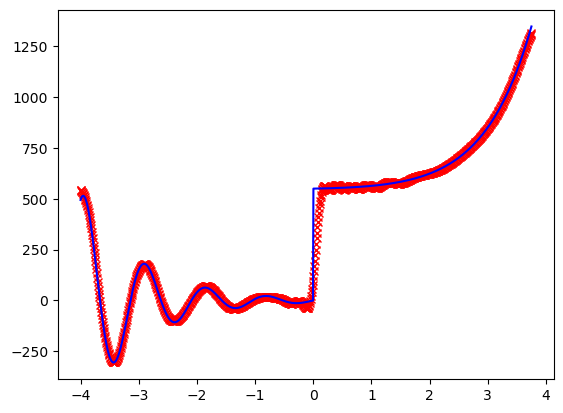

In [11]:
plt.plot(x_test,u_pred,'rx')
plt.plot(x_test,u_true,'b')

In [13]:
a = 0
for i in range(10):
    print(i," ",test_re_full[i][-1])
    a = a + test_re_full[i][-1]
print(a/10)

0   0.04645725694799715
1   0.047432220496429145
2   0.042054456862732376
3   0.043013041522354405
4   0.03162973911356225
5   0.05633097573275284
6   0.05871163057399725
7   0.07434035506550556
8   0.0771589861945
9   0.06572019099467932
0.05428488535045104
